# *CoastSat*: example at Perranporth, United Kingdom


This example shows users how to extract time-series of shoreline change over the last 17+ years at their site of interest.
There are five main steps:
1. Retrieval of the satellite images of the region of interest from Google Earth Engine
2. Shoreline extraction at sub-pixel resolution
3. Intersection of the shorelines with cross-shore transects
4. Tidal correction 
5. Time-series post-processing
6. Validation against in situ surveys

This software is described in details in the following publications: 
- Shoreline detection:                      https://doi.org/10.1016/j.envsoft.2019.104528
- Accuracy assessment and applications:     https://doi.org/10.1016/j.coastaleng.2019.04.004
- Beach slope estimation:                   https://doi.org/10.1029/2020GL088365

## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime, timedelta
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

from scipy import interpolate, stats

## 1. Retrieval of the images from GEE

Define the region of interest (`polygon`), the date range (`dates`) and the satellite missions (`sat_list`) from which you wish to retrieve the satellite images. The images will be cropped on the Google Earth Engine server and only the region of interest will be downloaded as a .tif file. The files will stored in the directory defined in `filepath`. 

Make sure the area of your ROI is smaller than 100 km2 (if larger split it into smaller ROIs).

The function `SDS_download.check_images_available(inputs)` will print the number of images available for your inputs. The Landsat images are divided in Tier 1 and Tier 2, only Tier 1 images can be used for time-series analysis.

For Landsat, users can also choose between Collection 1 and Collection 2 with the `collection` variable. Note that from 1st Jan 2022 newly acquired Landsat images are only available in Collection 2, with Landsat 9 only available in Collection 2, so it's preferred that you use Collection 2.

In [2]:
# region of interest (longitude, latitude)
polygon = [[[-5.16278,50.38195],
            [-5.13074,50.37913],
            [-5.14633,50.33519],
            [-5.18918,50.34059],
            [-5.16278,50.38195]]]
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['1999-01-01', '2024-01-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['S2']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
# name of the site
sitename = 'PERRANPORTH'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 1999-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 855 images
S2:There are 855 images available, 531 images already exist, 324 to download
  Total images available to download from Tier 1: 324 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 Top-of-Atmosphere and Sentinel-2 Level-1C products are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [3]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

Number of images available between 1999-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 855 images
S2:There are 855 images available, 531 images already exist, 324 to download
  Total images available to download from Tier 1: 324 images


PERRANPORTH: Downloading Imagery for 1 satellites:   0%|                                         | 0/1 [00:00<?, ?it/s]
PERRANPORTH, S2: adjusting polygon 0th image :   0%|                                           | 0/324 [00:00<?, ?it/s]
PERRANPORTH, S2: Downloading tif for 0th image :   0%|                                         | 0/324 [00:02<?, ?it/s]
PERRANPORTH, S2: remove duplicates for 0th image :   0%|                                       | 0/324 [00:09<?, ?it/s]
PERRANPORTH, S2: Loading bands for 1st image :   0%|                                   | 1/324 [00:11<59:13, 11.00s/it]

skipping image '2015-06-28-11-35-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 1st image :   0%|                                   | 1/324 [00:11<59:13, 11.00s/it]
PERRANPORTH, S2: Downloading tif for 1st image :   0%|                                 | 1/324 [00:12<59:13, 11.00s/it]
PERRANPORTH, S2: remove duplicates for 1st image :   0%|                               | 1/324 [00:18<59:13, 11.00s/it]
PERRANPORTH, S2: Loading bands for 2nd image :   1%|▏                                  | 2/324 [00:18<48:04,  8.96s/it]

skipping image '2015-07-08-11-36-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 2nd image :   1%|▏                                  | 2/324 [00:19<48:04,  8.96s/it]
PERRANPORTH, S2: Downloading tif for 2nd image :   1%|▏                                | 2/324 [00:21<48:04,  8.96s/it]
PERRANPORTH, S2: remove duplicates for 2nd image :   1%|▏                              | 2/324 [00:27<48:04,  8.96s/it]
PERRANPORTH, S2: Loading bands for 3rd image :   1%|▎                                  | 3/324 [00:27<48:01,  8.98s/it]

skipping image '2015-07-08-11-36-21_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 3rd image :   1%|▎                                  | 3/324 [00:28<48:01,  8.98s/it]
PERRANPORTH, S2: Downloading tif for 3rd image :   1%|▎                                | 3/324 [00:29<48:01,  8.98s/it]
PERRANPORTH, S2: remove duplicates for 3rd image :   1%|▎                              | 3/324 [00:35<48:01,  8.98s/it]
PERRANPORTH, S2: Loading bands for 4th image :   1%|▍                                  | 4/324 [00:35<46:03,  8.63s/it]

skipping image '2015-09-03-11-25-34_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 4th image :   1%|▍                                  | 4/324 [00:35<46:03,  8.63s/it]
PERRANPORTH, S2: Downloading tif for 4th image :   1%|▍                                | 4/324 [00:36<46:03,  8.63s/it]
PERRANPORTH, S2: remove duplicates for 4th image :   1%|▍                              | 4/324 [00:41<46:03,  8.63s/it]
PERRANPORTH, S2: Loading bands for 5th image :   2%|▌                                  | 5/324 [00:41<41:06,  7.73s/it]

skipping image '2015-09-03-11-25-34_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 5th image :   2%|▌                                  | 5/324 [00:42<41:06,  7.73s/it]
PERRANPORTH, S2: Downloading tif for 5th image :   2%|▌                                | 5/324 [00:43<41:06,  7.73s/it]
PERRANPORTH, S2: remove duplicates for 5th image :   2%|▍                              | 5/324 [00:49<41:06,  7.73s/it]
PERRANPORTH, S2: Loading bands for 6th image :   2%|▋                                  | 6/324 [00:49<41:43,  7.87s/it]

skipping image '2015-10-06-11-34-45_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 6th image :   2%|▋                                  | 6/324 [00:50<41:43,  7.87s/it]
PERRANPORTH, S2: Downloading tif for 6th image :   2%|▌                                | 6/324 [00:52<41:43,  7.87s/it]
PERRANPORTH, S2: remove duplicates for 6th image :   2%|▌                              | 6/324 [00:57<41:43,  7.87s/it]
PERRANPORTH, S2: Loading bands for 7th image :   2%|▊                                  | 7/324 [00:57<41:52,  7.93s/it]

skipping image '2015-10-06-11-34-45_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 7th image :   2%|▊                                  | 7/324 [00:58<41:52,  7.93s/it]
PERRANPORTH, S2: Downloading tif for 7th image :   2%|▋                                | 7/324 [01:00<41:52,  7.93s/it]
PERRANPORTH, S2: remove duplicates for 7th image :   2%|▋                              | 7/324 [01:06<41:52,  7.93s/it]
PERRANPORTH, S2: Loading bands for 8th image :   2%|▊                                  | 8/324 [01:06<43:23,  8.24s/it]

skipping image '2015-10-23-11-21-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.96% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 8th image :   2%|▊                                  | 8/324 [01:07<43:23,  8.24s/it]
PERRANPORTH, S2: Downloading tif for 8th image :   2%|▊                                | 8/324 [01:09<43:23,  8.24s/it]
PERRANPORTH, S2: remove duplicates for 8th image :   2%|▊                              | 8/324 [01:14<43:23,  8.24s/it]
PERRANPORTH, S2: Loading bands for 9th image :   3%|▉                                  | 9/324 [01:14<43:03,  8.20s/it]

skipping image '2015-10-23-11-21-26_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 99.96% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 9th image :   3%|▉                                  | 9/324 [01:15<43:03,  8.20s/it]
PERRANPORTH, S2: Downloading tif for 9th image :   3%|▉                                | 9/324 [01:16<43:03,  8.20s/it]
PERRANPORTH, S2: remove duplicates for 9th image :   3%|▊                              | 9/324 [01:24<43:03,  8.20s/it]
PERRANPORTH, S2: Loading bands for 10th image :   3%|█                                | 10/324 [01:24<45:20,  8.66s/it]

skipping image '2015-11-12-11-24-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 10th image :   3%|█                                | 10/324 [01:25<45:20,  8.66s/it]
PERRANPORTH, S2: Downloading tif for 10th image :   3%|▉                              | 10/324 [01:27<45:20,  8.66s/it]
PERRANPORTH, S2: remove duplicates for 10th image :   3%|▉                            | 10/324 [01:33<45:20,  8.66s/it]
PERRANPORTH, S2: Loading bands for 11th image :   3%|█                                | 11/324 [01:33<46:06,  8.84s/it]

skipping image '2015-11-12-11-24-29_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 11th image :   3%|█                                | 11/324 [01:34<46:06,  8.84s/it]
PERRANPORTH, S2: Downloading tif for 11th image :   3%|█                              | 11/324 [01:35<46:06,  8.84s/it]
PERRANPORTH, S2: remove duplicates for 11th image :   3%|▉                            | 11/324 [01:42<46:06,  8.84s/it]
PERRANPORTH, S2: Loading bands for 12th image :   4%|█▏                               | 12/324 [01:42<45:40,  8.78s/it]

skipping image '2015-11-25-11-34-11_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.97% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 12th image :   4%|█▏                               | 12/324 [01:42<45:40,  8.78s/it]
PERRANPORTH, S2: Downloading tif for 12th image :   4%|█▏                             | 12/324 [01:43<45:40,  8.78s/it]
PERRANPORTH, S2: remove duplicates for 12th image :   4%|█                            | 12/324 [01:49<45:40,  8.78s/it]
PERRANPORTH, S2: Loading bands for 13th image :   4%|█▎                               | 13/324 [01:50<43:35,  8.41s/it]

skipping image '2015-11-25-11-34-11_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 98.97% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 13th image :   4%|█▎                               | 13/324 [01:50<43:35,  8.41s/it]
PERRANPORTH, S2: Downloading tif for 13th image :   4%|█▏                             | 13/324 [01:52<43:35,  8.41s/it]
PERRANPORTH, S2: remove duplicates for 13th image :   4%|█▏                           | 13/324 [01:57<43:35,  8.41s/it]
PERRANPORTH, S2: Loading bands for 14th image :   4%|█▍                               | 14/324 [01:57<42:17,  8.18s/it]

skipping image '2015-12-22-11-33-32_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 14th image :   4%|█▍                               | 14/324 [01:58<42:17,  8.18s/it]
PERRANPORTH, S2: Downloading tif for 14th image :   4%|█▎                             | 14/324 [01:59<42:17,  8.18s/it]
PERRANPORTH, S2: remove duplicates for 14th image :   4%|█▎                           | 14/324 [02:05<42:17,  8.18s/it]
PERRANPORTH, S2: Loading bands for 15th image :   5%|█▌                               | 15/324 [02:05<41:52,  8.13s/it]

skipping image '2015-12-22-11-33-32_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 15th image :   5%|█▌                               | 15/324 [02:06<41:52,  8.13s/it]
PERRANPORTH, S2: Downloading tif for 15th image :   5%|█▍                             | 15/324 [02:06<41:52,  8.13s/it]
PERRANPORTH, S2: remove duplicates for 15th image :   5%|█▎                           | 15/324 [02:12<41:52,  8.13s/it]
PERRANPORTH, S2: Loading bands for 16th image :   5%|█▋                               | 16/324 [02:12<40:10,  7.83s/it]

skipping image '2016-01-01-11-31-17_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 16th image :   5%|█▋                               | 16/324 [02:13<40:10,  7.83s/it]
PERRANPORTH, S2: Downloading tif for 16th image :   5%|█▌                             | 16/324 [02:14<40:10,  7.83s/it]
PERRANPORTH, S2: remove duplicates for 16th image :   5%|█▍                           | 16/324 [02:20<40:10,  7.83s/it]
PERRANPORTH, S2: Loading bands for 17th image :   5%|█▋                               | 17/324 [02:21<40:59,  8.01s/it]

skipping image '2016-01-01-11-31-17_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 17th image :   5%|█▋                               | 17/324 [02:21<40:59,  8.01s/it]
PERRANPORTH, S2: Downloading tif for 17th image :   5%|█▋                             | 17/324 [02:23<40:59,  8.01s/it]
PERRANPORTH, S2: remove duplicates for 17th image :   5%|█▌                           | 17/324 [02:28<40:59,  8.01s/it]
PERRANPORTH, S2: Loading bands for 18th image :   6%|█▊                               | 18/324 [02:28<39:55,  7.83s/it]

skipping image '2016-01-04-11-46-45_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 18th image :   6%|█▊                               | 18/324 [02:29<39:55,  7.83s/it]
PERRANPORTH, S2: Downloading tif for 18th image :   6%|█▋                             | 18/324 [02:29<39:55,  7.83s/it]
PERRANPORTH, S2: remove duplicates for 18th image :   6%|█▌                           | 18/324 [02:35<39:55,  7.83s/it]
PERRANPORTH, S2: Loading bands for 19th image :   6%|█▉                               | 19/324 [02:35<38:33,  7.58s/it]

skipping image '2016-01-04-11-46-45_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 19th image :   6%|█▉                               | 19/324 [02:36<38:33,  7.58s/it]
PERRANPORTH, S2: Downloading tif for 19th image :   6%|█▊                             | 19/324 [02:37<38:33,  7.58s/it]
PERRANPORTH, S2: remove duplicates for 19th image :   6%|█▋                           | 19/324 [02:43<38:33,  7.58s/it]
PERRANPORTH, S2: Loading bands for 20th image :   6%|██                               | 20/324 [02:43<38:33,  7.61s/it]

skipping image '2016-01-21-11-30-08_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 20th image :   6%|██                               | 20/324 [02:43<38:33,  7.61s/it]
PERRANPORTH, S2: Downloading tif for 20th image :   6%|█▉                             | 20/324 [02:44<38:33,  7.61s/it]
PERRANPORTH, S2: remove duplicates for 20th image :   6%|█▊                           | 20/324 [02:50<38:33,  7.61s/it]
PERRANPORTH, S2: Loading bands for 21st image :   6%|██▏                              | 21/324 [02:50<37:51,  7.50s/it]

skipping image '2016-01-21-11-30-08_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 21st image :   6%|██▏                              | 21/324 [02:50<37:51,  7.50s/it]
PERRANPORTH, S2: Downloading tif for 21st image :   6%|██                             | 21/324 [02:51<37:51,  7.50s/it]
PERRANPORTH, S2: remove duplicates for 21st image :   6%|█▉                           | 21/324 [02:57<37:51,  7.50s/it]
PERRANPORTH, S2: Loading bands for 22nd image :   7%|██▏                              | 22/324 [02:57<36:55,  7.34s/it]

skipping image '2016-02-13-11-31-59_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 22nd image :   7%|██▏                              | 22/324 [02:57<36:55,  7.34s/it]
PERRANPORTH, S2: Downloading tif for 22nd image :   7%|██                             | 22/324 [02:59<36:55,  7.34s/it]
PERRANPORTH, S2: remove duplicates for 22nd image :   7%|█▉                           | 22/324 [03:04<36:55,  7.34s/it]
PERRANPORTH, S2: Loading bands for 23rd image :   7%|██▎                              | 23/324 [03:05<36:49,  7.34s/it]

skipping image '2016-02-13-11-31-59_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 23rd image :   7%|██▎                              | 23/324 [03:05<36:49,  7.34s/it]
PERRANPORTH, S2: Downloading tif for 23rd image :   7%|██▏                            | 23/324 [03:06<36:49,  7.34s/it]
PERRANPORTH, S2: remove duplicates for 23rd image :   7%|██                           | 23/324 [03:16<36:49,  7.34s/it]
PERRANPORTH, S2: Loading bands for 24th image :   7%|██▍                              | 24/324 [03:16<42:50,  8.57s/it]

skipping image '2016-04-13-11-33-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 24th image :   7%|██▍                              | 24/324 [03:16<42:50,  8.57s/it]
PERRANPORTH, S2: Downloading tif for 24th image :   7%|██▎                            | 24/324 [03:17<42:50,  8.57s/it]
PERRANPORTH, S2: remove duplicates for 24th image :   7%|██▏                          | 24/324 [03:23<42:50,  8.57s/it]
PERRANPORTH, S2: Loading bands for 25th image :   8%|██▌                              | 25/324 [03:23<40:17,  8.09s/it]

skipping image '2016-04-13-11-33-18_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 25th image :   8%|██▌                              | 25/324 [03:23<40:17,  8.09s/it]
PERRANPORTH, S2: Downloading tif for 25th image :   8%|██▍                            | 25/324 [03:24<40:17,  8.09s/it]
PERRANPORTH, S2: remove duplicates for 25th image :   8%|██▏                          | 25/324 [03:30<40:17,  8.09s/it]
PERRANPORTH, S2: Loading bands for 26th image :   8%|██▋                              | 26/324 [03:30<38:42,  7.79s/it]

skipping image '2016-06-09-11-24-43_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 26th image :   8%|██▋                              | 26/324 [03:30<38:42,  7.79s/it]
PERRANPORTH, S2: Downloading tif for 26th image :   8%|██▍                            | 26/324 [03:31<38:42,  7.79s/it]
PERRANPORTH, S2: remove duplicates for 26th image :   8%|██▎                          | 26/324 [03:36<38:42,  7.79s/it]
PERRANPORTH, S2: Loading bands for 27th image :   8%|██▊                              | 27/324 [03:36<36:32,  7.38s/it]

skipping image '2016-06-09-11-24-43_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 27th image :   8%|██▊                              | 27/324 [03:37<36:32,  7.38s/it]
PERRANPORTH, S2: Downloading tif for 27th image :   8%|██▌                            | 27/324 [03:38<36:32,  7.38s/it]
PERRANPORTH, S2: remove duplicates for 27th image :   8%|██▍                          | 27/324 [03:45<36:32,  7.38s/it]
PERRANPORTH, S2: Loading bands for 28th image :   9%|██▊                              | 28/324 [03:45<37:56,  7.69s/it]

skipping image '2016-07-12-11-33-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 28th image :   9%|██▊                              | 28/324 [03:45<37:56,  7.69s/it]
PERRANPORTH, S2: Downloading tif for 28th image :   9%|██▋                            | 28/324 [03:46<37:56,  7.69s/it]
PERRANPORTH, S2: remove duplicates for 28th image :   9%|██▌                          | 28/324 [03:51<37:56,  7.69s/it]
PERRANPORTH, S2: Loading bands for 29th image :   9%|██▉                              | 29/324 [03:52<36:35,  7.44s/it]

skipping image '2016-07-12-11-33-22_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 29th image :   9%|██▉                              | 29/324 [03:52<36:35,  7.44s/it]
PERRANPORTH, S2: Downloading tif for 29th image :   9%|██▊                            | 29/324 [03:53<36:35,  7.44s/it]
PERRANPORTH, S2: remove duplicates for 29th image :   9%|██▌                          | 29/324 [03:58<36:35,  7.44s/it]
PERRANPORTH, S2: Loading bands for 30th image :   9%|███                              | 30/324 [03:58<35:12,  7.19s/it]

skipping image '2016-07-22-11-33-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 30th image :   9%|███                              | 30/324 [03:59<35:12,  7.19s/it]
PERRANPORTH, S2: Downloading tif for 30th image :   9%|██▊                            | 30/324 [03:59<35:12,  7.19s/it]
PERRANPORTH, S2: remove duplicates for 30th image :   9%|██▋                          | 30/324 [04:04<35:12,  7.19s/it]
PERRANPORTH, S2: Loading bands for 31st image :  10%|███▏                             | 31/324 [04:04<33:37,  6.88s/it]

skipping image '2016-07-22-11-33-23_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 31st image :  10%|███▏                             | 31/324 [04:05<33:37,  6.88s/it]
PERRANPORTH, S2: Downloading tif for 31st image :  10%|██▉                            | 31/324 [04:05<33:37,  6.88s/it]
PERRANPORTH, S2: remove duplicates for 31st image :  10%|██▊                          | 31/324 [04:11<33:37,  6.88s/it]
PERRANPORTH, S2: Loading bands for 32nd image :  10%|███▎                             | 32/324 [04:11<32:44,  6.73s/it]

skipping image '2016-08-11-11-33-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 32nd image :  10%|███▎                             | 32/324 [04:11<32:44,  6.73s/it]
PERRANPORTH, S2: Downloading tif for 32nd image :  10%|███                            | 32/324 [04:12<32:44,  6.73s/it]
PERRANPORTH, S2: remove duplicates for 32nd image :  10%|██▊                          | 32/324 [04:20<32:44,  6.73s/it]
PERRANPORTH, S2: Loading bands for 33rd image :  10%|███▎                             | 33/324 [04:20<36:07,  7.45s/it]

skipping image '2016-08-11-11-33-22_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 33rd image :  10%|███▎                             | 33/324 [04:20<36:07,  7.45s/it]
PERRANPORTH, S2: Downloading tif for 33rd image :  10%|███▏                           | 33/324 [04:21<36:07,  7.45s/it]
PERRANPORTH, S2: remove duplicates for 33rd image :  10%|██▉                          | 33/324 [04:27<36:07,  7.45s/it]
PERRANPORTH, S2: Loading bands for 34th image :  10%|███▍                             | 34/324 [04:27<35:23,  7.32s/it]

skipping image '2016-08-18-11-25-54_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 34th image :  10%|███▍                             | 34/324 [04:27<35:23,  7.32s/it]
PERRANPORTH, S2: Downloading tif for 34th image :  10%|███▎                           | 34/324 [04:28<35:23,  7.32s/it]
PERRANPORTH, S2: remove duplicates for 34th image :  10%|███                          | 34/324 [04:34<35:23,  7.32s/it]
PERRANPORTH, S2: Loading bands for 35th image :  11%|███▌                             | 35/324 [04:35<35:43,  7.42s/it]

skipping image '2016-08-18-11-25-54_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 35th image :  11%|███▌                             | 35/324 [04:35<35:43,  7.42s/it]
PERRANPORTH, S2: Downloading tif for 35th image :  11%|███▎                           | 35/324 [04:36<35:43,  7.42s/it]
PERRANPORTH, S2: remove duplicates for 35th image :  11%|███▏                         | 35/324 [04:40<35:43,  7.42s/it]
PERRANPORTH, S2: Loading bands for 36th image :  11%|███▋                             | 36/324 [04:40<33:14,  6.92s/it]

skipping image '2016-09-07-11-26-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.68% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 36th image :  11%|███▋                             | 36/324 [04:41<33:14,  6.92s/it]
PERRANPORTH, S2: Downloading tif for 36th image :  11%|███▍                           | 36/324 [04:41<33:14,  6.92s/it]
PERRANPORTH, S2: remove duplicates for 36th image :  11%|███▏                         | 36/324 [04:46<33:14,  6.92s/it]
PERRANPORTH, S2: Loading bands for 37th image :  11%|███▊                             | 37/324 [04:46<31:02,  6.49s/it]

skipping image '2016-09-07-11-26-22_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 99.68% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 37th image :  11%|███▊                             | 37/324 [04:46<31:02,  6.49s/it]
PERRANPORTH, S2: Downloading tif for 37th image :  11%|███▌                           | 37/324 [04:47<31:02,  6.49s/it]
PERRANPORTH, S2: remove duplicates for 37th image :  11%|███▎                         | 37/324 [04:51<31:02,  6.49s/it]
PERRANPORTH, S2: Transforming 37th image :  11%|████▎                                 | 37/324 [04:51<31:02,  6.49s/it]


skipping image '2016-09-20-11-33-13_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%


PERRANPORTH, S2: adjusting polygon 38th image :  12%|███▊                             | 38/324 [04:52<29:40,  6.22s/it]
PERRANPORTH, S2: Downloading tif for 38th image :  12%|███▋                           | 38/324 [04:52<29:40,  6.22s/it]
PERRANPORTH, S2: remove duplicates for 38th image :  12%|███▍                         | 38/324 [04:58<29:40,  6.22s/it]
PERRANPORTH, S2: Loading bands for 39th image :  12%|███▉                             | 39/324 [04:59<30:43,  6.47s/it]

skipping image '2016-09-20-11-33-13_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 39th image :  12%|███▉                             | 39/324 [04:59<30:43,  6.47s/it]
PERRANPORTH, S2: Downloading tif for 39th image :  12%|███▋                           | 39/324 [05:00<30:43,  6.47s/it]
PERRANPORTH, S2: remove duplicates for 39th image :  12%|███▍                         | 39/324 [05:05<30:43,  6.47s/it]
PERRANPORTH, S2: Loading bands for 40th image :  12%|████                             | 40/324 [05:06<31:22,  6.63s/it]

skipping image '2016-09-27-11-25-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 40th image :  12%|████                             | 40/324 [05:06<31:22,  6.63s/it]
PERRANPORTH, S2: Downloading tif for 40th image :  12%|███▊                           | 40/324 [05:07<31:22,  6.63s/it]
PERRANPORTH, S2: remove duplicates for 40th image :  12%|███▌                         | 40/324 [05:12<31:22,  6.63s/it]
PERRANPORTH, S2: Loading bands for 41st image :  13%|████▏                            | 41/324 [05:12<31:33,  6.69s/it]

skipping image '2016-09-27-11-25-25_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 41st image :  13%|████▏                            | 41/324 [05:13<31:33,  6.69s/it]
PERRANPORTH, S2: Downloading tif for 41st image :  13%|███▉                           | 41/324 [05:13<31:33,  6.69s/it]
PERRANPORTH, S2: remove duplicates for 41st image :  13%|███▋                         | 41/324 [05:19<31:33,  6.69s/it]
PERRANPORTH, S2: Loading bands for 42nd image :  13%|████▎                            | 42/324 [05:19<31:44,  6.75s/it]

skipping image '2016-10-20-11-35-56_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 42nd image :  13%|████▎                            | 42/324 [05:20<31:44,  6.75s/it]
PERRANPORTH, S2: Downloading tif for 42nd image :  13%|████                           | 42/324 [05:21<31:44,  6.75s/it]
PERRANPORTH, S2: remove duplicates for 42nd image :  13%|███▊                         | 42/324 [05:27<31:44,  6.75s/it]
PERRANPORTH, S2: Loading bands for 43rd image :  13%|████▍                            | 43/324 [05:27<33:13,  7.09s/it]

skipping image '2016-10-20-11-35-56_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 43rd image :  13%|████▍                            | 43/324 [05:27<33:13,  7.09s/it]
PERRANPORTH, S2: Downloading tif for 43rd image :  13%|████                           | 43/324 [05:29<33:13,  7.09s/it]
PERRANPORTH, S2: remove duplicates for 43rd image :  13%|███▊                         | 43/324 [05:36<33:13,  7.09s/it]
PERRANPORTH, S2: Loading bands for 44th image :  14%|████▍                            | 44/324 [05:36<36:12,  7.76s/it]

skipping image '2016-11-06-11-23-07_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 44th image :  14%|████▍                            | 44/324 [05:37<36:12,  7.76s/it]
PERRANPORTH, S2: Downloading tif for 44th image :  14%|████▏                          | 44/324 [05:38<36:12,  7.76s/it]
PERRANPORTH, S2: remove duplicates for 44th image :  14%|███▉                         | 44/324 [05:44<36:12,  7.76s/it]
PERRANPORTH, S2: Loading bands for 45th image :  14%|████▌                            | 45/324 [05:44<35:58,  7.73s/it]

skipping image '2016-11-06-11-23-07_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 45th image :  14%|████▌                            | 45/324 [05:44<35:58,  7.73s/it]
PERRANPORTH, S2: Downloading tif for 45th image :  14%|████▎                          | 45/324 [05:45<35:58,  7.73s/it]
PERRANPORTH, S2: remove duplicates for 45th image :  14%|████                         | 45/324 [05:50<35:58,  7.73s/it]
PERRANPORTH, S2: Loading bands for 46th image :  14%|████▋                            | 46/324 [05:50<33:08,  7.15s/it]

skipping image '2016-11-16-11-23-35_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 46th image :  14%|████▋                            | 46/324 [05:50<33:08,  7.15s/it]
PERRANPORTH, S2: Downloading tif for 46th image :  14%|████▍                          | 46/324 [05:51<33:08,  7.15s/it]
PERRANPORTH, S2: remove duplicates for 46th image :  14%|████                         | 46/324 [05:56<33:08,  7.15s/it]
PERRANPORTH, S2: Loading bands for 47th image :  15%|████▊                            | 47/324 [05:57<32:13,  6.98s/it]

skipping image '2016-11-16-11-23-35_S2_PERRANPORTH_ms_dup1.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 47th image :  15%|████▊                            | 47/324 [05:57<32:13,  6.98s/it]
PERRANPORTH, S2: Downloading tif for 47th image :  15%|████▍                          | 47/324 [05:58<32:13,  6.98s/it]
PERRANPORTH, S2: remove duplicates for 47th image :  15%|████▏                        | 47/324 [06:02<32:13,  6.98s/it]
PERRANPORTH, S2: Loading bands for 48th image :  15%|████▉                            | 48/324 [06:03<30:50,  6.71s/it]

skipping image '2016-12-16-11-26-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.91% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 48th image :  15%|████▉                            | 48/324 [06:03<30:50,  6.71s/it]
PERRANPORTH, S2: Downloading tif for 48th image :  15%|████▌                          | 48/324 [06:04<30:50,  6.71s/it]
PERRANPORTH, S2: remove duplicates for 48th image :  15%|████▎                        | 48/324 [06:08<30:50,  6.71s/it]
PERRANPORTH, S2: Loading bands for 49th image :  15%|████▉                            | 49/324 [06:09<29:48,  6.50s/it]

skipping image '2016-12-29-11-34-56_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 49th image :  15%|████▉                            | 49/324 [06:09<29:48,  6.50s/it]
PERRANPORTH, S2: Downloading tif for 49th image :  15%|████▋                          | 49/324 [06:10<29:48,  6.50s/it]
PERRANPORTH, S2: remove duplicates for 49th image :  15%|████▍                        | 49/324 [06:15<29:48,  6.50s/it]
PERRANPORTH, S2: Loading bands for 50th image :  15%|█████                            | 50/324 [06:15<30:08,  6.60s/it]

skipping image '2017-01-05-11-24-39_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 50th image :  15%|█████                            | 50/324 [06:16<30:08,  6.60s/it]
PERRANPORTH, S2: Downloading tif for 50th image :  15%|████▊                          | 50/324 [06:17<30:08,  6.60s/it]
PERRANPORTH, S2: remove duplicates for 50th image :  15%|████▍                        | 50/324 [06:21<30:08,  6.60s/it]
PERRANPORTH, S2: Loading bands for 51st image :  16%|█████▏                           | 51/324 [06:22<29:41,  6.53s/it]

skipping image '2017-02-04-11-22-41_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 51st image :  16%|█████▏                           | 51/324 [06:22<29:41,  6.53s/it]
PERRANPORTH, S2: Downloading tif for 51st image :  16%|████▉                          | 51/324 [06:23<29:41,  6.53s/it]
PERRANPORTH, S2: remove duplicates for 51st image :  16%|████▌                        | 51/324 [06:28<29:41,  6.53s/it]
PERRANPORTH, S2: Loading bands for 52nd image :  16%|█████▎                           | 52/324 [06:29<30:08,  6.65s/it]

skipping image '2017-02-17-11-33-13_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.31% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 52nd image :  16%|█████▎                           | 52/324 [06:30<30:08,  6.65s/it]
PERRANPORTH, S2: Downloading tif for 52nd image :  16%|████▉                          | 52/324 [06:31<30:08,  6.65s/it]
PERRANPORTH, S2: remove duplicates for 52nd image :  16%|████▋                        | 52/324 [06:35<30:08,  6.65s/it]
PERRANPORTH, S2: Loading bands for 53rd image :  16%|█████▍                           | 53/324 [06:35<29:59,  6.64s/it]

skipping image '2017-02-27-11-33-12_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 53rd image :  16%|█████▍                           | 53/324 [06:36<29:59,  6.64s/it]
PERRANPORTH, S2: Downloading tif for 53rd image :  16%|█████                          | 53/324 [06:36<29:59,  6.64s/it]
PERRANPORTH, S2: remove duplicates for 53rd image :  16%|████▋                        | 53/324 [06:41<29:59,  6.64s/it]
PERRANPORTH, S2: Loading bands for 54th image :  17%|█████▌                           | 54/324 [06:41<28:48,  6.40s/it]

skipping image '2017-03-06-11-21-06_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 96.50% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 54th image :  17%|█████▌                           | 54/324 [06:41<28:48,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 54th image :  17%|█████▏                         | 54/324 [06:42<28:48,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 54th image :  17%|████▊                        | 54/324 [06:47<28:48,  6.40s/it]
PERRANPORTH, S2: Loading bands for 55th image :  17%|█████▌                           | 55/324 [06:47<27:56,  6.23s/it]

skipping image '2017-03-19-11-33-10_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 55th image :  17%|█████▌                           | 55/324 [06:47<27:56,  6.23s/it]
PERRANPORTH, S2: Downloading tif for 55th image :  17%|█████▎                         | 55/324 [06:48<27:56,  6.23s/it]
PERRANPORTH, S2: remove duplicates for 55th image :  17%|████▉                        | 55/324 [06:54<27:56,  6.23s/it]
PERRANPORTH, S2: Loading bands for 56th image :  17%|█████▋                           | 56/324 [06:54<28:47,  6.45s/it]

skipping image '2017-05-05-11-25-14_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 56th image :  17%|█████▋                           | 56/324 [06:54<28:47,  6.45s/it]
PERRANPORTH, S2: Downloading tif for 56th image :  17%|█████▎                         | 56/324 [06:55<28:47,  6.45s/it]
PERRANPORTH, S2: remove duplicates for 56th image :  17%|█████                        | 56/324 [07:01<28:47,  6.45s/it]
PERRANPORTH, S2: Loading bands for 57th image :  18%|█████▊                           | 57/324 [07:01<29:28,  6.62s/it]

skipping image '2017-06-14-11-24-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 57th image :  18%|█████▊                           | 57/324 [07:01<29:28,  6.62s/it]
PERRANPORTH, S2: Downloading tif for 57th image :  18%|█████▍                         | 57/324 [07:02<29:28,  6.62s/it]
PERRANPORTH, S2: remove duplicates for 57th image :  18%|█████                        | 57/324 [07:09<29:28,  6.62s/it]
PERRANPORTH, S2: Loading bands for 58th image :  18%|█████▉                           | 58/324 [07:09<31:06,  7.02s/it]

skipping image '2017-06-24-11-21-12_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 58th image :  18%|█████▉                           | 58/324 [07:09<31:06,  7.02s/it]
PERRANPORTH, S2: Downloading tif for 58th image :  18%|█████▌                         | 58/324 [07:11<31:06,  7.02s/it]
PERRANPORTH, S2: remove duplicates for 58th image :  18%|█████▏                       | 58/324 [07:15<31:06,  7.02s/it]
PERRANPORTH, S2: Loading bands for 59th image :  18%|██████                           | 59/324 [07:16<30:36,  6.93s/it]

skipping image '2017-06-27-11-33-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 59th image :  18%|██████                           | 59/324 [07:16<30:36,  6.93s/it]
PERRANPORTH, S2: Downloading tif for 59th image :  18%|█████▋                         | 59/324 [07:17<30:36,  6.93s/it]
PERRANPORTH, S2: remove duplicates for 59th image :  18%|█████▎                       | 59/324 [07:22<30:36,  6.93s/it]
PERRANPORTH, S2: Loading bands for 60th image :  19%|██████                           | 60/324 [07:22<30:11,  6.86s/it]

skipping image '2017-07-04-11-24-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 60th image :  19%|██████                           | 60/324 [07:23<30:11,  6.86s/it]
PERRANPORTH, S2: Downloading tif for 60th image :  19%|█████▋                         | 60/324 [07:24<30:11,  6.86s/it]
PERRANPORTH, S2: remove duplicates for 60th image :  19%|█████▎                       | 60/324 [07:27<30:11,  6.86s/it]
PERRANPORTH, S2: Loading bands for 61st image :  19%|██████▏                          | 61/324 [07:28<28:02,  6.40s/it]

skipping image '2017-07-07-11-36-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.55% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 61st image :  19%|██████▏                          | 61/324 [07:28<28:02,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 61st image :  19%|█████▊                         | 61/324 [07:29<28:02,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 61st image :  19%|█████▍                       | 61/324 [07:34<28:02,  6.40s/it]
PERRANPORTH, S2: Loading bands for 62nd image :  19%|██████▎                          | 62/324 [07:34<27:56,  6.40s/it]

skipping image '2017-07-09-11-21-13_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 62nd image :  19%|██████▎                          | 62/324 [07:34<27:56,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 62nd image :  19%|█████▉                         | 62/324 [07:35<27:56,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 62nd image :  19%|█████▌                       | 62/324 [07:40<27:56,  6.40s/it]
PERRANPORTH, S2: Loading bands for 63rd image :  19%|██████▍                          | 63/324 [07:40<27:40,  6.36s/it]

skipping image '2017-07-14-11-21-14_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 96.66% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 63rd image :  19%|██████▍                          | 63/324 [07:41<27:40,  6.36s/it]
PERRANPORTH, S2: Downloading tif for 63rd image :  19%|██████                         | 63/324 [07:41<27:40,  6.36s/it]
PERRANPORTH, S2: remove duplicates for 63rd image :  19%|█████▋                       | 63/324 [07:46<27:40,  6.36s/it]
PERRANPORTH, S2: Loading bands for 64th image :  20%|██████▌                          | 64/324 [07:47<27:40,  6.39s/it]

skipping image '2017-07-17-11-33-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 64th image :  20%|██████▌                          | 64/324 [07:47<27:40,  6.39s/it]
PERRANPORTH, S2: Downloading tif for 64th image :  20%|██████                         | 64/324 [07:48<27:40,  6.39s/it]
PERRANPORTH, S2: remove duplicates for 64th image :  20%|█████▋                       | 64/324 [07:54<27:40,  6.39s/it]
PERRANPORTH, S2: Loading bands for 65th image :  20%|██████▌                          | 65/324 [07:54<29:07,  6.75s/it]

skipping image '2017-07-19-11-25-11_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 65th image :  20%|██████▌                          | 65/324 [07:55<29:07,  6.75s/it]
PERRANPORTH, S2: Downloading tif for 65th image :  20%|██████▏                        | 65/324 [07:55<29:07,  6.75s/it]
PERRANPORTH, S2: remove duplicates for 65th image :  20%|█████▊                       | 65/324 [08:01<29:07,  6.75s/it]
PERRANPORTH, S2: Loading bands for 66th image :  20%|██████▋                          | 66/324 [08:02<29:53,  6.95s/it]

skipping image '2017-07-22-11-33-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 66th image :  20%|██████▋                          | 66/324 [08:02<29:53,  6.95s/it]
PERRANPORTH, S2: Downloading tif for 66th image :  20%|██████▎                        | 66/324 [08:03<29:53,  6.95s/it]
PERRANPORTH, S2: remove duplicates for 66th image :  20%|█████▉                       | 66/324 [08:07<29:53,  6.95s/it]
PERRANPORTH, S2: Loading bands for 67th image :  21%|██████▊                          | 67/324 [08:08<28:25,  6.63s/it]

skipping image '2017-08-01-11-34-08_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 67th image :  21%|██████▊                          | 67/324 [08:08<28:25,  6.63s/it]
PERRANPORTH, S2: Downloading tif for 67th image :  21%|██████▍                        | 67/324 [08:09<28:25,  6.63s/it]
PERRANPORTH, S2: remove duplicates for 67th image :  21%|█████▉                       | 67/324 [08:14<28:25,  6.63s/it]
PERRANPORTH, S2: Loading bands for 68th image :  21%|██████▉                          | 68/324 [08:15<28:47,  6.75s/it]

skipping image '2017-08-03-11-21-15_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 68th image :  21%|██████▉                          | 68/324 [08:15<28:47,  6.75s/it]
PERRANPORTH, S2: Downloading tif for 68th image :  21%|██████▌                        | 68/324 [08:16<28:47,  6.75s/it]
PERRANPORTH, S2: remove duplicates for 68th image :  21%|██████                       | 68/324 [08:21<28:47,  6.75s/it]
PERRANPORTH, S2: Loading bands for 69th image :  21%|███████                          | 69/324 [08:21<28:36,  6.73s/it]

skipping image '2017-08-13-11-24-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 69th image :  21%|███████                          | 69/324 [08:22<28:36,  6.73s/it]
PERRANPORTH, S2: Downloading tif for 69th image :  21%|██████▌                        | 69/324 [08:22<28:36,  6.73s/it]
PERRANPORTH, S2: remove duplicates for 69th image :  21%|██████▏                      | 69/324 [08:28<28:36,  6.73s/it]
PERRANPORTH, S2: Loading bands for 70th image :  22%|███████▏                         | 70/324 [08:29<29:08,  6.88s/it]

skipping image '2017-08-23-11-21-14_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.93% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 70th image :  22%|███████▏                         | 70/324 [08:29<29:08,  6.88s/it]
PERRANPORTH, S2: Downloading tif for 70th image :  22%|██████▋                        | 70/324 [08:30<29:08,  6.88s/it]
PERRANPORTH, S2: remove duplicates for 70th image :  22%|██████▎                      | 70/324 [08:35<29:08,  6.88s/it]
PERRANPORTH, S2: Loading bands for 71st image :  22%|███████▏                         | 71/324 [08:35<28:36,  6.78s/it]

skipping image '2017-08-31-11-35-05_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 71st image :  22%|███████▏                         | 71/324 [08:35<28:36,  6.78s/it]
PERRANPORTH, S2: Downloading tif for 71st image :  22%|██████▊                        | 71/324 [08:37<28:36,  6.78s/it]
PERRANPORTH, S2: remove duplicates for 71st image :  22%|██████▎                      | 71/324 [08:41<28:36,  6.78s/it]
PERRANPORTH, S2: Loading bands for 72nd image :  22%|███████▎                         | 72/324 [08:42<28:03,  6.68s/it]

skipping image '2017-09-05-11-36-11_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 72nd image :  22%|███████▎                         | 72/324 [08:42<28:03,  6.68s/it]
PERRANPORTH, S2: Downloading tif for 72nd image :  22%|██████▉                        | 72/324 [08:43<28:03,  6.68s/it]
PERRANPORTH, S2: remove duplicates for 72nd image :  22%|██████▍                      | 72/324 [08:48<28:03,  6.68s/it]
PERRANPORTH, S2: Loading bands for 73rd image :  23%|███████▍                         | 73/324 [08:48<27:32,  6.58s/it]

skipping image '2017-09-25-11-33-15_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 73rd image :  23%|███████▍                         | 73/324 [08:48<27:32,  6.58s/it]
PERRANPORTH, S2: Downloading tif for 73rd image :  23%|██████▉                        | 73/324 [08:49<27:32,  6.58s/it]
PERRANPORTH, S2: remove duplicates for 73rd image :  23%|██████▌                      | 73/324 [08:53<27:32,  6.58s/it]
PERRANPORTH, S2: Loading bands for 74th image :  23%|███████▌                         | 74/324 [08:53<25:30,  6.12s/it]

skipping image '2017-09-30-11-33-03_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 74th image :  23%|███████▌                         | 74/324 [08:53<25:30,  6.12s/it]
PERRANPORTH, S2: Downloading tif for 74th image :  23%|███████                        | 74/324 [08:54<25:30,  6.12s/it]
PERRANPORTH, S2: remove duplicates for 74th image :  23%|██████▌                      | 74/324 [08:59<25:30,  6.12s/it]
PERRANPORTH, S2: Loading bands for 75th image :  23%|███████▋                         | 75/324 [09:00<26:01,  6.27s/it]

skipping image '2017-10-10-11-33-04_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.91% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 75th image :  23%|███████▋                         | 75/324 [09:00<26:01,  6.27s/it]
PERRANPORTH, S2: Downloading tif for 75th image :  23%|███████▏                       | 75/324 [09:01<26:01,  6.27s/it]
PERRANPORTH, S2: remove duplicates for 75th image :  23%|██████▋                      | 75/324 [09:04<26:01,  6.27s/it]
PERRANPORTH, S2: Loading bands for 76th image :  23%|███████▋                         | 76/324 [09:05<24:20,  5.89s/it]

skipping image '2017-10-20-11-33-05_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 76th image :  23%|███████▋                         | 76/324 [09:05<24:20,  5.89s/it]
PERRANPORTH, S2: Downloading tif for 76th image :  23%|███████▎                       | 76/324 [09:06<24:20,  5.89s/it]
PERRANPORTH, S2: remove duplicates for 76th image :  23%|██████▊                      | 76/324 [09:10<24:20,  5.89s/it]
PERRANPORTH, S2: Loading bands for 77th image :  24%|███████▊                         | 77/324 [09:10<23:47,  5.78s/it]

skipping image '2017-10-25-11-33-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 77th image :  24%|███████▊                         | 77/324 [09:10<23:47,  5.78s/it]
PERRANPORTH, S2: Downloading tif for 77th image :  24%|███████▎                       | 77/324 [09:11<23:47,  5.78s/it]
PERRANPORTH, S2: remove duplicates for 77th image :  24%|██████▉                      | 77/324 [09:16<23:47,  5.78s/it]
PERRANPORTH, S2: Loading bands for 78th image :  24%|███████▉                         | 78/324 [09:16<24:16,  5.92s/it]

skipping image '2017-10-27-11-25-51_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 78th image :  24%|███████▉                         | 78/324 [09:17<24:16,  5.92s/it]
PERRANPORTH, S2: Downloading tif for 78th image :  24%|███████▍                       | 78/324 [09:17<24:16,  5.92s/it]
PERRANPORTH, S2: remove duplicates for 78th image :  24%|██████▉                      | 78/324 [09:22<24:16,  5.92s/it]
PERRANPORTH, S2: Loading bands for 79th image :  24%|████████                         | 79/324 [09:22<23:46,  5.82s/it]

skipping image '2017-10-30-11-33-05_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 79th image :  24%|████████                         | 79/324 [09:22<23:46,  5.82s/it]
PERRANPORTH, S2: Downloading tif for 79th image :  24%|███████▌                       | 79/324 [09:24<23:46,  5.82s/it]
PERRANPORTH, S2: remove duplicates for 79th image :  24%|███████                      | 79/324 [09:28<23:46,  5.82s/it]
PERRANPORTH, S2: Loading bands for 80th image :  25%|████████▏                        | 80/324 [09:28<24:03,  5.92s/it]


skipping image '2017-11-09-11-33-05_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%


PERRANPORTH, S2: adjusting polygon 80th image :  25%|████████▏                        | 80/324 [09:28<24:03,  5.92s/it]
PERRANPORTH, S2: Downloading tif for 80th image :  25%|███████▋                       | 80/324 [09:29<24:03,  5.92s/it]
PERRANPORTH, S2: remove duplicates for 80th image :  25%|███████▏                     | 80/324 [09:34<24:03,  5.92s/it]
PERRANPORTH, S2: Loading bands for 81st image :  25%|████████▎                        | 81/324 [09:34<23:50,  5.89s/it]

skipping image '2017-11-16-11-23-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 81st image :  25%|████████▎                        | 81/324 [09:34<23:50,  5.89s/it]
PERRANPORTH, S2: Downloading tif for 81st image :  25%|███████▊                       | 81/324 [09:35<23:50,  5.89s/it]
PERRANPORTH, S2: remove duplicates for 81st image :  25%|███████▎                     | 81/324 [09:40<23:50,  5.89s/it]
PERRANPORTH, S2: Loading bands for 82nd image :  25%|████████▎                        | 82/324 [09:40<23:58,  5.94s/it]

skipping image '2017-11-19-11-35-13_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 82nd image :  25%|████████▎                        | 82/324 [09:40<23:58,  5.94s/it]
PERRANPORTH, S2: Downloading tif for 82nd image :  25%|███████▊                       | 82/324 [09:41<23:58,  5.94s/it]
PERRANPORTH, S2: remove duplicates for 82nd image :  25%|███████▎                     | 82/324 [09:47<23:58,  5.94s/it]
PERRANPORTH, S2: Loading bands for 83rd image :  26%|████████▍                        | 83/324 [09:47<25:03,  6.24s/it]

skipping image '2017-11-24-11-34-07_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 83rd image :  26%|████████▍                        | 83/324 [09:47<25:03,  6.24s/it]
PERRANPORTH, S2: Downloading tif for 83rd image :  26%|███████▉                       | 83/324 [09:48<25:03,  6.24s/it]
PERRANPORTH, S2: remove duplicates for 83rd image :  26%|███████▍                     | 83/324 [09:54<25:03,  6.24s/it]
PERRANPORTH, S2: Loading bands for 84th image :  26%|████████▌                        | 84/324 [09:55<26:34,  6.64s/it]

skipping image '2017-12-04-11-34-36_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 84th image :  26%|████████▌                        | 84/324 [09:55<26:34,  6.64s/it]
PERRANPORTH, S2: Downloading tif for 84th image :  26%|████████                       | 84/324 [09:56<26:34,  6.64s/it]
PERRANPORTH, S2: remove duplicates for 84th image :  26%|███████▌                     | 84/324 [10:01<26:34,  6.64s/it]
PERRANPORTH, S2: Loading bands for 85th image :  26%|████████▋                        | 85/324 [10:02<27:02,  6.79s/it]

skipping image '2017-12-14-11-34-54_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 85th image :  26%|████████▋                        | 85/324 [10:02<27:02,  6.79s/it]
PERRANPORTH, S2: Downloading tif for 85th image :  26%|████████▏                      | 85/324 [10:03<27:02,  6.79s/it]
PERRANPORTH, S2: remove duplicates for 85th image :  26%|███████▌                     | 85/324 [10:07<27:02,  6.79s/it]
PERRANPORTH, S2: Loading bands for 86th image :  27%|████████▊                        | 86/324 [10:08<25:48,  6.51s/it]

skipping image '2017-12-19-11-36-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 86th image :  27%|████████▊                        | 86/324 [10:08<25:48,  6.51s/it]
PERRANPORTH, S2: Downloading tif for 86th image :  27%|████████▏                      | 86/324 [10:09<25:48,  6.51s/it]
PERRANPORTH, S2: remove duplicates for 86th image :  27%|███████▋                     | 86/324 [10:14<25:48,  6.51s/it]
PERRANPORTH, S2: Loading bands for 87th image :  27%|████████▊                        | 87/324 [10:14<25:55,  6.56s/it]

skipping image '2017-12-24-11-35-00_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 87th image :  27%|████████▊                        | 87/324 [10:15<25:55,  6.56s/it]
PERRANPORTH, S2: Downloading tif for 87th image :  27%|████████▎                      | 87/324 [10:15<25:55,  6.56s/it]
PERRANPORTH, S2: remove duplicates for 87th image :  27%|███████▊                     | 87/324 [10:19<25:55,  6.56s/it]
PERRANPORTH, S2: Loading bands for 88th image :  27%|████████▉                        | 88/324 [10:20<24:19,  6.19s/it]

skipping image '2017-12-29-11-34-51_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 88th image :  27%|████████▉                        | 88/324 [10:20<24:19,  6.19s/it]
PERRANPORTH, S2: Downloading tif for 88th image :  27%|████████▍                      | 88/324 [10:21<24:19,  6.19s/it]
PERRANPORTH, S2: remove duplicates for 88th image :  27%|███████▉                     | 88/324 [10:25<24:19,  6.19s/it]
PERRANPORTH, S2: Loading bands for 89th image :  27%|█████████                        | 89/324 [10:25<23:23,  5.97s/it]

skipping image '2018-01-05-11-25-51_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 89th image :  27%|█████████                        | 89/324 [10:25<23:23,  5.97s/it]
PERRANPORTH, S2: Downloading tif for 89th image :  27%|████████▌                      | 89/324 [10:26<23:23,  5.97s/it]
PERRANPORTH, S2: remove duplicates for 89th image :  27%|███████▉                     | 89/324 [10:31<23:23,  5.97s/it]
PERRANPORTH, S2: Loading bands for 90th image :  28%|█████████▏                       | 90/324 [10:32<24:04,  6.17s/it]

skipping image '2018-01-08-11-34-43_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 90th image :  28%|█████████▏                       | 90/324 [10:32<24:04,  6.17s/it]
PERRANPORTH, S2: Downloading tif for 90th image :  28%|████████▌                      | 90/324 [10:33<24:04,  6.17s/it]
PERRANPORTH, S2: remove duplicates for 90th image :  28%|████████                     | 90/324 [10:38<24:04,  6.17s/it]
PERRANPORTH, S2: Loading bands for 91st image :  28%|█████████▎                       | 91/324 [10:42<28:55,  7.45s/it]

skipping image '2018-01-23-11-33-48_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 91st image :  28%|█████████▎                       | 91/324 [10:42<28:55,  7.45s/it]
PERRANPORTH, S2: Downloading tif for 91st image :  28%|████████▋                      | 91/324 [10:43<28:55,  7.45s/it]
PERRANPORTH, S2: remove duplicates for 91st image :  28%|████████▏                    | 91/324 [10:49<28:55,  7.45s/it]
PERRANPORTH, S2: Loading bands for 92nd image :  28%|█████████▎                       | 92/324 [10:50<29:08,  7.53s/it]

skipping image '2018-01-28-11-33-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 92nd image :  28%|█████████▎                       | 92/324 [10:50<29:08,  7.53s/it]
PERRANPORTH, S2: Downloading tif for 92nd image :  28%|████████▊                      | 92/324 [10:51<29:08,  7.53s/it]
PERRANPORTH, S2: remove duplicates for 92nd image :  28%|████████▏                    | 92/324 [10:56<29:08,  7.53s/it]
PERRANPORTH, S2: Loading bands for 93rd image :  29%|█████████▍                       | 93/324 [10:57<28:03,  7.29s/it]

skipping image '2018-01-30-11-26-01_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 93rd image :  29%|█████████▍                       | 93/324 [10:57<28:03,  7.29s/it]
PERRANPORTH, S2: Downloading tif for 93rd image :  29%|████████▉                      | 93/324 [10:57<28:03,  7.29s/it]
PERRANPORTH, S2: remove duplicates for 93rd image :  29%|████████▎                    | 93/324 [11:02<28:03,  7.29s/it]
PERRANPORTH, S2: Loading bands for 94th image :  29%|█████████▌                       | 94/324 [11:02<26:10,  6.83s/it]

skipping image '2018-02-12-11-33-15_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 94th image :  29%|█████████▌                       | 94/324 [11:03<26:10,  6.83s/it]
PERRANPORTH, S2: Downloading tif for 94th image :  29%|████████▉                      | 94/324 [11:04<26:10,  6.83s/it]
PERRANPORTH, S2: remove duplicates for 94th image :  29%|████████▍                    | 94/324 [11:08<26:10,  6.83s/it]
PERRANPORTH, S2: Loading bands for 95th image :  29%|█████████▋                       | 95/324 [11:09<25:32,  6.69s/it]

skipping image '2018-02-19-11-21-12_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 95th image :  29%|█████████▋                       | 95/324 [11:09<25:32,  6.69s/it]
PERRANPORTH, S2: Downloading tif for 95th image :  29%|█████████                      | 95/324 [11:10<25:32,  6.69s/it]
PERRANPORTH, S2: remove duplicates for 95th image :  29%|████████▌                    | 95/324 [11:15<25:32,  6.69s/it]
PERRANPORTH, S2: Loading bands for 96th image :  30%|█████████▊                       | 96/324 [11:16<25:52,  6.81s/it]

skipping image '2018-02-27-11-36-43_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 95.88% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 96th image :  30%|█████████▊                       | 96/324 [11:16<25:52,  6.81s/it]
PERRANPORTH, S2: Downloading tif for 96th image :  30%|█████████▏                     | 96/324 [11:17<25:52,  6.81s/it]
PERRANPORTH, S2: remove duplicates for 96th image :  30%|████████▌                    | 96/324 [11:22<25:52,  6.81s/it]
PERRANPORTH, S2: Loading bands for 97th image :  30%|█████████▉                       | 97/324 [11:22<25:19,  6.69s/it]

skipping image '2018-03-16-11-25-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 97th image :  30%|█████████▉                       | 97/324 [11:22<25:19,  6.69s/it]
PERRANPORTH, S2: Downloading tif for 97th image :  30%|█████████▎                     | 97/324 [11:24<25:19,  6.69s/it]
PERRANPORTH, S2: remove duplicates for 97th image :  30%|████████▋                    | 97/324 [11:29<25:19,  6.69s/it]
PERRANPORTH, S2: Loading bands for 98th image :  30%|█████████▉                       | 98/324 [11:30<26:00,  6.91s/it]

skipping image '2018-04-10-11-21-50_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 98th image :  30%|█████████▉                       | 98/324 [11:30<26:00,  6.91s/it]
PERRANPORTH, S2: Downloading tif for 98th image :  30%|█████████▍                     | 98/324 [11:31<26:00,  6.91s/it]
PERRANPORTH, S2: remove duplicates for 98th image :  30%|████████▊                    | 98/324 [11:35<26:00,  6.91s/it]
PERRANPORTH, S2: Loading bands for 99th image :  31%|██████████                       | 99/324 [11:36<25:04,  6.68s/it]

skipping image '2018-04-13-11-33-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 99th image :  31%|██████████                       | 99/324 [11:36<25:04,  6.68s/it]
PERRANPORTH, S2: Downloading tif for 99th image :  31%|█████████▍                     | 99/324 [11:37<25:04,  6.68s/it]
PERRANPORTH, S2: remove duplicates for 99th image :  31%|████████▊                    | 99/324 [11:41<25:04,  6.68s/it]
PERRANPORTH, S2: Loading bands for 100th image :  31%|█████████▌                     | 100/324 [11:41<23:44,  6.36s/it]

skipping image '2018-04-23-11-36-56_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 100th image :  31%|█████████▌                     | 100/324 [11:42<23:44,  6.36s/it]
PERRANPORTH, S2: Downloading tif for 100th image :  31%|████████▉                    | 100/324 [11:42<23:44,  6.36s/it]
PERRANPORTH, S2: remove duplicates for 100th image :  31%|████████▎                  | 100/324 [11:47<23:44,  6.36s/it]
PERRANPORTH, S2: Loading bands for 101st image :  31%|█████████▋                     | 101/324 [11:47<23:10,  6.23s/it]

skipping image '2018-05-05-11-23-04_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 101st image :  31%|█████████▋                     | 101/324 [11:48<23:10,  6.23s/it]
PERRANPORTH, S2: Downloading tif for 101st image :  31%|█████████                    | 101/324 [11:48<23:10,  6.23s/it]
PERRANPORTH, S2: remove duplicates for 101st image :  31%|████████▍                  | 101/324 [11:53<23:10,  6.23s/it]
PERRANPORTH, S2: Loading bands for 102nd image :  31%|█████████▊                     | 102/324 [11:53<22:34,  6.10s/it]

skipping image '2018-05-15-11-21-16_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 102nd image :  31%|█████████▊                     | 102/324 [11:53<22:34,  6.10s/it]
PERRANPORTH, S2: Downloading tif for 102nd image :  31%|█████████▏                   | 102/324 [11:54<22:34,  6.10s/it]
PERRANPORTH, S2: remove duplicates for 102nd image :  31%|████████▌                  | 102/324 [11:58<22:34,  6.10s/it]
PERRANPORTH, S2: Loading bands for 103rd image :  32%|█████████▊                     | 103/324 [11:58<21:27,  5.83s/it]

skipping image '2018-05-18-11-33-17_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 103rd image :  32%|█████████▊                     | 103/324 [11:58<21:27,  5.83s/it]
PERRANPORTH, S2: Downloading tif for 103rd image :  32%|█████████▏                   | 103/324 [11:59<21:27,  5.83s/it]
PERRANPORTH, S2: remove duplicates for 103rd image :  32%|████████▌                  | 103/324 [12:04<21:27,  5.83s/it]
PERRANPORTH, S2: Loading bands for 104th image :  32%|█████████▉                     | 104/324 [12:04<21:23,  5.84s/it]

skipping image '2018-05-20-11-25-43_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 104th image :  32%|█████████▉                     | 104/324 [12:04<21:23,  5.84s/it]
PERRANPORTH, S2: Downloading tif for 104th image :  32%|█████████▎                   | 104/324 [12:05<21:23,  5.84s/it]
PERRANPORTH, S2: remove duplicates for 104th image :  32%|████████▋                  | 104/324 [12:10<21:23,  5.84s/it]
PERRANPORTH, S2: Loading bands for 105th image :  32%|██████████                     | 105/324 [12:10<21:31,  5.90s/it]

skipping image '2018-05-25-11-21-11_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 105th image :  32%|██████████                     | 105/324 [12:10<21:31,  5.90s/it]
PERRANPORTH, S2: Downloading tif for 105th image :  32%|█████████▍                   | 105/324 [12:11<21:31,  5.90s/it]
PERRANPORTH, S2: remove duplicates for 105th image :  32%|████████▊                  | 105/324 [12:17<21:31,  5.90s/it]
PERRANPORTH, S2: Loading bands for 106th image :  33%|██████████▏                    | 106/324 [12:18<22:59,  6.33s/it]

skipping image '2018-06-09-11-24-13_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 106th image :  33%|██████████▏                    | 106/324 [12:18<22:59,  6.33s/it]
PERRANPORTH, S2: Downloading tif for 106th image :  33%|█████████▍                   | 106/324 [12:20<22:59,  6.33s/it]
PERRANPORTH, S2: remove duplicates for 106th image :  33%|████████▊                  | 106/324 [12:31<22:59,  6.33s/it]
PERRANPORTH, S2: Loading bands for 107th image :  33%|██████████▏                    | 107/324 [12:32<31:31,  8.72s/it]

skipping image '2018-06-12-11-33-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 107th image :  33%|██████████▏                    | 107/324 [12:32<31:31,  8.72s/it]
PERRANPORTH, S2: Downloading tif for 107th image :  33%|█████████▌                   | 107/324 [12:33<31:31,  8.72s/it]
PERRANPORTH, S2: remove duplicates for 107th image :  33%|████████▉                  | 107/324 [12:43<31:31,  8.72s/it]
PERRANPORTH, S2: Loading bands for 108th image :  33%|██████████▎                    | 108/324 [12:43<34:13,  9.51s/it]

skipping image '2018-07-02-11-35-47_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 108th image :  33%|██████████▎                    | 108/324 [12:43<34:13,  9.51s/it]
PERRANPORTH, S2: Downloading tif for 108th image :  33%|█████████▋                   | 108/324 [12:44<34:13,  9.51s/it]
PERRANPORTH, S2: remove duplicates for 108th image :  33%|█████████                  | 108/324 [12:51<34:13,  9.51s/it]
PERRANPORTH, S2: Loading bands for 109th image :  34%|██████████▍                    | 109/324 [12:51<32:42,  9.13s/it]

skipping image '2018-07-04-11-21-12_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 109th image :  34%|██████████▍                    | 109/324 [12:52<32:42,  9.13s/it]
PERRANPORTH, S2: Downloading tif for 109th image :  34%|█████████▊                   | 109/324 [12:53<32:42,  9.13s/it]
PERRANPORTH, S2: remove duplicates for 109th image :  34%|█████████                  | 109/324 [13:04<32:42,  9.13s/it]
PERRANPORTH, S2: Loading bands for 110th image :  34%|██████████▌                    | 110/324 [13:04<36:20, 10.19s/it]

skipping image '2018-07-29-11-24-11_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 110th image :  34%|██████████▌                    | 110/324 [13:04<36:20, 10.19s/it]
PERRANPORTH, S2: Downloading tif for 110th image :  34%|█████████▊                   | 110/324 [13:05<36:20, 10.19s/it]
PERRANPORTH, S2: remove duplicates for 110th image :  34%|█████████▏                 | 110/324 [13:12<36:20, 10.19s/it]
PERRANPORTH, S2: Loading bands for 111th image :  34%|██████████▌                    | 111/324 [13:12<34:01,  9.58s/it]

skipping image '2018-08-01-11-33-19_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 111th image :  34%|██████████▌                    | 111/324 [13:13<34:01,  9.58s/it]
PERRANPORTH, S2: Downloading tif for 111th image :  34%|█████████▉                   | 111/324 [13:13<34:01,  9.58s/it]
PERRANPORTH, S2: remove duplicates for 111th image :  34%|█████████▎                 | 111/324 [13:18<34:01,  9.58s/it]
PERRANPORTH, S2: Loading bands for 112th image :  35%|██████████▋                    | 112/324 [13:18<30:05,  8.52s/it]

skipping image '2018-08-18-11-26-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 112th image :  35%|██████████▋                    | 112/324 [13:18<30:05,  8.52s/it]
PERRANPORTH, S2: Downloading tif for 112th image :  35%|██████████                   | 112/324 [13:19<30:05,  8.52s/it]
PERRANPORTH, S2: remove duplicates for 112th image :  35%|█████████▎                 | 112/324 [13:24<30:05,  8.52s/it]
PERRANPORTH, S2: Loading bands for 113th image :  35%|██████████▊                    | 113/324 [13:24<27:32,  7.83s/it]

skipping image '2018-08-21-11-36-00_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 113th image :  35%|██████████▊                    | 113/324 [13:25<27:32,  7.83s/it]
PERRANPORTH, S2: Downloading tif for 113th image :  35%|██████████                   | 113/324 [13:25<27:32,  7.83s/it]
PERRANPORTH, S2: remove duplicates for 113th image :  35%|█████████▍                 | 113/324 [13:30<27:32,  7.83s/it]
PERRANPORTH, S2: Loading bands for 114th image :  35%|██████████▉                    | 114/324 [13:30<25:13,  7.21s/it]

skipping image '2018-08-23-11-23-34_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 114th image :  35%|██████████▉                    | 114/324 [13:30<25:13,  7.21s/it]
PERRANPORTH, S2: Downloading tif for 114th image :  35%|██████████▏                  | 114/324 [13:31<25:13,  7.21s/it]
PERRANPORTH, S2: remove duplicates for 114th image :  35%|█████████▌                 | 114/324 [13:36<25:13,  7.21s/it]
PERRANPORTH, S2: Loading bands for 115th image :  35%|███████████                    | 115/324 [13:37<24:10,  6.94s/it]

skipping image '2018-08-31-11-35-59_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 115th image :  35%|███████████                    | 115/324 [13:37<24:10,  6.94s/it]
PERRANPORTH, S2: Downloading tif for 115th image :  35%|██████████▎                  | 115/324 [13:38<24:10,  6.94s/it]
PERRANPORTH, S2: remove duplicates for 115th image :  35%|█████████▌                 | 115/324 [13:42<24:10,  6.94s/it]
PERRANPORTH, S2: Loading bands for 116th image :  36%|███████████                    | 116/324 [13:43<23:06,  6.67s/it]

skipping image '2018-09-10-11-36-13_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 116th image :  36%|███████████                    | 116/324 [13:43<23:06,  6.67s/it]
PERRANPORTH, S2: Downloading tif for 116th image :  36%|██████████▍                  | 116/324 [13:44<23:06,  6.67s/it]
PERRANPORTH, S2: remove duplicates for 116th image :  36%|█████████▋                 | 116/324 [13:48<23:06,  6.67s/it]
PERRANPORTH, S2: Loading bands for 117th image :  36%|███████████▏                   | 117/324 [13:49<22:29,  6.52s/it]

skipping image '2018-09-17-11-23-01_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 117th image :  36%|███████████▏                   | 117/324 [13:49<22:29,  6.52s/it]
PERRANPORTH, S2: Downloading tif for 117th image :  36%|██████████▍                  | 117/324 [13:50<22:29,  6.52s/it]
PERRANPORTH, S2: remove duplicates for 117th image :  36%|█████████▊                 | 117/324 [13:55<22:29,  6.52s/it]
PERRANPORTH, S2: Loading bands for 118th image :  36%|███████████▎                   | 118/324 [13:55<22:18,  6.50s/it]

skipping image '2018-09-22-11-21-06_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 118th image :  36%|███████████▎                   | 118/324 [13:55<22:18,  6.50s/it]
PERRANPORTH, S2: Downloading tif for 118th image :  36%|██████████▌                  | 118/324 [13:56<22:18,  6.50s/it]
PERRANPORTH, S2: remove duplicates for 118th image :  36%|█████████▊                 | 118/324 [14:02<22:18,  6.50s/it]
PERRANPORTH, S2: Loading bands for 119th image :  37%|███████████▍                   | 119/324 [14:03<23:03,  6.75s/it]

skipping image '2018-09-30-11-33-15_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.36% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 119th image :  37%|███████████▍                   | 119/324 [14:03<23:03,  6.75s/it]
PERRANPORTH, S2: Downloading tif for 119th image :  37%|██████████▋                  | 119/324 [14:03<23:03,  6.75s/it]
PERRANPORTH, S2: remove duplicates for 119th image :  37%|█████████▉                 | 119/324 [14:09<23:03,  6.75s/it]
PERRANPORTH, S2: Loading bands for 120th image :  37%|███████████▍                   | 120/324 [14:09<22:47,  6.70s/it]

skipping image '2018-10-02-11-22-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 120th image :  37%|███████████▍                   | 120/324 [14:09<22:47,  6.70s/it]
PERRANPORTH, S2: Downloading tif for 120th image :  37%|██████████▋                  | 120/324 [14:10<22:47,  6.70s/it]
PERRANPORTH, S2: remove duplicates for 120th image :  37%|██████████                 | 120/324 [14:16<22:47,  6.70s/it]
PERRANPORTH, S2: Loading bands for 121st image :  37%|███████████▌                   | 121/324 [14:16<22:57,  6.79s/it]

skipping image '2018-10-05-11-33-14_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 121st image :  37%|███████████▌                   | 121/324 [14:16<22:57,  6.79s/it]
PERRANPORTH, S2: Downloading tif for 121st image :  37%|██████████▊                  | 121/324 [14:17<22:57,  6.79s/it]
PERRANPORTH, S2: remove duplicates for 121st image :  37%|██████████                 | 121/324 [14:23<22:57,  6.79s/it]
PERRANPORTH, S2: Loading bands for 122nd image :  38%|███████████▋                   | 122/324 [14:23<23:01,  6.84s/it]

skipping image '2018-10-17-11-24-39_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.98% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 122nd image :  38%|███████████▋                   | 122/324 [14:23<23:01,  6.84s/it]
PERRANPORTH, S2: Downloading tif for 122nd image :  38%|██████████▉                  | 122/324 [14:24<23:01,  6.84s/it]
PERRANPORTH, S2: remove duplicates for 122nd image :  38%|██████████▏                | 122/324 [14:29<23:01,  6.84s/it]
PERRANPORTH, S2: Loading bands for 123rd image :  38%|███████████▊                   | 123/324 [14:29<22:15,  6.65s/it]

skipping image '2018-10-25-11-35-04_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 123rd image :  38%|███████████▊                   | 123/324 [14:30<22:15,  6.65s/it]
PERRANPORTH, S2: Downloading tif for 123rd image :  38%|███████████                  | 123/324 [14:30<22:15,  6.65s/it]
PERRANPORTH, S2: remove duplicates for 123rd image :  38%|██████████▎                | 123/324 [14:36<22:15,  6.65s/it]
PERRANPORTH, S2: Loading bands for 124th image :  38%|███████████▊                   | 124/324 [14:36<22:33,  6.77s/it]

skipping image '2018-11-16-11-27-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.80% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 124th image :  38%|███████████▊                   | 124/324 [14:37<22:33,  6.77s/it]
PERRANPORTH, S2: Downloading tif for 124th image :  38%|███████████                  | 124/324 [14:37<22:33,  6.77s/it]
PERRANPORTH, S2: remove duplicates for 124th image :  38%|██████████▎                | 124/324 [14:42<22:33,  6.77s/it]
PERRANPORTH, S2: Loading bands for 125th image :  39%|███████████▉                   | 125/324 [14:43<21:50,  6.59s/it]

skipping image '2018-11-24-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 125th image :  39%|███████████▉                   | 125/324 [14:43<21:50,  6.59s/it]
PERRANPORTH, S2: Downloading tif for 125th image :  39%|███████████▏                 | 125/324 [14:43<21:50,  6.59s/it]
PERRANPORTH, S2: remove duplicates for 125th image :  39%|██████████▍                | 125/324 [14:48<21:50,  6.59s/it]
PERRANPORTH, S2: Loading bands for 126th image :  39%|████████████                   | 126/324 [14:48<21:08,  6.41s/it]

skipping image '2018-11-26-11-27-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 126th image :  39%|████████████                   | 126/324 [14:49<21:08,  6.41s/it]
PERRANPORTH, S2: Downloading tif for 126th image :  39%|███████████▎                 | 126/324 [14:50<21:08,  6.41s/it]
PERRANPORTH, S2: remove duplicates for 126th image :  39%|██████████▌                | 126/324 [14:57<21:08,  6.41s/it]
PERRANPORTH, S2: Loading bands for 127th image :  39%|████████████▏                  | 127/324 [14:57<23:12,  7.07s/it]

skipping image '2018-12-21-11-27-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 127th image :  39%|████████████▏                  | 127/324 [14:57<23:12,  7.07s/it]
PERRANPORTH, S2: Downloading tif for 127th image :  39%|███████████▎                 | 127/324 [14:58<23:12,  7.07s/it]
PERRANPORTH, S2: remove duplicates for 127th image :  39%|██████████▌                | 127/324 [15:06<23:12,  7.07s/it]
PERRANPORTH, S2: Loading bands for 128th image :  40%|████████████▏                  | 128/324 [15:06<24:54,  7.62s/it]

skipping image '2019-01-08-11-37-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 128th image :  40%|████████████▏                  | 128/324 [15:06<24:54,  7.62s/it]
PERRANPORTH, S2: Downloading tif for 128th image :  40%|███████████▍                 | 128/324 [15:07<24:54,  7.62s/it]
PERRANPORTH, S2: remove duplicates for 128th image :  40%|██████████▋                | 128/324 [15:12<24:54,  7.62s/it]
PERRANPORTH, S2: Loading bands for 129th image :  40%|████████████▎                  | 129/324 [15:13<23:50,  7.34s/it]

skipping image '2019-01-10-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 129th image :  40%|████████████▎                  | 129/324 [15:13<23:50,  7.34s/it]
PERRANPORTH, S2: Downloading tif for 129th image :  40%|███████████▌                 | 129/324 [15:14<23:50,  7.34s/it]
PERRANPORTH, S2: remove duplicates for 129th image :  40%|██████████▊                | 129/324 [15:19<23:50,  7.34s/it]
PERRANPORTH, S2: Loading bands for 130th image :  40%|████████████▍                  | 130/324 [15:20<23:25,  7.25s/it]

skipping image '2019-01-13-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.94% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 130th image :  40%|████████████▍                  | 130/324 [15:20<23:25,  7.25s/it]
PERRANPORTH, S2: Downloading tif for 130th image :  40%|███████████▋                 | 130/324 [15:21<23:25,  7.25s/it]
PERRANPORTH, S2: remove duplicates for 130th image :  40%|██████████▊                | 130/324 [15:25<23:25,  7.25s/it]
PERRANPORTH, S2: Loading bands for 131st image :  40%|████████████▌                  | 131/324 [15:25<21:33,  6.70s/it]

skipping image '2019-01-18-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 131st image :  40%|████████████▌                  | 131/324 [15:25<21:33,  6.70s/it]
PERRANPORTH, S2: Downloading tif for 131st image :  40%|███████████▋                 | 131/324 [15:26<21:33,  6.70s/it]
PERRANPORTH, S2: remove duplicates for 131st image :  40%|██████████▉                | 131/324 [15:32<21:33,  6.70s/it]
PERRANPORTH, S2: Loading bands for 132nd image :  41%|████████████▋                  | 132/324 [15:32<21:35,  6.75s/it]

skipping image '2019-01-23-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 132nd image :  41%|████████████▋                  | 132/324 [15:32<21:35,  6.75s/it]
PERRANPORTH, S2: Downloading tif for 132nd image :  41%|███████████▊                 | 132/324 [15:33<21:35,  6.75s/it]
PERRANPORTH, S2: remove duplicates for 132nd image :  41%|███████████                | 132/324 [15:38<21:35,  6.75s/it]
PERRANPORTH, S2: Loading bands for 133rd image :  41%|████████████▋                  | 133/324 [15:39<21:20,  6.71s/it]

skipping image '2019-01-25-11-27-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.81% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 133rd image :  41%|████████████▋                  | 133/324 [15:39<21:20,  6.71s/it]
PERRANPORTH, S2: Downloading tif for 133rd image :  41%|███████████▉                 | 133/324 [15:40<21:20,  6.71s/it]
PERRANPORTH, S2: remove duplicates for 133rd image :  41%|███████████                | 133/324 [15:45<21:20,  6.71s/it]
PERRANPORTH, S2: Loading bands for 134th image :  41%|████████████▊                  | 134/324 [15:45<21:01,  6.64s/it]

skipping image '2019-01-28-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 134th image :  41%|████████████▊                  | 134/324 [15:46<21:01,  6.64s/it]
PERRANPORTH, S2: Downloading tif for 134th image :  41%|███████████▉                 | 134/324 [15:46<21:01,  6.64s/it]
PERRANPORTH, S2: remove duplicates for 134th image :  41%|███████████▏               | 134/324 [15:55<21:01,  6.64s/it]
PERRANPORTH, S2: Loading bands for 135th image :  42%|████████████▉                  | 135/324 [15:55<23:57,  7.61s/it]

skipping image '2019-02-04-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.88% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 135th image :  42%|████████████▉                  | 135/324 [15:55<23:57,  7.61s/it]
PERRANPORTH, S2: Downloading tif for 135th image :  42%|████████████                 | 135/324 [15:56<23:57,  7.61s/it]
PERRANPORTH, S2: remove duplicates for 135th image :  42%|███████████▎               | 135/324 [16:02<23:57,  7.61s/it]
PERRANPORTH, S2: Loading bands for 136th image :  42%|█████████████                  | 136/324 [16:02<23:28,  7.49s/it]


skipping image '2019-02-22-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%


PERRANPORTH, S2: adjusting polygon 136th image :  42%|█████████████                  | 136/324 [16:02<23:28,  7.49s/it]
PERRANPORTH, S2: Downloading tif for 136th image :  42%|████████████▏                | 136/324 [16:03<23:28,  7.49s/it]
PERRANPORTH, S2: remove duplicates for 136th image :  42%|███████████▎               | 136/324 [16:08<23:28,  7.49s/it]
PERRANPORTH, S2: Loading bands for 137th image :  42%|█████████████                  | 137/324 [16:09<22:17,  7.15s/it]

skipping image '2019-02-24-11-27-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 137th image :  42%|█████████████                  | 137/324 [16:09<22:17,  7.15s/it]
PERRANPORTH, S2: Downloading tif for 137th image :  42%|████████████▎                | 137/324 [16:10<22:17,  7.15s/it]
PERRANPORTH, S2: remove duplicates for 137th image :  42%|███████████▍               | 137/324 [16:15<22:17,  7.15s/it]
PERRANPORTH, S2: Loading bands for 138th image :  43%|█████████████▏                 | 138/324 [16:15<21:57,  7.08s/it]

skipping image '2019-03-04-11-37-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 138th image :  43%|█████████████▏                 | 138/324 [16:16<21:57,  7.08s/it]
PERRANPORTH, S2: Downloading tif for 138th image :  43%|████████████▎                | 138/324 [16:16<21:57,  7.08s/it]
PERRANPORTH, S2: remove duplicates for 138th image :  43%|███████████▌               | 138/324 [16:22<21:57,  7.08s/it]
PERRANPORTH, S2: Loading bands for 139th image :  43%|█████████████▎                 | 139/324 [16:22<21:39,  7.02s/it]

skipping image '2019-03-21-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 139th image :  43%|█████████████▎                 | 139/324 [16:23<21:39,  7.02s/it]
PERRANPORTH, S2: Downloading tif for 139th image :  43%|████████████▍                | 139/324 [16:23<21:39,  7.02s/it]
PERRANPORTH, S2: remove duplicates for 139th image :  43%|███████████▌               | 139/324 [16:28<21:39,  7.02s/it]
PERRANPORTH, S2: Loading bands for 140th image :  43%|█████████████▍                 | 140/324 [16:29<20:56,  6.83s/it]

skipping image '2019-04-03-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 140th image :  43%|█████████████▍                 | 140/324 [16:29<20:56,  6.83s/it]
PERRANPORTH, S2: Downloading tif for 140th image :  43%|████████████▌                | 140/324 [16:30<20:56,  6.83s/it]
PERRANPORTH, S2: remove duplicates for 140th image :  43%|███████████▋               | 140/324 [16:35<20:56,  6.83s/it]
PERRANPORTH, S2: Loading bands for 141st image :  44%|█████████████▍                 | 141/324 [16:35<20:18,  6.66s/it]

skipping image '2019-04-08-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.71% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 141st image :  44%|█████████████▍                 | 141/324 [16:35<20:18,  6.66s/it]
PERRANPORTH, S2: Downloading tif for 141st image :  44%|████████████▌                | 141/324 [16:36<20:18,  6.66s/it]
PERRANPORTH, S2: remove duplicates for 141st image :  44%|███████████▊               | 141/324 [16:42<20:18,  6.66s/it]
PERRANPORTH, S2: Loading bands for 142nd image :  44%|█████████████▌                 | 142/324 [16:43<20:58,  6.91s/it]

skipping image '2019-04-25-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 142nd image :  44%|█████████████▌                 | 142/324 [16:43<20:58,  6.91s/it]
PERRANPORTH, S2: Downloading tif for 142nd image :  44%|████████████▋                | 142/324 [16:44<20:58,  6.91s/it]
PERRANPORTH, S2: remove duplicates for 142nd image :  44%|███████████▊               | 142/324 [16:52<20:58,  6.91s/it]
PERRANPORTH, S2: Loading bands for 143rd image :  44%|█████████████▋                 | 143/324 [16:52<23:21,  7.74s/it]

skipping image '2019-04-30-11-27-35_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 143rd image :  44%|█████████████▋                 | 143/324 [16:52<23:21,  7.74s/it]
PERRANPORTH, S2: Downloading tif for 143rd image :  44%|████████████▊                | 143/324 [16:53<23:21,  7.74s/it]
PERRANPORTH, S2: remove duplicates for 143rd image :  44%|███████████▉               | 143/324 [16:58<23:21,  7.74s/it]
PERRANPORTH, S2: Loading bands for 144th image :  44%|█████████████▊                 | 144/324 [16:58<21:28,  7.16s/it]

skipping image '2019-05-03-11-37-32_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 144th image :  44%|█████████████▊                 | 144/324 [16:58<21:28,  7.16s/it]
PERRANPORTH, S2: Downloading tif for 144th image :  44%|████████████▉                | 144/324 [16:59<21:28,  7.16s/it]
PERRANPORTH, S2: remove duplicates for 144th image :  44%|████████████               | 144/324 [17:04<21:28,  7.16s/it]
PERRANPORTH, S2: Loading bands for 145th image :  45%|█████████████▊                 | 145/324 [17:05<21:11,  7.10s/it]

skipping image '2019-05-08-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 145th image :  45%|█████████████▊                 | 145/324 [17:05<21:11,  7.10s/it]
PERRANPORTH, S2: Downloading tif for 145th image :  45%|████████████▉                | 145/324 [17:06<21:11,  7.10s/it]
PERRANPORTH, S2: remove duplicates for 145th image :  45%|████████████               | 145/324 [17:11<21:11,  7.10s/it]
PERRANPORTH, S2: Loading bands for 146th image :  45%|█████████████▉                 | 146/324 [17:12<20:52,  7.04s/it]

skipping image '2019-05-10-11-27-36_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.21% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 146th image :  45%|█████████████▉                 | 146/324 [17:12<20:52,  7.04s/it]
PERRANPORTH, S2: Downloading tif for 146th image :  45%|█████████████                | 146/324 [17:13<20:52,  7.04s/it]
PERRANPORTH, S2: remove duplicates for 146th image :  45%|████████████▏              | 146/324 [17:18<20:52,  7.04s/it]
PERRANPORTH, S2: Loading bands for 147th image :  45%|██████████████                 | 147/324 [17:19<20:49,  7.06s/it]

skipping image '2019-05-15-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 147th image :  45%|██████████████                 | 147/324 [17:19<20:49,  7.06s/it]
PERRANPORTH, S2: Downloading tif for 147th image :  45%|█████████████▏               | 147/324 [17:20<20:49,  7.06s/it]
PERRANPORTH, S2: remove duplicates for 147th image :  45%|████████████▎              | 147/324 [17:24<20:49,  7.06s/it]
PERRANPORTH, S2: Loading bands for 148th image :  46%|██████████████▏                | 148/324 [17:25<19:39,  6.70s/it]

skipping image '2019-05-18-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 148th image :  46%|██████████████▏                | 148/324 [17:25<19:39,  6.70s/it]
PERRANPORTH, S2: Downloading tif for 148th image :  46%|█████████████▏               | 148/324 [17:26<19:39,  6.70s/it]
PERRANPORTH, S2: remove duplicates for 148th image :  46%|████████████▎              | 148/324 [17:31<19:39,  6.70s/it]
PERRANPORTH, S2: Loading bands for 149th image :  46%|██████████████▎                | 149/324 [17:32<19:52,  6.81s/it]

skipping image '2019-05-23-11-37-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 149th image :  46%|██████████████▎                | 149/324 [17:32<19:52,  6.81s/it]
PERRANPORTH, S2: Downloading tif for 149th image :  46%|█████████████▎               | 149/324 [17:33<19:52,  6.81s/it]
PERRANPORTH, S2: remove duplicates for 149th image :  46%|████████████▍              | 149/324 [17:38<19:52,  6.81s/it]
PERRANPORTH, S2: Loading bands for 150th image :  46%|██████████████▎                | 150/324 [17:38<19:08,  6.60s/it]

skipping image '2019-05-28-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.15% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 150th image :  46%|██████████████▎                | 150/324 [17:38<19:08,  6.60s/it]
PERRANPORTH, S2: Downloading tif for 150th image :  46%|█████████████▍               | 150/324 [17:39<19:08,  6.60s/it]
PERRANPORTH, S2: remove duplicates for 150th image :  46%|████████████▌              | 150/324 [17:44<19:08,  6.60s/it]
PERRANPORTH, S2: Loading bands for 151st image :  47%|██████████████▍                | 151/324 [17:45<19:06,  6.63s/it]

skipping image '2019-05-30-11-27-36_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 151st image :  47%|██████████████▍                | 151/324 [17:45<19:06,  6.63s/it]
PERRANPORTH, S2: Downloading tif for 151st image :  47%|█████████████▌               | 151/324 [17:46<19:06,  6.63s/it]
PERRANPORTH, S2: remove duplicates for 151st image :  47%|████████████▌              | 151/324 [17:51<19:06,  6.63s/it]
PERRANPORTH, S2: Loading bands for 152nd image :  47%|██████████████▌                | 152/324 [17:51<18:53,  6.59s/it]

skipping image '2019-06-02-11-37-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 152nd image :  47%|██████████████▌                | 152/324 [17:51<18:53,  6.59s/it]
PERRANPORTH, S2: Downloading tif for 152nd image :  47%|█████████████▌               | 152/324 [17:52<18:53,  6.59s/it]
PERRANPORTH, S2: remove duplicates for 152nd image :  47%|████████████▋              | 152/324 [17:58<18:53,  6.59s/it]
PERRANPORTH, S2: Loading bands for 153rd image :  47%|██████████████▋                | 153/324 [17:58<19:00,  6.67s/it]

skipping image '2019-06-14-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 153rd image :  47%|██████████████▋                | 153/324 [17:58<19:00,  6.67s/it]
PERRANPORTH, S2: Downloading tif for 153rd image :  47%|█████████████▋               | 153/324 [17:59<19:00,  6.67s/it]
PERRANPORTH, S2: remove duplicates for 153rd image :  47%|████████████▊              | 153/324 [18:04<19:00,  6.67s/it]
PERRANPORTH, S2: Loading bands for 154th image :  48%|██████████████▋                | 154/324 [18:04<18:18,  6.46s/it]

skipping image '2019-06-17-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 154th image :  48%|██████████████▋                | 154/324 [18:04<18:18,  6.46s/it]
PERRANPORTH, S2: Downloading tif for 154th image :  48%|█████████████▊               | 154/324 [18:05<18:18,  6.46s/it]
PERRANPORTH, S2: remove duplicates for 154th image :  48%|████████████▊              | 154/324 [18:08<18:18,  6.46s/it]
PERRANPORTH, S2: Loading bands for 155th image :  48%|██████████████▊                | 155/324 [18:09<16:52,  5.99s/it]

skipping image '2019-06-24-11-27-32_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 155th image :  48%|██████████████▊                | 155/324 [18:09<16:52,  5.99s/it]
PERRANPORTH, S2: Downloading tif for 155th image :  48%|█████████████▊               | 155/324 [18:10<16:52,  5.99s/it]
PERRANPORTH, S2: remove duplicates for 155th image :  48%|████████████▉              | 155/324 [18:15<16:52,  5.99s/it]
PERRANPORTH, S2: Loading bands for 156th image :  48%|██████████████▉                | 156/324 [18:16<17:35,  6.28s/it]

skipping image '2019-06-29-11-27-36_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 156th image :  48%|██████████████▉                | 156/324 [18:16<17:35,  6.28s/it]
PERRANPORTH, S2: Downloading tif for 156th image :  48%|█████████████▉               | 156/324 [18:17<17:35,  6.28s/it]
PERRANPORTH, S2: remove duplicates for 156th image :  48%|█████████████              | 156/324 [18:21<17:35,  6.28s/it]
PERRANPORTH, S2: Loading bands for 157th image :  48%|███████████████                | 157/324 [18:21<16:49,  6.04s/it]

skipping image '2019-07-07-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 157th image :  48%|███████████████                | 157/324 [18:22<16:49,  6.04s/it]
PERRANPORTH, S2: Downloading tif for 157th image :  48%|██████████████               | 157/324 [18:23<16:49,  6.04s/it]
PERRANPORTH, S2: remove duplicates for 157th image :  48%|█████████████              | 157/324 [18:27<16:49,  6.04s/it]
PERRANPORTH, S2: Loading bands for 158th image :  49%|███████████████                | 158/324 [18:27<16:35,  6.00s/it]

skipping image '2019-07-17-11-37-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 158th image :  49%|███████████████                | 158/324 [18:27<16:35,  6.00s/it]
PERRANPORTH, S2: Downloading tif for 158th image :  49%|██████████████▏              | 158/324 [18:28<16:35,  6.00s/it]
PERRANPORTH, S2: remove duplicates for 158th image :  49%|█████████████▏             | 158/324 [18:34<16:35,  6.00s/it]
PERRANPORTH, S2: Loading bands for 159th image :  49%|███████████████▏               | 159/324 [18:34<17:11,  6.25s/it]

skipping image '2019-07-22-11-37-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 159th image :  49%|███████████████▏               | 159/324 [18:34<17:11,  6.25s/it]
PERRANPORTH, S2: Downloading tif for 159th image :  49%|██████████████▏              | 159/324 [18:35<17:11,  6.25s/it]
PERRANPORTH, S2: remove duplicates for 159th image :  49%|█████████████▎             | 159/324 [18:40<17:11,  6.25s/it]
PERRANPORTH, S2: Loading bands for 160th image :  49%|███████████████▎               | 160/324 [18:41<17:28,  6.40s/it]

skipping image '2019-07-29-11-27-36_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 160th image :  49%|███████████████▎               | 160/324 [18:41<17:28,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 160th image :  49%|██████████████▎              | 160/324 [18:42<17:28,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 160th image :  49%|█████████████▎             | 160/324 [18:47<17:28,  6.40s/it]
PERRANPORTH, S2: Loading bands for 161st image :  50%|███████████████▍               | 161/324 [18:47<17:22,  6.40s/it]

skipping image '2019-08-03-11-27-32_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.03% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 161st image :  50%|███████████████▍               | 161/324 [18:47<17:22,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 161st image :  50%|██████████████▍              | 161/324 [18:48<17:22,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 161st image :  50%|█████████████▍             | 161/324 [18:53<17:22,  6.40s/it]
PERRANPORTH, S2: Loading bands for 162nd image :  50%|███████████████▌               | 162/324 [18:53<17:08,  6.35s/it]

skipping image '2019-08-13-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 162nd image :  50%|███████████████▌               | 162/324 [18:54<17:08,  6.35s/it]
PERRANPORTH, S2: Downloading tif for 162nd image :  50%|██████████████▌              | 162/324 [18:54<17:08,  6.35s/it]
PERRANPORTH, S2: remove duplicates for 162nd image :  50%|█████████████▌             | 162/324 [18:59<17:08,  6.35s/it]
PERRANPORTH, S2: Loading bands for 163rd image :  50%|███████████████▌               | 163/324 [19:00<17:07,  6.38s/it]

skipping image '2019-08-21-11-37-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 163rd image :  50%|███████████████▌               | 163/324 [19:00<17:07,  6.38s/it]
PERRANPORTH, S2: Downloading tif for 163rd image :  50%|██████████████▌              | 163/324 [19:01<17:07,  6.38s/it]
PERRANPORTH, S2: remove duplicates for 163rd image :  50%|█████████████▌             | 163/324 [19:06<17:07,  6.38s/it]
PERRANPORTH, S2: Loading bands for 164th image :  51%|███████████████▋               | 164/324 [19:06<16:52,  6.33s/it]

skipping image '2019-08-31-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 164th image :  51%|███████████████▋               | 164/324 [19:06<16:52,  6.33s/it]
PERRANPORTH, S2: Downloading tif for 164th image :  51%|██████████████▋              | 164/324 [19:07<16:52,  6.33s/it]
PERRANPORTH, S2: remove duplicates for 164th image :  51%|█████████████▋             | 164/324 [19:13<16:52,  6.33s/it]
PERRANPORTH, S2: Loading bands for 165th image :  51%|███████████████▊               | 165/324 [19:13<17:25,  6.58s/it]

skipping image '2019-09-07-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 165th image :  51%|███████████████▊               | 165/324 [19:13<17:25,  6.58s/it]
PERRANPORTH, S2: Downloading tif for 165th image :  51%|██████████████▊              | 165/324 [19:14<17:25,  6.58s/it]
PERRANPORTH, S2: remove duplicates for 165th image :  51%|█████████████▊             | 165/324 [19:19<17:25,  6.58s/it]
PERRANPORTH, S2: Loading bands for 166th image :  51%|███████████████▉               | 166/324 [19:20<17:09,  6.51s/it]

skipping image '2019-09-15-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 166th image :  51%|███████████████▉               | 166/324 [19:20<17:09,  6.51s/it]
PERRANPORTH, S2: Downloading tif for 166th image :  51%|██████████████▊              | 166/324 [19:21<17:09,  6.51s/it]
PERRANPORTH, S2: remove duplicates for 166th image :  51%|█████████████▊             | 166/324 [19:25<17:09,  6.51s/it]
PERRANPORTH, S2: Loading bands for 167th image :  52%|███████████████▉               | 167/324 [19:26<16:35,  6.34s/it]

skipping image '2019-09-22-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.74% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 167th image :  52%|███████████████▉               | 167/324 [19:26<16:35,  6.34s/it]
PERRANPORTH, S2: Downloading tif for 167th image :  52%|██████████████▉              | 167/324 [19:26<16:35,  6.34s/it]
PERRANPORTH, S2: remove duplicates for 167th image :  52%|█████████████▉             | 167/324 [19:30<16:35,  6.34s/it]
PERRANPORTH, S2: Loading bands for 168th image :  52%|████████████████               | 168/324 [19:31<15:30,  5.97s/it]

skipping image '2019-09-27-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.10% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 168th image :  52%|████████████████               | 168/324 [19:31<15:30,  5.97s/it]
PERRANPORTH, S2: Downloading tif for 168th image :  52%|███████████████              | 168/324 [19:32<15:30,  5.97s/it]
PERRANPORTH, S2: remove duplicates for 168th image :  52%|██████████████             | 168/324 [19:37<15:30,  5.97s/it]
PERRANPORTH, S2: Loading bands for 169th image :  52%|████████████████▏              | 169/324 [19:38<16:05,  6.23s/it]

skipping image '2019-10-05-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 169th image :  52%|████████████████▏              | 169/324 [19:38<16:05,  6.23s/it]
PERRANPORTH, S2: Downloading tif for 169th image :  52%|███████████████▏             | 169/324 [19:38<16:05,  6.23s/it]
PERRANPORTH, S2: remove duplicates for 169th image :  52%|██████████████             | 169/324 [19:44<16:05,  6.23s/it]
PERRANPORTH, S2: Loading bands for 170th image :  52%|████████████████▎              | 170/324 [19:44<16:30,  6.43s/it]

skipping image '2019-10-10-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 170th image :  52%|████████████████▎              | 170/324 [19:45<16:30,  6.43s/it]
PERRANPORTH, S2: Downloading tif for 170th image :  52%|███████████████▏             | 170/324 [19:45<16:30,  6.43s/it]
PERRANPORTH, S2: remove duplicates for 170th image :  52%|██████████████▏            | 170/324 [19:53<16:30,  6.43s/it]
PERRANPORTH, S2: Loading bands for 171st image :  53%|████████████████▎              | 171/324 [19:53<18:06,  7.10s/it]

skipping image '2019-10-22-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 171st image :  53%|████████████████▎              | 171/324 [19:53<18:06,  7.10s/it]
PERRANPORTH, S2: Downloading tif for 171st image :  53%|███████████████▎             | 171/324 [19:55<18:06,  7.10s/it]
PERRANPORTH, S2: remove duplicates for 171st image :  53%|██████████████▎            | 171/324 [19:59<18:06,  7.10s/it]
PERRANPORTH, S2: Loading bands for 172nd image :  53%|████████████████▍              | 172/324 [19:59<17:07,  6.76s/it]

skipping image '2019-10-25-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 172nd image :  53%|████████████████▍              | 172/324 [19:59<17:07,  6.76s/it]
PERRANPORTH, S2: Downloading tif for 172nd image :  53%|███████████████▍             | 172/324 [20:00<17:07,  6.76s/it]
PERRANPORTH, S2: remove duplicates for 172nd image :  53%|██████████████▎            | 172/324 [20:04<17:07,  6.76s/it]
PERRANPORTH, S2: Loading bands for 173rd image :  53%|████████████████▌              | 173/324 [20:05<16:14,  6.45s/it]

skipping image '2019-10-27-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 173rd image :  53%|████████████████▌              | 173/324 [20:05<16:14,  6.45s/it]
PERRANPORTH, S2: Downloading tif for 173rd image :  53%|███████████████▍             | 173/324 [20:06<16:14,  6.45s/it]
PERRANPORTH, S2: remove duplicates for 173rd image :  53%|██████████████▍            | 173/324 [20:11<16:14,  6.45s/it]
PERRANPORTH, S2: Loading bands for 174th image :  54%|████████████████▋              | 174/324 [20:12<16:22,  6.55s/it]

skipping image '2019-11-06-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 174th image :  54%|████████████████▋              | 174/324 [20:12<16:22,  6.55s/it]
PERRANPORTH, S2: Downloading tif for 174th image :  54%|███████████████▌             | 174/324 [20:12<16:22,  6.55s/it]
PERRANPORTH, S2: remove duplicates for 174th image :  54%|██████████████▌            | 174/324 [20:17<16:22,  6.55s/it]
PERRANPORTH, S2: Loading bands for 175th image :  54%|████████████████▋              | 175/324 [20:17<15:33,  6.26s/it]

skipping image '2019-11-16-11-27-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 175th image :  54%|████████████████▋              | 175/324 [20:17<15:33,  6.26s/it]
PERRANPORTH, S2: Downloading tif for 175th image :  54%|███████████████▋             | 175/324 [20:18<15:33,  6.26s/it]
PERRANPORTH, S2: remove duplicates for 175th image :  54%|██████████████▌            | 175/324 [20:23<15:33,  6.26s/it]
PERRANPORTH, S2: Loading bands for 176th image :  54%|████████████████▊              | 176/324 [20:23<15:10,  6.16s/it]

skipping image '2019-11-21-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 176th image :  54%|████████████████▊              | 176/324 [20:23<15:10,  6.16s/it]
PERRANPORTH, S2: Downloading tif for 176th image :  54%|███████████████▊             | 176/324 [20:24<15:10,  6.16s/it]
PERRANPORTH, S2: remove duplicates for 176th image :  54%|██████████████▋            | 176/324 [20:29<15:10,  6.16s/it]
PERRANPORTH, S2: Loading bands for 177th image :  55%|████████████████▉              | 177/324 [20:29<15:02,  6.14s/it]

skipping image '2019-12-11-11-27-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 177th image :  55%|████████████████▉              | 177/324 [20:29<15:02,  6.14s/it]
PERRANPORTH, S2: Downloading tif for 177th image :  55%|███████████████▊             | 177/324 [20:30<15:02,  6.14s/it]
PERRANPORTH, S2: remove duplicates for 177th image :  55%|██████████████▊            | 177/324 [20:35<15:02,  6.14s/it]
PERRANPORTH, S2: Loading bands for 178th image :  55%|█████████████████              | 178/324 [20:35<14:49,  6.09s/it]

skipping image '2019-12-24-11-37-19_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.95% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 178th image :  55%|█████████████████              | 178/324 [20:35<14:49,  6.09s/it]
PERRANPORTH, S2: Downloading tif for 178th image :  55%|███████████████▉             | 178/324 [20:36<14:49,  6.09s/it]
PERRANPORTH, S2: remove duplicates for 178th image :  55%|██████████████▊            | 178/324 [20:41<14:49,  6.09s/it]
PERRANPORTH, S2: Loading bands for 179th image :  55%|█████████████████▏             | 179/324 [20:42<15:04,  6.23s/it]

skipping image '2019-12-29-11-37-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 179th image :  55%|█████████████████▏             | 179/324 [20:42<15:04,  6.23s/it]
PERRANPORTH, S2: Downloading tif for 179th image :  55%|████████████████             | 179/324 [20:43<15:04,  6.23s/it]
PERRANPORTH, S2: remove duplicates for 179th image :  55%|██████████████▉            | 179/324 [20:47<15:04,  6.23s/it]
PERRANPORTH, S2: Loading bands for 180th image :  56%|█████████████████▏             | 180/324 [20:47<14:19,  5.97s/it]

skipping image '2019-12-31-11-27-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 180th image :  56%|█████████████████▏             | 180/324 [20:47<14:19,  5.97s/it]
PERRANPORTH, S2: Downloading tif for 180th image :  56%|████████████████             | 180/324 [20:48<14:19,  5.97s/it]
PERRANPORTH, S2: remove duplicates for 180th image :  56%|███████████████            | 180/324 [20:53<14:19,  5.97s/it]
PERRANPORTH, S2: Loading bands for 181st image :  56%|█████████████████▎             | 181/324 [20:53<14:12,  5.96s/it]

skipping image '2020-01-18-11-37-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 181st image :  56%|█████████████████▎             | 181/324 [20:53<14:12,  5.96s/it]
PERRANPORTH, S2: Downloading tif for 181st image :  56%|████████████████▏            | 181/324 [20:54<14:12,  5.96s/it]
PERRANPORTH, S2: remove duplicates for 181st image :  56%|███████████████            | 181/324 [20:58<14:12,  5.96s/it]
PERRANPORTH, S2: Loading bands for 182nd image :  56%|█████████████████▍             | 182/324 [20:59<14:01,  5.93s/it]

skipping image '2020-01-23-11-37-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 182nd image :  56%|█████████████████▍             | 182/324 [20:59<14:01,  5.93s/it]
PERRANPORTH, S2: Downloading tif for 182nd image :  56%|████████████████▎            | 182/324 [21:00<14:01,  5.93s/it]
PERRANPORTH, S2: remove duplicates for 182nd image :  56%|███████████████▏           | 182/324 [21:05<14:01,  5.93s/it]
PERRANPORTH, S2: Loading bands for 183rd image :  56%|█████████████████▌             | 183/324 [21:05<14:11,  6.04s/it]

skipping image '2020-01-28-11-37-17_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 183rd image :  56%|█████████████████▌             | 183/324 [21:05<14:11,  6.04s/it]
PERRANPORTH, S2: Downloading tif for 183rd image :  56%|████████████████▍            | 183/324 [21:06<14:11,  6.04s/it]
PERRANPORTH, S2: remove duplicates for 183rd image :  56%|███████████████▏           | 183/324 [21:11<14:11,  6.04s/it]
PERRANPORTH, S2: Loading bands for 184th image :  57%|█████████████████▌             | 184/324 [21:11<14:10,  6.08s/it]

skipping image '2020-01-30-11-27-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 184th image :  57%|█████████████████▌             | 184/324 [21:11<14:10,  6.08s/it]
PERRANPORTH, S2: Downloading tif for 184th image :  57%|████████████████▍            | 184/324 [21:12<14:10,  6.08s/it]
PERRANPORTH, S2: remove duplicates for 184th image :  57%|███████████████▎           | 184/324 [21:18<14:10,  6.08s/it]
PERRANPORTH, S2: Loading bands for 185th image :  57%|█████████████████▋             | 185/324 [21:18<14:40,  6.33s/it]

skipping image '2020-03-05-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 185th image :  57%|█████████████████▋             | 185/324 [21:18<14:40,  6.33s/it]
PERRANPORTH, S2: Downloading tif for 185th image :  57%|████████████████▌            | 185/324 [21:19<14:40,  6.33s/it]
PERRANPORTH, S2: remove duplicates for 185th image :  57%|███████████████▍           | 185/324 [21:24<14:40,  6.33s/it]
PERRANPORTH, S2: Loading bands for 186th image :  57%|█████████████████▊             | 186/324 [21:25<14:43,  6.40s/it]

skipping image '2020-03-13-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 186th image :  57%|█████████████████▊             | 186/324 [21:25<14:43,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 186th image :  57%|████████████████▋            | 186/324 [21:26<14:43,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 186th image :  57%|███████████████▌           | 186/324 [21:31<14:43,  6.40s/it]
PERRANPORTH, S2: Loading bands for 187th image :  58%|█████████████████▉             | 187/324 [21:32<14:54,  6.53s/it]

skipping image '2020-04-17-11-37-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 187th image :  58%|█████████████████▉             | 187/324 [21:32<14:54,  6.53s/it]
PERRANPORTH, S2: Downloading tif for 187th image :  58%|████████████████▋            | 187/324 [21:33<14:54,  6.53s/it]
PERRANPORTH, S2: remove duplicates for 187th image :  58%|███████████████▌           | 187/324 [21:37<14:54,  6.53s/it]
PERRANPORTH, S2: Loading bands for 188th image :  58%|█████████████████▉             | 188/324 [21:37<14:21,  6.33s/it]

skipping image '2020-04-22-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 188th image :  58%|█████████████████▉             | 188/324 [21:38<14:21,  6.33s/it]
PERRANPORTH, S2: Downloading tif for 188th image :  58%|████████████████▊            | 188/324 [21:38<14:21,  6.33s/it]
PERRANPORTH, S2: remove duplicates for 188th image :  58%|███████████████▋           | 188/324 [21:43<14:21,  6.33s/it]
PERRANPORTH, S2: Loading bands for 189th image :  58%|██████████████████             | 189/324 [21:44<14:14,  6.33s/it]

skipping image '2020-04-27-11-37-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 189th image :  58%|██████████████████             | 189/324 [21:44<14:14,  6.33s/it]
PERRANPORTH, S2: Downloading tif for 189th image :  58%|████████████████▉            | 189/324 [21:45<14:14,  6.33s/it]
PERRANPORTH, S2: remove duplicates for 189th image :  58%|███████████████▊           | 189/324 [21:50<14:14,  6.33s/it]
PERRANPORTH, S2: Loading bands for 190th image :  59%|██████████████████▏            | 190/324 [21:50<14:01,  6.28s/it]

skipping image '2020-04-29-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 190th image :  59%|██████████████████▏            | 190/324 [21:50<14:01,  6.28s/it]
PERRANPORTH, S2: Downloading tif for 190th image :  59%|█████████████████            | 190/324 [21:51<14:01,  6.28s/it]
PERRANPORTH, S2: remove duplicates for 190th image :  59%|███████████████▊           | 190/324 [21:55<14:01,  6.28s/it]
PERRANPORTH, S2: Loading bands for 191st image :  59%|██████████████████▎            | 191/324 [21:56<13:28,  6.08s/it]

skipping image '2020-05-19-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 191st image :  59%|██████████████████▎            | 191/324 [21:56<13:28,  6.08s/it]
PERRANPORTH, S2: Downloading tif for 191st image :  59%|█████████████████            | 191/324 [21:57<13:28,  6.08s/it]
PERRANPORTH, S2: remove duplicates for 191st image :  59%|███████████████▉           | 191/324 [22:02<13:28,  6.08s/it]
PERRANPORTH, S2: Loading bands for 192nd image :  59%|██████████████████▎            | 192/324 [22:02<13:44,  6.25s/it]

skipping image '2020-05-22-11-37-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 192nd image :  59%|██████████████████▎            | 192/324 [22:02<13:44,  6.25s/it]
PERRANPORTH, S2: Downloading tif for 192nd image :  59%|█████████████████▏           | 192/324 [22:03<13:44,  6.25s/it]
PERRANPORTH, S2: remove duplicates for 192nd image :  59%|████████████████           | 192/324 [22:09<13:44,  6.25s/it]
PERRANPORTH, S2: Loading bands for 193rd image :  60%|██████████████████▍            | 193/324 [22:09<13:59,  6.41s/it]

skipping image '2020-06-03-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 193rd image :  60%|██████████████████▍            | 193/324 [22:09<13:59,  6.41s/it]
PERRANPORTH, S2: Downloading tif for 193rd image :  60%|█████████████████▎           | 193/324 [22:10<13:59,  6.41s/it]
PERRANPORTH, S2: remove duplicates for 193rd image :  60%|████████████████           | 193/324 [22:14<13:59,  6.41s/it]
PERRANPORTH, S2: Loading bands for 194th image :  60%|██████████████████▌            | 194/324 [22:14<13:08,  6.07s/it]

skipping image '2020-06-06-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 194th image :  60%|██████████████████▌            | 194/324 [22:14<13:08,  6.07s/it]
PERRANPORTH, S2: Downloading tif for 194th image :  60%|█████████████████▎           | 194/324 [22:15<13:08,  6.07s/it]
PERRANPORTH, S2: remove duplicates for 194th image :  60%|████████████████▏          | 194/324 [22:20<13:08,  6.07s/it]
PERRANPORTH, S2: Loading bands for 195th image :  60%|██████████████████▋            | 195/324 [22:20<12:52,  5.99s/it]

skipping image '2020-06-13-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 195th image :  60%|██████████████████▋            | 195/324 [22:20<12:52,  5.99s/it]
PERRANPORTH, S2: Downloading tif for 195th image :  60%|█████████████████▍           | 195/324 [22:22<12:52,  5.99s/it]
PERRANPORTH, S2: remove duplicates for 195th image :  60%|████████████████▎          | 195/324 [22:26<12:52,  5.99s/it]
PERRANPORTH, S2: Loading bands for 196th image :  60%|██████████████████▊            | 196/324 [22:27<13:17,  6.23s/it]

skipping image '2020-07-01-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 196th image :  60%|██████████████████▊            | 196/324 [22:27<13:17,  6.23s/it]
PERRANPORTH, S2: Downloading tif for 196th image :  60%|█████████████████▌           | 196/324 [22:28<13:17,  6.23s/it]
PERRANPORTH, S2: remove duplicates for 196th image :  60%|████████████████▎          | 196/324 [22:33<13:17,  6.23s/it]
PERRANPORTH, S2: Loading bands for 197th image :  61%|██████████████████▊            | 197/324 [22:33<13:18,  6.29s/it]

skipping image '2020-07-03-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 197th image :  61%|██████████████████▊            | 197/324 [22:34<13:18,  6.29s/it]
PERRANPORTH, S2: Downloading tif for 197th image :  61%|█████████████████▋           | 197/324 [22:34<13:18,  6.29s/it]
PERRANPORTH, S2: remove duplicates for 197th image :  61%|████████████████▍          | 197/324 [22:38<13:18,  6.29s/it]
PERRANPORTH, S2: Loading bands for 198th image :  61%|██████████████████▉            | 198/324 [22:39<12:43,  6.06s/it]

skipping image '2020-07-13-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 198th image :  61%|██████████████████▉            | 198/324 [22:39<12:43,  6.06s/it]
PERRANPORTH, S2: Downloading tif for 198th image :  61%|█████████████████▋           | 198/324 [22:40<12:43,  6.06s/it]
PERRANPORTH, S2: remove duplicates for 198th image :  61%|████████████████▌          | 198/324 [22:45<12:43,  6.06s/it]
PERRANPORTH, S2: Loading bands for 199th image :  61%|███████████████████            | 199/324 [22:45<12:52,  6.18s/it]

skipping image '2020-07-16-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.97% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 199th image :  61%|███████████████████            | 199/324 [22:46<12:52,  6.18s/it]
PERRANPORTH, S2: Downloading tif for 199th image :  61%|█████████████████▊           | 199/324 [22:46<12:52,  6.18s/it]
PERRANPORTH, S2: remove duplicates for 199th image :  61%|████████████████▌          | 199/324 [22:52<12:52,  6.18s/it]
PERRANPORTH, S2: Loading bands for 200th image :  62%|███████████████████▏           | 200/324 [22:52<13:10,  6.37s/it]

skipping image '2020-07-18-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 200th image :  62%|███████████████████▏           | 200/324 [22:52<13:10,  6.37s/it]
PERRANPORTH, S2: Downloading tif for 200th image :  62%|█████████████████▉           | 200/324 [22:53<13:10,  6.37s/it]
PERRANPORTH, S2: remove duplicates for 200th image :  62%|████████████████▋          | 200/324 [22:58<13:10,  6.37s/it]
PERRANPORTH, S2: Loading bands for 201st image :  62%|███████████████████▏           | 201/324 [22:59<13:10,  6.43s/it]

skipping image '2020-07-26-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 201st image :  62%|███████████████████▏           | 201/324 [22:59<13:10,  6.43s/it]
PERRANPORTH, S2: Downloading tif for 201st image :  62%|█████████████████▉           | 201/324 [23:00<13:10,  6.43s/it]
PERRANPORTH, S2: remove duplicates for 201st image :  62%|████████████████▊          | 201/324 [23:04<13:10,  6.43s/it]
PERRANPORTH, S2: Loading bands for 202nd image :  62%|███████████████████▎           | 202/324 [23:05<12:51,  6.32s/it]


skipping image '2020-08-02-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%


PERRANPORTH, S2: adjusting polygon 202nd image :  62%|███████████████████▎           | 202/324 [23:05<12:51,  6.32s/it]
PERRANPORTH, S2: Downloading tif for 202nd image :  62%|██████████████████           | 202/324 [23:06<12:51,  6.32s/it]
PERRANPORTH, S2: remove duplicates for 202nd image :  62%|████████████████▊          | 202/324 [23:11<12:51,  6.32s/it]
PERRANPORTH, S2: Loading bands for 203rd image :  63%|███████████████████▍           | 203/324 [23:12<13:01,  6.46s/it]

skipping image '2020-08-05-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 203rd image :  63%|███████████████████▍           | 203/324 [23:12<13:01,  6.46s/it]
PERRANPORTH, S2: Downloading tif for 203rd image :  63%|██████████████████▏          | 203/324 [23:12<13:01,  6.46s/it]
PERRANPORTH, S2: remove duplicates for 203rd image :  63%|████████████████▉          | 203/324 [23:17<13:01,  6.46s/it]
PERRANPORTH, S2: Loading bands for 204th image :  63%|███████████████████▌           | 204/324 [23:17<12:21,  6.18s/it]

skipping image '2020-08-17-11-27-34_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 204th image :  63%|███████████████████▌           | 204/324 [23:17<12:21,  6.18s/it]
PERRANPORTH, S2: Downloading tif for 204th image :  63%|██████████████████▎          | 204/324 [23:18<12:21,  6.18s/it]
PERRANPORTH, S2: remove duplicates for 204th image :  63%|█████████████████          | 204/324 [23:23<12:21,  6.18s/it]
PERRANPORTH, S2: Loading bands for 205th image :  63%|███████████████████▌           | 205/324 [23:23<12:07,  6.11s/it]

skipping image '2020-08-25-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 96.86% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 205th image :  63%|███████████████████▌           | 205/324 [23:23<12:07,  6.11s/it]
PERRANPORTH, S2: Downloading tif for 205th image :  63%|██████████████████▎          | 205/324 [23:24<12:07,  6.11s/it]
PERRANPORTH, S2: remove duplicates for 205th image :  63%|█████████████████          | 205/324 [23:29<12:07,  6.11s/it]
PERRANPORTH, S2: Loading bands for 206th image :  64%|███████████████████▋           | 206/324 [23:29<12:13,  6.21s/it]

skipping image '2020-08-27-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 206th image :  64%|███████████████████▋           | 206/324 [23:30<12:13,  6.21s/it]
PERRANPORTH, S2: Downloading tif for 206th image :  64%|██████████████████▍          | 206/324 [23:30<12:13,  6.21s/it]
PERRANPORTH, S2: remove duplicates for 206th image :  64%|█████████████████▏         | 206/324 [23:35<12:13,  6.21s/it]
PERRANPORTH, S2: Loading bands for 207th image :  64%|███████████████████▊           | 207/324 [23:36<12:12,  6.26s/it]

skipping image '2020-09-04-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 207th image :  64%|███████████████████▊           | 207/324 [23:36<12:12,  6.26s/it]
PERRANPORTH, S2: Downloading tif for 207th image :  64%|██████████████████▌          | 207/324 [23:37<12:12,  6.26s/it]
PERRANPORTH, S2: remove duplicates for 207th image :  64%|█████████████████▎         | 207/324 [23:41<12:12,  6.26s/it]
PERRANPORTH, S2: Loading bands for 208th image :  64%|███████████████████▉           | 208/324 [23:41<11:37,  6.02s/it]

skipping image '2020-09-16-11-27-32_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 208th image :  64%|███████████████████▉           | 208/324 [23:42<11:37,  6.02s/it]
PERRANPORTH, S2: Downloading tif for 208th image :  64%|██████████████████▌          | 208/324 [23:42<11:37,  6.02s/it]
PERRANPORTH, S2: remove duplicates for 208th image :  64%|█████████████████▎         | 208/324 [23:47<11:37,  6.02s/it]
PERRANPORTH, S2: Loading bands for 209th image :  65%|███████████████████▉           | 209/324 [23:47<11:21,  5.92s/it]

skipping image '2020-09-24-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 209th image :  65%|███████████████████▉           | 209/324 [23:47<11:21,  5.92s/it]
PERRANPORTH, S2: Downloading tif for 209th image :  65%|██████████████████▋          | 209/324 [23:48<11:21,  5.92s/it]
PERRANPORTH, S2: remove duplicates for 209th image :  65%|█████████████████▍         | 209/324 [23:54<11:21,  5.92s/it]
PERRANPORTH, S2: Loading bands for 210th image :  65%|████████████████████           | 210/324 [23:54<12:02,  6.34s/it]

skipping image '2020-10-04-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 210th image :  65%|████████████████████           | 210/324 [23:55<12:02,  6.34s/it]
PERRANPORTH, S2: Downloading tif for 210th image :  65%|██████████████████▊          | 210/324 [23:55<12:02,  6.34s/it]
PERRANPORTH, S2: remove duplicates for 210th image :  65%|█████████████████▌         | 210/324 [24:00<12:02,  6.34s/it]
PERRANPORTH, S2: Loading bands for 211th image :  65%|████████████████████▏          | 211/324 [24:01<12:03,  6.40s/it]

skipping image '2020-10-06-11-27-34_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 211th image :  65%|████████████████████▏          | 211/324 [24:01<12:03,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 211th image :  65%|██████████████████▉          | 211/324 [24:02<12:03,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 211th image :  65%|█████████████████▌         | 211/324 [24:07<12:03,  6.40s/it]
PERRANPORTH, S2: Loading bands for 212th image :  65%|████████████████████▎          | 212/324 [24:07<12:05,  6.48s/it]

skipping image '2020-10-29-11-37-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 212th image :  65%|████████████████████▎          | 212/324 [24:08<12:05,  6.48s/it]
PERRANPORTH, S2: Downloading tif for 212th image :  65%|██████████████████▉          | 212/324 [24:09<12:05,  6.48s/it]
PERRANPORTH, S2: remove duplicates for 212th image :  65%|█████████████████▋         | 212/324 [24:14<12:05,  6.48s/it]
PERRANPORTH, S2: Loading bands for 213th image :  66%|████████████████████▍          | 213/324 [24:14<12:09,  6.57s/it]


skipping image '2020-11-10-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%


PERRANPORTH, S2: adjusting polygon 213th image :  66%|████████████████████▍          | 213/324 [24:14<12:09,  6.57s/it]
PERRANPORTH, S2: Downloading tif for 213th image :  66%|███████████████████          | 213/324 [24:15<12:09,  6.57s/it]
PERRANPORTH, S2: remove duplicates for 213th image :  66%|█████████████████▊         | 213/324 [24:24<12:09,  6.57s/it]
PERRANPORTH, S2: Loading bands for 214th image :  66%|████████████████████▍          | 214/324 [24:24<13:49,  7.54s/it]

skipping image '2020-11-13-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 214th image :  66%|████████████████████▍          | 214/324 [24:24<13:49,  7.54s/it]
PERRANPORTH, S2: Downloading tif for 214th image :  66%|███████████████████▏         | 214/324 [24:25<13:49,  7.54s/it]
PERRANPORTH, S2: remove duplicates for 214th image :  66%|█████████████████▊         | 214/324 [24:31<13:49,  7.54s/it]
PERRANPORTH, S2: Loading bands for 215th image :  66%|████████████████████▌          | 215/324 [24:32<13:38,  7.51s/it]

skipping image '2020-11-18-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 215th image :  66%|████████████████████▌          | 215/324 [24:32<13:38,  7.51s/it]
PERRANPORTH, S2: Downloading tif for 215th image :  66%|███████████████████▏         | 215/324 [24:32<13:38,  7.51s/it]
PERRANPORTH, S2: remove duplicates for 215th image :  66%|█████████████████▉         | 215/324 [24:38<13:38,  7.51s/it]
PERRANPORTH, S2: Loading bands for 216th image :  67%|████████████████████▋          | 216/324 [24:38<12:56,  7.19s/it]

skipping image '2020-11-25-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 216th image :  67%|████████████████████▋          | 216/324 [24:38<12:56,  7.19s/it]
PERRANPORTH, S2: Downloading tif for 216th image :  67%|███████████████████▎         | 216/324 [24:39<12:56,  7.19s/it]
PERRANPORTH, S2: remove duplicates for 216th image :  67%|██████████████████         | 216/324 [24:45<12:56,  7.19s/it]
PERRANPORTH, S2: Loading bands for 217th image :  67%|████████████████████▊          | 217/324 [24:45<12:50,  7.20s/it]

skipping image '2020-12-03-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 217th image :  67%|████████████████████▊          | 217/324 [24:45<12:50,  7.20s/it]
PERRANPORTH, S2: Downloading tif for 217th image :  67%|███████████████████▍         | 217/324 [24:46<12:50,  7.20s/it]
PERRANPORTH, S2: remove duplicates for 217th image :  67%|██████████████████         | 217/324 [24:53<12:50,  7.20s/it]
PERRANPORTH, S2: Loading bands for 218th image :  67%|████████████████████▊          | 218/324 [24:54<13:22,  7.57s/it]

skipping image '2020-12-28-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 218th image :  67%|████████████████████▊          | 218/324 [24:54<13:22,  7.57s/it]
PERRANPORTH, S2: Downloading tif for 218th image :  67%|███████████████████▌         | 218/324 [24:55<13:22,  7.57s/it]
PERRANPORTH, S2: remove duplicates for 218th image :  67%|██████████████████▏        | 218/324 [24:59<13:22,  7.57s/it]
PERRANPORTH, S2: Loading bands for 219th image :  68%|████████████████████▉          | 219/324 [25:00<12:34,  7.19s/it]

skipping image '2021-01-02-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 219th image :  68%|████████████████████▉          | 219/324 [25:00<12:34,  7.19s/it]
PERRANPORTH, S2: Downloading tif for 219th image :  68%|███████████████████▌         | 219/324 [25:01<12:34,  7.19s/it]
PERRANPORTH, S2: remove duplicates for 219th image :  68%|██████████████████▎        | 219/324 [25:07<12:34,  7.19s/it]
PERRANPORTH, S2: Loading bands for 220th image :  68%|█████████████████████          | 220/324 [25:08<12:49,  7.40s/it]

skipping image '2021-01-09-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 220th image :  68%|█████████████████████          | 220/324 [25:08<12:49,  7.40s/it]
PERRANPORTH, S2: Downloading tif for 220th image :  68%|███████████████████▋         | 220/324 [25:09<12:49,  7.40s/it]
PERRANPORTH, S2: remove duplicates for 220th image :  68%|██████████████████▎        | 220/324 [25:14<12:49,  7.40s/it]
PERRANPORTH, S2: Loading bands for 221st image :  68%|█████████████████████▏         | 221/324 [25:15<12:20,  7.19s/it]

skipping image '2021-01-12-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 221st image :  68%|█████████████████████▏         | 221/324 [25:15<12:20,  7.19s/it]
PERRANPORTH, S2: Downloading tif for 221st image :  68%|███████████████████▊         | 221/324 [25:16<12:20,  7.19s/it]
PERRANPORTH, S2: remove duplicates for 221st image :  68%|██████████████████▍        | 221/324 [25:23<12:20,  7.19s/it]
PERRANPORTH, S2: Loading bands for 222nd image :  69%|█████████████████████▏         | 222/324 [25:23<12:47,  7.53s/it]

skipping image '2021-02-01-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 222nd image :  69%|█████████████████████▏         | 222/324 [25:23<12:47,  7.53s/it]
PERRANPORTH, S2: Downloading tif for 222nd image :  69%|███████████████████▊         | 222/324 [25:24<12:47,  7.53s/it]
PERRANPORTH, S2: remove duplicates for 222nd image :  69%|██████████████████▌        | 222/324 [25:30<12:47,  7.53s/it]
PERRANPORTH, S2: Loading bands for 223rd image :  69%|█████████████████████▎         | 223/324 [25:31<12:51,  7.64s/it]

skipping image '2021-02-06-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.56% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 223rd image :  69%|█████████████████████▎         | 223/324 [25:31<12:51,  7.64s/it]
PERRANPORTH, S2: Downloading tif for 223rd image :  69%|███████████████████▉         | 223/324 [25:32<12:51,  7.64s/it]
PERRANPORTH, S2: remove duplicates for 223rd image :  69%|██████████████████▌        | 223/324 [25:37<12:51,  7.64s/it]
PERRANPORTH, S2: Loading bands for 224th image :  69%|█████████████████████▍         | 224/324 [25:37<12:03,  7.24s/it]

skipping image '2021-03-13-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 224th image :  69%|█████████████████████▍         | 224/324 [25:38<12:03,  7.24s/it]
PERRANPORTH, S2: Downloading tif for 224th image :  69%|████████████████████         | 224/324 [25:38<12:03,  7.24s/it]
PERRANPORTH, S2: remove duplicates for 224th image :  69%|██████████████████▋        | 224/324 [25:44<12:03,  7.24s/it]
PERRANPORTH, S2: Loading bands for 225th image :  69%|█████████████████████▌         | 225/324 [25:44<11:58,  7.25s/it]

skipping image '2021-03-15-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 225th image :  69%|█████████████████████▌         | 225/324 [25:45<11:58,  7.25s/it]
PERRANPORTH, S2: Downloading tif for 225th image :  69%|████████████████████▏        | 225/324 [25:45<11:58,  7.25s/it]
PERRANPORTH, S2: remove duplicates for 225th image :  69%|██████████████████▊        | 225/324 [25:51<11:58,  7.25s/it]
PERRANPORTH, S2: Loading bands for 226th image :  70%|█████████████████████▌         | 226/324 [25:51<11:47,  7.21s/it]

skipping image '2021-03-18-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 226th image :  70%|█████████████████████▌         | 226/324 [25:52<11:47,  7.21s/it]
PERRANPORTH, S2: Downloading tif for 226th image :  70%|████████████████████▏        | 226/324 [25:52<11:47,  7.21s/it]
PERRANPORTH, S2: remove duplicates for 226th image :  70%|██████████████████▊        | 226/324 [25:58<11:47,  7.21s/it]
PERRANPORTH, S2: Loading bands for 227th image :  70%|█████████████████████▋         | 227/324 [25:58<11:29,  7.10s/it]

skipping image '2021-03-28-11-37-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 227th image :  70%|█████████████████████▋         | 227/324 [25:59<11:29,  7.10s/it]
PERRANPORTH, S2: Downloading tif for 227th image :  70%|████████████████████▎        | 227/324 [25:59<11:29,  7.10s/it]
PERRANPORTH, S2: remove duplicates for 227th image :  70%|██████████████████▉        | 227/324 [26:05<11:29,  7.10s/it]
PERRANPORTH, S2: Loading bands for 228th image :  70%|█████████████████████▊         | 228/324 [26:05<11:13,  7.02s/it]

skipping image '2021-03-30-11-27-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 228th image :  70%|█████████████████████▊         | 228/324 [26:05<11:13,  7.02s/it]
PERRANPORTH, S2: Downloading tif for 228th image :  70%|████████████████████▍        | 228/324 [26:06<11:13,  7.02s/it]
PERRANPORTH, S2: remove duplicates for 228th image :  70%|███████████████████        | 228/324 [26:12<11:13,  7.02s/it]
PERRANPORTH, S2: Loading bands for 229th image :  71%|█████████████████████▉         | 229/324 [26:12<10:58,  6.93s/it]

skipping image '2021-04-09-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 229th image :  71%|█████████████████████▉         | 229/324 [26:12<10:58,  6.93s/it]
PERRANPORTH, S2: Downloading tif for 229th image :  71%|████████████████████▍        | 229/324 [26:13<10:58,  6.93s/it]
PERRANPORTH, S2: remove duplicates for 229th image :  71%|███████████████████        | 229/324 [26:18<10:58,  6.93s/it]
PERRANPORTH, S2: Loading bands for 230th image :  71%|██████████████████████         | 230/324 [26:18<10:27,  6.67s/it]

skipping image '2021-04-29-11-27-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 230th image :  71%|██████████████████████         | 230/324 [26:18<10:27,  6.67s/it]
PERRANPORTH, S2: Downloading tif for 230th image :  71%|████████████████████▌        | 230/324 [26:19<10:27,  6.67s/it]
PERRANPORTH, S2: remove duplicates for 230th image :  71%|███████████████████▏       | 230/324 [26:24<10:27,  6.67s/it]
PERRANPORTH, S2: Loading bands for 231st image :  71%|██████████████████████         | 231/324 [26:24<10:17,  6.64s/it]

skipping image '2021-05-07-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 231st image :  71%|██████████████████████         | 231/324 [26:25<10:17,  6.64s/it]
PERRANPORTH, S2: Downloading tif for 231st image :  71%|████████████████████▋        | 231/324 [26:25<10:17,  6.64s/it]
PERRANPORTH, S2: remove duplicates for 231st image :  71%|███████████████████▎       | 231/324 [26:31<10:17,  6.64s/it]
PERRANPORTH, S2: Loading bands for 232nd image :  72%|██████████████████████▏        | 232/324 [26:31<10:13,  6.67s/it]

skipping image '2021-05-12-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 232nd image :  72%|██████████████████████▏        | 232/324 [26:31<10:13,  6.67s/it]
PERRANPORTH, S2: Downloading tif for 232nd image :  72%|████████████████████▊        | 232/324 [26:32<10:13,  6.67s/it]
PERRANPORTH, S2: remove duplicates for 232nd image :  72%|███████████████████▎       | 232/324 [26:38<10:13,  6.67s/it]
PERRANPORTH, S2: Loading bands for 233rd image :  72%|██████████████████████▎        | 233/324 [26:38<10:06,  6.66s/it]

skipping image '2021-05-14-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 233rd image :  72%|██████████████████████▎        | 233/324 [26:38<10:06,  6.66s/it]
PERRANPORTH, S2: Downloading tif for 233rd image :  72%|████████████████████▊        | 233/324 [26:39<10:06,  6.66s/it]
PERRANPORTH, S2: remove duplicates for 233rd image :  72%|███████████████████▍       | 233/324 [26:44<10:06,  6.66s/it]
PERRANPORTH, S2: Loading bands for 234th image :  72%|██████████████████████▍        | 234/324 [26:44<09:51,  6.57s/it]

skipping image '2021-05-24-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 96.12% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 234th image :  72%|██████████████████████▍        | 234/324 [26:45<09:51,  6.57s/it]
PERRANPORTH, S2: Downloading tif for 234th image :  72%|████████████████████▉        | 234/324 [26:45<09:51,  6.57s/it]
PERRANPORTH, S2: remove duplicates for 234th image :  72%|███████████████████▌       | 234/324 [26:50<09:51,  6.57s/it]
PERRANPORTH, S2: Loading bands for 235th image :  73%|██████████████████████▍        | 235/324 [26:51<09:40,  6.53s/it]

skipping image '2021-06-08-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 235th image :  73%|██████████████████████▍        | 235/324 [26:51<09:40,  6.53s/it]
PERRANPORTH, S2: Downloading tif for 235th image :  73%|█████████████████████        | 235/324 [26:52<09:40,  6.53s/it]
PERRANPORTH, S2: remove duplicates for 235th image :  73%|███████████████████▌       | 235/324 [26:57<09:40,  6.53s/it]
PERRANPORTH, S2: Loading bands for 236th image :  73%|██████████████████████▌        | 236/324 [26:58<09:47,  6.68s/it]

skipping image '2021-06-11-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 236th image :  73%|██████████████████████▌        | 236/324 [26:58<09:47,  6.68s/it]
PERRANPORTH, S2: Downloading tif for 236th image :  73%|█████████████████████        | 236/324 [26:59<09:47,  6.68s/it]
PERRANPORTH, S2: remove duplicates for 236th image :  73%|███████████████████▋       | 236/324 [27:05<09:47,  6.68s/it]
PERRANPORTH, S2: Loading bands for 237th image :  73%|██████████████████████▋        | 237/324 [27:06<10:37,  7.32s/it]

skipping image '2021-06-16-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 237th image :  73%|██████████████████████▋        | 237/324 [27:07<10:37,  7.32s/it]
PERRANPORTH, S2: Downloading tif for 237th image :  73%|█████████████████████▏       | 237/324 [27:07<10:37,  7.32s/it]
PERRANPORTH, S2: remove duplicates for 237th image :  73%|███████████████████▊       | 237/324 [27:12<10:37,  7.32s/it]
PERRANPORTH, S2: Loading bands for 238th image :  73%|██████████████████████▊        | 238/324 [27:12<09:55,  6.92s/it]

skipping image '2021-06-18-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 238th image :  73%|██████████████████████▊        | 238/324 [27:13<09:55,  6.92s/it]
PERRANPORTH, S2: Downloading tif for 238th image :  73%|█████████████████████▎       | 238/324 [27:13<09:55,  6.92s/it]
PERRANPORTH, S2: remove duplicates for 238th image :  73%|███████████████████▊       | 238/324 [27:17<09:55,  6.92s/it]
PERRANPORTH, S2: Loading bands for 239th image :  74%|██████████████████████▊        | 239/324 [27:18<09:10,  6.47s/it]

skipping image '2021-06-28-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 239th image :  74%|██████████████████████▊        | 239/324 [27:18<09:10,  6.47s/it]
PERRANPORTH, S2: Downloading tif for 239th image :  74%|█████████████████████▍       | 239/324 [27:19<09:10,  6.47s/it]
PERRANPORTH, S2: remove duplicates for 239th image :  74%|███████████████████▉       | 239/324 [27:23<09:10,  6.47s/it]
PERRANPORTH, S2: Loading bands for 240th image :  74%|██████████████████████▉        | 240/324 [27:24<08:49,  6.31s/it]

skipping image '2021-07-01-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 240th image :  74%|██████████████████████▉        | 240/324 [27:24<08:49,  6.31s/it]
PERRANPORTH, S2: Downloading tif for 240th image :  74%|█████████████████████▍       | 240/324 [27:25<08:49,  6.31s/it]
PERRANPORTH, S2: remove duplicates for 240th image :  74%|████████████████████       | 240/324 [27:29<08:49,  6.31s/it]
PERRANPORTH, S2: Loading bands for 241st image :  74%|███████████████████████        | 241/324 [27:29<08:15,  5.97s/it]

skipping image '2021-07-03-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 241st image :  74%|███████████████████████        | 241/324 [27:29<08:15,  5.97s/it]
PERRANPORTH, S2: Downloading tif for 241st image :  74%|█████████████████████▌       | 241/324 [27:30<08:15,  5.97s/it]
PERRANPORTH, S2: remove duplicates for 241st image :  74%|████████████████████       | 241/324 [27:36<08:15,  5.97s/it]
PERRANPORTH, S2: Loading bands for 242nd image :  75%|███████████████████████▏       | 242/324 [27:36<08:47,  6.43s/it]

skipping image '2021-07-08-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 242nd image :  75%|███████████████████████▏       | 242/324 [27:37<08:47,  6.43s/it]
PERRANPORTH, S2: Downloading tif for 242nd image :  75%|█████████████████████▋       | 242/324 [27:37<08:47,  6.43s/it]
PERRANPORTH, S2: remove duplicates for 242nd image :  75%|████████████████████▏      | 242/324 [27:43<08:47,  6.43s/it]
PERRANPORTH, S2: Loading bands for 243rd image :  75%|███████████████████████▎       | 243/324 [27:43<08:44,  6.47s/it]

skipping image '2021-07-28-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 243rd image :  75%|███████████████████████▎       | 243/324 [27:43<08:44,  6.47s/it]
PERRANPORTH, S2: Downloading tif for 243rd image :  75%|█████████████████████▊       | 243/324 [27:44<08:44,  6.47s/it]
PERRANPORTH, S2: remove duplicates for 243rd image :  75%|████████████████████▎      | 243/324 [27:49<08:44,  6.47s/it]
PERRANPORTH, S2: Loading bands for 244th image :  75%|███████████████████████▎       | 244/324 [27:50<08:40,  6.51s/it]

skipping image '2021-08-02-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 244th image :  75%|███████████████████████▎       | 244/324 [27:50<08:40,  6.51s/it]
PERRANPORTH, S2: Downloading tif for 244th image :  75%|█████████████████████▊       | 244/324 [27:51<08:40,  6.51s/it]
PERRANPORTH, S2: remove duplicates for 244th image :  75%|████████████████████▎      | 244/324 [27:57<08:40,  6.51s/it]
PERRANPORTH, S2: Loading bands for 245th image :  76%|███████████████████████▍       | 245/324 [27:58<09:20,  7.10s/it]

skipping image '2021-08-05-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 245th image :  76%|███████████████████████▍       | 245/324 [27:59<09:20,  7.10s/it]
PERRANPORTH, S2: Downloading tif for 245th image :  76%|█████████████████████▉       | 245/324 [28:00<09:20,  7.10s/it]
PERRANPORTH, S2: remove duplicates for 245th image :  76%|████████████████████▍      | 245/324 [28:05<09:20,  7.10s/it]
PERRANPORTH, S2: Loading bands for 246th image :  76%|███████████████████████▌       | 246/324 [28:05<09:16,  7.13s/it]

skipping image '2021-08-07-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 246th image :  76%|███████████████████████▌       | 246/324 [28:06<09:16,  7.13s/it]
PERRANPORTH, S2: Downloading tif for 246th image :  76%|██████████████████████       | 246/324 [28:06<09:16,  7.13s/it]
PERRANPORTH, S2: remove duplicates for 246th image :  76%|████████████████████▌      | 246/324 [28:11<09:16,  7.13s/it]
PERRANPORTH, S2: Loading bands for 247th image :  76%|███████████████████████▋       | 247/324 [28:11<08:45,  6.82s/it]

skipping image '2021-08-12-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 247th image :  76%|███████████████████████▋       | 247/324 [28:12<08:45,  6.82s/it]
PERRANPORTH, S2: Downloading tif for 247th image :  76%|██████████████████████       | 247/324 [28:12<08:45,  6.82s/it]
PERRANPORTH, S2: remove duplicates for 247th image :  76%|████████████████████▌      | 247/324 [28:18<08:45,  6.82s/it]
PERRANPORTH, S2: Loading bands for 248th image :  77%|███████████████████████▋       | 248/324 [28:18<08:31,  6.73s/it]

skipping image '2021-08-17-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 248th image :  77%|███████████████████████▋       | 248/324 [28:18<08:31,  6.73s/it]
PERRANPORTH, S2: Downloading tif for 248th image :  77%|██████████████████████▏      | 248/324 [28:19<08:31,  6.73s/it]
PERRANPORTH, S2: remove duplicates for 248th image :  77%|████████████████████▋      | 248/324 [28:23<08:31,  6.73s/it]
PERRANPORTH, S2: Loading bands for 249th image :  77%|███████████████████████▊       | 249/324 [28:24<08:00,  6.40s/it]

skipping image '2021-09-19-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 249th image :  77%|███████████████████████▊       | 249/324 [28:24<08:00,  6.40s/it]
PERRANPORTH, S2: Downloading tif for 249th image :  77%|██████████████████████▎      | 249/324 [28:25<08:00,  6.40s/it]
PERRANPORTH, S2: remove duplicates for 249th image :  77%|████████████████████▊      | 249/324 [28:29<08:00,  6.40s/it]
PERRANPORTH, S2: Loading bands for 250th image :  77%|███████████████████████▉       | 250/324 [28:30<07:49,  6.35s/it]

skipping image '2021-09-21-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 250th image :  77%|███████████████████████▉       | 250/324 [28:30<07:49,  6.35s/it]
PERRANPORTH, S2: Downloading tif for 250th image :  77%|██████████████████████▍      | 250/324 [28:31<07:49,  6.35s/it]
PERRANPORTH, S2: remove duplicates for 250th image :  77%|████████████████████▊      | 250/324 [28:36<07:49,  6.35s/it]
PERRANPORTH, S2: Loading bands for 251st image :  77%|████████████████████████       | 251/324 [28:36<07:36,  6.26s/it]

skipping image '2021-10-06-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 251st image :  77%|████████████████████████       | 251/324 [28:36<07:36,  6.26s/it]
PERRANPORTH, S2: Downloading tif for 251st image :  77%|██████████████████████▍      | 251/324 [28:37<07:36,  6.26s/it]
PERRANPORTH, S2: remove duplicates for 251st image :  77%|████████████████████▉      | 251/324 [28:44<07:36,  6.26s/it]
PERRANPORTH, S2: Loading bands for 252nd image :  78%|████████████████████████       | 252/324 [28:44<08:15,  6.88s/it]

skipping image '2021-10-09-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 252nd image :  78%|████████████████████████       | 252/324 [28:45<08:15,  6.88s/it]
PERRANPORTH, S2: Downloading tif for 252nd image :  78%|██████████████████████▌      | 252/324 [28:45<08:15,  6.88s/it]
PERRANPORTH, S2: remove duplicates for 252nd image :  78%|█████████████████████      | 252/324 [28:52<08:15,  6.88s/it]
PERRANPORTH, S2: Loading bands for 253rd image :  78%|████████████████████████▏      | 253/324 [28:52<08:33,  7.23s/it]

skipping image '2021-10-11-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 253rd image :  78%|████████████████████████▏      | 253/324 [28:52<08:33,  7.23s/it]
PERRANPORTH, S2: Downloading tif for 253rd image :  78%|██████████████████████▋      | 253/324 [28:53<08:33,  7.23s/it]
PERRANPORTH, S2: remove duplicates for 253rd image :  78%|█████████████████████      | 253/324 [28:59<08:33,  7.23s/it]
PERRANPORTH, S2: Loading bands for 254th image :  78%|████████████████████████▎      | 254/324 [28:59<08:16,  7.09s/it]

skipping image '2021-11-03-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 254th image :  78%|████████████████████████▎      | 254/324 [28:59<08:16,  7.09s/it]
PERRANPORTH, S2: Downloading tif for 254th image :  78%|██████████████████████▋      | 254/324 [29:00<08:16,  7.09s/it]
PERRANPORTH, S2: remove duplicates for 254th image :  78%|█████████████████████▏     | 254/324 [29:05<08:16,  7.09s/it]
PERRANPORTH, S2: Loading bands for 255th image :  79%|████████████████████████▍      | 255/324 [29:05<07:53,  6.86s/it]

skipping image '2021-11-05-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 255th image :  79%|████████████████████████▍      | 255/324 [29:06<07:53,  6.86s/it]
PERRANPORTH, S2: Downloading tif for 255th image :  79%|██████████████████████▊      | 255/324 [29:06<07:53,  6.86s/it]
PERRANPORTH, S2: remove duplicates for 255th image :  79%|█████████████████████▎     | 255/324 [29:11<07:53,  6.86s/it]
PERRANPORTH, S2: Loading bands for 256th image :  79%|████████████████████████▍      | 256/324 [29:12<07:37,  6.73s/it]

skipping image '2021-11-08-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 256th image :  79%|████████████████████████▍      | 256/324 [29:12<07:37,  6.73s/it]
PERRANPORTH, S2: Downloading tif for 256th image :  79%|██████████████████████▉      | 256/324 [29:13<07:37,  6.73s/it]
PERRANPORTH, S2: remove duplicates for 256th image :  79%|█████████████████████▎     | 256/324 [29:18<07:37,  6.73s/it]
PERRANPORTH, S2: Loading bands for 257th image :  79%|████████████████████████▌      | 257/324 [29:19<07:32,  6.76s/it]

skipping image '2021-11-10-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 257th image :  79%|████████████████████████▌      | 257/324 [29:19<07:32,  6.76s/it]
PERRANPORTH, S2: Downloading tif for 257th image :  79%|███████████████████████      | 257/324 [29:20<07:32,  6.76s/it]
PERRANPORTH, S2: remove duplicates for 257th image :  79%|█████████████████████▍     | 257/324 [29:25<07:32,  6.76s/it]
PERRANPORTH, S2: Loading bands for 258th image :  80%|████████████████████████▋      | 258/324 [29:25<07:23,  6.72s/it]

skipping image '2021-11-20-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 258th image :  80%|████████████████████████▋      | 258/324 [29:25<07:23,  6.72s/it]
PERRANPORTH, S2: Downloading tif for 258th image :  80%|███████████████████████      | 258/324 [29:26<07:23,  6.72s/it]
PERRANPORTH, S2: remove duplicates for 258th image :  80%|█████████████████████▌     | 258/324 [29:31<07:23,  6.72s/it]
PERRANPORTH, S2: Loading bands for 259th image :  80%|████████████████████████▊      | 259/324 [29:31<07:07,  6.57s/it]

skipping image '2021-11-30-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.86% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 259th image :  80%|████████████████████████▊      | 259/324 [29:32<07:07,  6.57s/it]
PERRANPORTH, S2: Downloading tif for 259th image :  80%|███████████████████████▏     | 259/324 [29:32<07:07,  6.57s/it]
PERRANPORTH, S2: remove duplicates for 259th image :  80%|█████████████████████▌     | 259/324 [29:37<07:07,  6.57s/it]
PERRANPORTH, S2: Loading bands for 260th image :  80%|████████████████████████▉      | 260/324 [29:37<06:40,  6.25s/it]

skipping image '2021-12-10-11-27-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.98% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 260th image :  80%|████████████████████████▉      | 260/324 [29:37<06:40,  6.25s/it]
PERRANPORTH, S2: Downloading tif for 260th image :  80%|███████████████████████▎     | 260/324 [29:38<06:40,  6.25s/it]
PERRANPORTH, S2: remove duplicates for 260th image :  80%|█████████████████████▋     | 260/324 [29:44<06:40,  6.25s/it]
PERRANPORTH, S2: Loading bands for 261st image :  81%|████████████████████████▉      | 261/324 [29:44<06:47,  6.47s/it]

skipping image '2021-12-23-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 261st image :  81%|████████████████████████▉      | 261/324 [29:44<06:47,  6.47s/it]
PERRANPORTH, S2: Downloading tif for 261st image :  81%|███████████████████████▎     | 261/324 [29:45<06:47,  6.47s/it]
PERRANPORTH, S2: remove duplicates for 261st image :  81%|█████████████████████▊     | 261/324 [29:49<06:47,  6.47s/it]
PERRANPORTH, S2: Loading bands for 262nd image :  81%|█████████████████████████      | 262/324 [29:49<06:14,  6.04s/it]

skipping image '2021-12-25-11-27-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 262nd image :  81%|█████████████████████████      | 262/324 [29:49<06:14,  6.04s/it]
PERRANPORTH, S2: Downloading tif for 262nd image :  81%|███████████████████████▍     | 262/324 [29:50<06:14,  6.04s/it]
PERRANPORTH, S2: remove duplicates for 262nd image :  81%|█████████████████████▊     | 262/324 [29:55<06:14,  6.04s/it]
PERRANPORTH, S2: Loading bands for 263rd image :  81%|█████████████████████████▏     | 263/324 [29:55<06:13,  6.13s/it]

skipping image '2021-12-30-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 263rd image :  81%|█████████████████████████▏     | 263/324 [29:56<06:13,  6.13s/it]
PERRANPORTH, S2: Downloading tif for 263rd image :  81%|███████████████████████▌     | 263/324 [29:56<06:13,  6.13s/it]
PERRANPORTH, S2: remove duplicates for 263rd image :  81%|█████████████████████▉     | 263/324 [30:01<06:13,  6.13s/it]
PERRANPORTH, S2: Loading bands for 264th image :  81%|█████████████████████████▎     | 264/324 [30:01<06:02,  6.04s/it]

skipping image '2022-01-04-11-27-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 264th image :  81%|█████████████████████████▎     | 264/324 [30:01<06:02,  6.04s/it]
PERRANPORTH, S2: Downloading tif for 264th image :  81%|███████████████████████▋     | 264/324 [30:02<06:02,  6.04s/it]
PERRANPORTH, S2: remove duplicates for 264th image :  81%|██████████████████████     | 264/324 [30:06<06:02,  6.04s/it]
PERRANPORTH, S2: Loading bands for 265th image :  82%|█████████████████████████▎     | 265/324 [30:06<05:42,  5.80s/it]

skipping image '2022-01-07-11-37-20_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 265th image :  82%|█████████████████████████▎     | 265/324 [30:07<05:42,  5.80s/it]
PERRANPORTH, S2: Downloading tif for 265th image :  82%|███████████████████████▋     | 265/324 [30:07<05:42,  5.80s/it]
PERRANPORTH, S2: remove duplicates for 265th image :  82%|██████████████████████     | 265/324 [30:12<05:42,  5.80s/it]
PERRANPORTH, S2: Loading bands for 266th image :  82%|█████████████████████████▍     | 266/324 [30:12<05:33,  5.75s/it]

skipping image '2022-01-27-11-37-18_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 266th image :  82%|█████████████████████████▍     | 266/324 [30:12<05:33,  5.75s/it]
PERRANPORTH, S2: Downloading tif for 266th image :  82%|███████████████████████▊     | 266/324 [30:13<05:33,  5.75s/it]
PERRANPORTH, S2: remove duplicates for 266th image :  82%|██████████████████████▏    | 266/324 [30:17<05:33,  5.75s/it]
PERRANPORTH, S2: Loading bands for 267th image :  82%|█████████████████████████▌     | 267/324 [30:17<05:23,  5.67s/it]

skipping image '2022-01-29-11-27-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 267th image :  82%|█████████████████████████▌     | 267/324 [30:18<05:23,  5.67s/it]
PERRANPORTH, S2: Downloading tif for 267th image :  82%|███████████████████████▉     | 267/324 [30:18<05:23,  5.67s/it]
PERRANPORTH, S2: remove duplicates for 267th image :  82%|██████████████████████▎    | 267/324 [30:23<05:23,  5.67s/it]
PERRANPORTH, S2: Loading bands for 268th image :  83%|█████████████████████████▋     | 268/324 [30:23<05:18,  5.69s/it]

skipping image '2022-02-01-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.86% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 268th image :  83%|█████████████████████████▋     | 268/324 [30:23<05:18,  5.69s/it]
PERRANPORTH, S2: Downloading tif for 268th image :  83%|███████████████████████▉     | 268/324 [30:24<05:18,  5.69s/it]
PERRANPORTH, S2: remove duplicates for 268th image :  83%|██████████████████████▎    | 268/324 [30:28<05:18,  5.69s/it]
PERRANPORTH, S2: Loading bands for 269th image :  83%|█████████████████████████▋     | 269/324 [30:29<05:09,  5.63s/it]

skipping image '2022-02-03-11-27-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.36% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 269th image :  83%|█████████████████████████▋     | 269/324 [30:29<05:09,  5.63s/it]
PERRANPORTH, S2: Downloading tif for 269th image :  83%|████████████████████████     | 269/324 [30:30<05:09,  5.63s/it]
PERRANPORTH, S2: remove duplicates for 269th image :  83%|██████████████████████▍    | 269/324 [30:35<05:09,  5.63s/it]
PERRANPORTH, S2: Loading bands for 270th image :  83%|█████████████████████████▊     | 270/324 [30:35<05:17,  5.88s/it]

skipping image '2022-02-06-11-37-19_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 270th image :  83%|█████████████████████████▊     | 270/324 [30:35<05:17,  5.88s/it]
PERRANPORTH, S2: Downloading tif for 270th image :  83%|████████████████████████▏    | 270/324 [30:36<05:17,  5.88s/it]
PERRANPORTH, S2: remove duplicates for 270th image :  83%|██████████████████████▌    | 270/324 [30:41<05:17,  5.88s/it]
PERRANPORTH, S2: Loading bands for 271st image :  84%|█████████████████████████▉     | 271/324 [30:41<05:14,  5.94s/it]

skipping image '2022-02-08-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 271st image :  84%|█████████████████████████▉     | 271/324 [30:41<05:14,  5.94s/it]
PERRANPORTH, S2: Downloading tif for 271st image :  84%|████████████████████████▎    | 271/324 [30:42<05:14,  5.94s/it]
PERRANPORTH, S2: remove duplicates for 271st image :  84%|██████████████████████▌    | 271/324 [30:47<05:14,  5.94s/it]
PERRANPORTH, S2: Loading bands for 272nd image :  84%|██████████████████████████     | 272/324 [30:48<05:13,  6.03s/it]

skipping image '2022-03-30-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.62% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 272nd image :  84%|██████████████████████████     | 272/324 [30:48<05:13,  6.03s/it]
PERRANPORTH, S2: Downloading tif for 272nd image :  84%|████████████████████████▎    | 272/324 [30:49<05:13,  6.03s/it]
PERRANPORTH, S2: remove duplicates for 272nd image :  84%|██████████████████████▋    | 272/324 [30:53<05:13,  6.03s/it]
PERRANPORTH, S2: Loading bands for 273rd image :  84%|██████████████████████████     | 273/324 [30:53<05:03,  5.95s/it]

skipping image '2022-04-02-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.95% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 273rd image :  84%|██████████████████████████     | 273/324 [30:53<05:03,  5.95s/it]
PERRANPORTH, S2: Downloading tif for 273rd image :  84%|████████████████████████▍    | 273/324 [30:54<05:03,  5.95s/it]
PERRANPORTH, S2: remove duplicates for 273rd image :  84%|██████████████████████▊    | 273/324 [31:00<05:03,  5.95s/it]
PERRANPORTH, S2: Loading bands for 274th image :  85%|██████████████████████████▏    | 274/324 [31:00<05:09,  6.20s/it]

skipping image '2022-04-04-11-27-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 274th image :  85%|██████████████████████████▏    | 274/324 [31:00<05:09,  6.20s/it]
PERRANPORTH, S2: Downloading tif for 274th image :  85%|████████████████████████▌    | 274/324 [31:01<05:09,  6.20s/it]
PERRANPORTH, S2: remove duplicates for 274th image :  85%|██████████████████████▊    | 274/324 [31:06<05:09,  6.20s/it]
PERRANPORTH, S2: Loading bands for 275th image :  85%|██████████████████████████▎    | 275/324 [31:06<05:05,  6.24s/it]

skipping image '2022-04-07-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.56% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 275th image :  85%|██████████████████████████▎    | 275/324 [31:07<05:05,  6.24s/it]
PERRANPORTH, S2: Downloading tif for 275th image :  85%|████████████████████████▌    | 275/324 [31:07<05:05,  6.24s/it]
PERRANPORTH, S2: remove duplicates for 275th image :  85%|██████████████████████▉    | 275/324 [31:11<05:05,  6.24s/it]
PERRANPORTH, S2: Loading bands for 276th image :  85%|██████████████████████████▍    | 276/324 [31:11<04:39,  5.82s/it]

skipping image '2022-04-22-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 276th image :  85%|██████████████████████████▍    | 276/324 [31:11<04:39,  5.82s/it]
PERRANPORTH, S2: Downloading tif for 276th image :  85%|████████████████████████▋    | 276/324 [31:12<04:39,  5.82s/it]
PERRANPORTH, S2: remove duplicates for 276th image :  85%|███████████████████████    | 276/324 [31:18<04:39,  5.82s/it]
PERRANPORTH, S2: Loading bands for 277th image :  85%|██████████████████████████▌    | 277/324 [31:18<04:46,  6.09s/it]

skipping image '2022-05-02-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.90% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 277th image :  85%|██████████████████████████▌    | 277/324 [31:18<04:46,  6.09s/it]
PERRANPORTH, S2: Downloading tif for 277th image :  85%|████████████████████████▊    | 277/324 [31:19<04:46,  6.09s/it]
PERRANPORTH, S2: remove duplicates for 277th image :  85%|███████████████████████    | 277/324 [31:23<04:46,  6.09s/it]
PERRANPORTH, S2: Loading bands for 278th image :  86%|██████████████████████████▌    | 278/324 [31:23<04:29,  5.86s/it]

skipping image '2022-05-07-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 278th image :  86%|██████████████████████████▌    | 278/324 [31:23<04:29,  5.86s/it]
PERRANPORTH, S2: Downloading tif for 278th image :  86%|████████████████████████▉    | 278/324 [31:24<04:29,  5.86s/it]
PERRANPORTH, S2: remove duplicates for 278th image :  86%|███████████████████████▏   | 278/324 [31:30<04:29,  5.86s/it]
PERRANPORTH, S2: Loading bands for 279th image :  86%|██████████████████████████▋    | 279/324 [31:30<04:38,  6.19s/it]

skipping image '2022-05-12-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.73% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 279th image :  86%|██████████████████████████▋    | 279/324 [31:30<04:38,  6.19s/it]
PERRANPORTH, S2: Downloading tif for 279th image :  86%|████████████████████████▉    | 279/324 [31:31<04:38,  6.19s/it]
PERRANPORTH, S2: remove duplicates for 279th image :  86%|███████████████████████▎   | 279/324 [31:36<04:38,  6.19s/it]
PERRANPORTH, S2: Loading bands for 280th image :  86%|██████████████████████████▊    | 280/324 [31:36<04:28,  6.10s/it]

skipping image '2022-05-29-11-27-35_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.22% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 280th image :  86%|██████████████████████████▊    | 280/324 [31:36<04:28,  6.10s/it]
PERRANPORTH, S2: Downloading tif for 280th image :  86%|█████████████████████████    | 280/324 [31:37<04:28,  6.10s/it]
PERRANPORTH, S2: remove duplicates for 280th image :  86%|███████████████████████▎   | 280/324 [31:41<04:28,  6.10s/it]
PERRANPORTH, S2: Loading bands for 281st image :  87%|██████████████████████████▉    | 281/324 [31:42<04:17,  5.99s/it]

skipping image '2022-06-18-11-27-39_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.81% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 281st image :  87%|██████████████████████████▉    | 281/324 [31:42<04:17,  5.99s/it]
PERRANPORTH, S2: Downloading tif for 281st image :  87%|█████████████████████████▏   | 281/324 [31:43<04:17,  5.99s/it]
PERRANPORTH, S2: remove duplicates for 281st image :  87%|███████████████████████▍   | 281/324 [31:47<04:17,  5.99s/it]
PERRANPORTH, S2: Loading bands for 282nd image :  87%|██████████████████████████▉    | 282/324 [31:48<04:09,  5.95s/it]

skipping image '2022-07-31-11-37-34_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 282nd image :  87%|██████████████████████████▉    | 282/324 [31:48<04:09,  5.95s/it]
PERRANPORTH, S2: Downloading tif for 282nd image :  87%|█████████████████████████▏   | 282/324 [31:49<04:09,  5.95s/it]
PERRANPORTH, S2: remove duplicates for 282nd image :  87%|███████████████████████▌   | 282/324 [31:55<04:09,  5.95s/it]
PERRANPORTH, S2: Loading bands for 283rd image :  87%|███████████████████████████    | 283/324 [31:56<04:27,  6.53s/it]

skipping image '2022-08-17-11-27-40_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 283rd image :  87%|███████████████████████████    | 283/324 [31:56<04:27,  6.53s/it]
PERRANPORTH, S2: Downloading tif for 283rd image :  87%|█████████████████████████▎   | 283/324 [31:57<04:27,  6.53s/it]
PERRANPORTH, S2: remove duplicates for 283rd image :  87%|███████████████████████▌   | 283/324 [32:01<04:27,  6.53s/it]
PERRANPORTH, S2: Loading bands for 284th image :  88%|███████████████████████████▏   | 284/324 [32:02<04:14,  6.36s/it]

skipping image '2022-08-20-11-37-37_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 95.16% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 284th image :  88%|███████████████████████████▏   | 284/324 [32:02<04:14,  6.36s/it]
PERRANPORTH, S2: Downloading tif for 284th image :  88%|█████████████████████████▍   | 284/324 [32:02<04:14,  6.36s/it]
PERRANPORTH, S2: remove duplicates for 284th image :  88%|███████████████████████▋   | 284/324 [32:08<04:14,  6.36s/it]
PERRANPORTH, S2: Loading bands for 285th image :  88%|███████████████████████████▎   | 285/324 [32:08<04:08,  6.38s/it]

skipping image '2022-08-22-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 285th image :  88%|███████████████████████████▎   | 285/324 [32:08<04:08,  6.38s/it]
PERRANPORTH, S2: Downloading tif for 285th image :  88%|█████████████████████████▌   | 285/324 [32:09<04:08,  6.38s/it]
PERRANPORTH, S2: remove duplicates for 285th image :  88%|███████████████████████▊   | 285/324 [32:13<04:08,  6.38s/it]
PERRANPORTH, S2: Loading bands for 286th image :  88%|███████████████████████████▎   | 286/324 [32:13<03:49,  6.05s/it]

skipping image '2022-10-14-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 286th image :  88%|███████████████████████████▎   | 286/324 [32:13<03:49,  6.05s/it]
PERRANPORTH, S2: Downloading tif for 286th image :  88%|█████████████████████████▌   | 286/324 [32:15<03:49,  6.05s/it]
PERRANPORTH, S2: remove duplicates for 286th image :  88%|███████████████████████▊   | 286/324 [32:19<03:49,  6.05s/it]
PERRANPORTH, S2: Loading bands for 287th image :  89%|███████████████████████████▍   | 287/324 [32:20<03:46,  6.12s/it]

skipping image '2022-10-21-11-27-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.83% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 287th image :  89%|███████████████████████████▍   | 287/324 [32:20<03:46,  6.12s/it]
PERRANPORTH, S2: Downloading tif for 287th image :  89%|█████████████████████████▋   | 287/324 [32:20<03:46,  6.12s/it]
PERRANPORTH, S2: remove duplicates for 287th image :  89%|███████████████████████▉   | 287/324 [32:25<03:46,  6.12s/it]
PERRANPORTH, S2: Loading bands for 288th image :  89%|███████████████████████████▌   | 288/324 [32:25<03:35,  5.99s/it]

skipping image '2022-11-15-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 288th image :  89%|███████████████████████████▌   | 288/324 [32:25<03:35,  5.99s/it]
PERRANPORTH, S2: Downloading tif for 288th image :  89%|█████████████████████████▊   | 288/324 [32:26<03:35,  5.99s/it]
PERRANPORTH, S2: remove duplicates for 288th image :  89%|████████████████████████   | 288/324 [32:31<03:35,  5.99s/it]
PERRANPORTH, S2: Loading bands for 289th image :  89%|███████████████████████████▋   | 289/324 [32:31<03:31,  6.05s/it]

skipping image '2022-12-03-11-37-22_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 289th image :  89%|███████████████████████████▋   | 289/324 [32:32<03:31,  6.05s/it]
PERRANPORTH, S2: Downloading tif for 289th image :  89%|█████████████████████████▊   | 289/324 [32:32<03:31,  6.05s/it]
PERRANPORTH, S2: remove duplicates for 289th image :  89%|████████████████████████   | 289/324 [32:37<03:31,  6.05s/it]
PERRANPORTH, S2: Loading bands for 290th image :  90%|███████████████████████████▋   | 290/324 [32:37<03:24,  6.02s/it]

skipping image '2022-12-08-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.57% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 290th image :  90%|███████████████████████████▋   | 290/324 [32:38<03:24,  6.02s/it]
PERRANPORTH, S2: Downloading tif for 290th image :  90%|█████████████████████████▉   | 290/324 [32:38<03:24,  6.02s/it]
PERRANPORTH, S2: remove duplicates for 290th image :  90%|████████████████████████▏  | 290/324 [32:42<03:24,  6.02s/it]
PERRANPORTH, S2: Loading bands for 291st image :  90%|███████████████████████████▊   | 291/324 [32:42<03:10,  5.76s/it]

skipping image '2023-01-29-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 291st image :  90%|███████████████████████████▊   | 291/324 [32:43<03:10,  5.76s/it]
PERRANPORTH, S2: Downloading tif for 291st image :  90%|██████████████████████████   | 291/324 [32:43<03:10,  5.76s/it]
PERRANPORTH, S2: remove duplicates for 291st image :  90%|████████████████████████▎  | 291/324 [32:48<03:10,  5.76s/it]
PERRANPORTH, S2: Loading bands for 292nd image :  90%|███████████████████████████▉   | 292/324 [32:48<03:04,  5.76s/it]

skipping image '2023-02-01-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 292nd image :  90%|███████████████████████████▉   | 292/324 [32:48<03:04,  5.76s/it]
PERRANPORTH, S2: Downloading tif for 292nd image :  90%|██████████████████████████▏  | 292/324 [32:49<03:04,  5.76s/it]
PERRANPORTH, S2: remove duplicates for 292nd image :  90%|████████████████████████▎  | 292/324 [32:54<03:04,  5.76s/it]
PERRANPORTH, S2: Loading bands for 293rd image :  90%|████████████████████████████   | 293/324 [32:54<02:59,  5.80s/it]

skipping image '2023-02-21-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 293rd image :  90%|████████████████████████████   | 293/324 [32:54<02:59,  5.80s/it]
PERRANPORTH, S2: Downloading tif for 293rd image :  90%|██████████████████████████▏  | 293/324 [32:55<02:59,  5.80s/it]
PERRANPORTH, S2: remove duplicates for 293rd image :  90%|████████████████████████▍  | 293/324 [32:59<02:59,  5.80s/it]
PERRANPORTH, S2: Loading bands for 294th image :  91%|████████████████████████████▏  | 294/324 [32:59<02:47,  5.60s/it]

skipping image '2023-02-23-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.35% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 294th image :  91%|████████████████████████████▏  | 294/324 [32:59<02:47,  5.60s/it]
PERRANPORTH, S2: Downloading tif for 294th image :  91%|██████████████████████████▎  | 294/324 [33:00<02:47,  5.60s/it]
PERRANPORTH, S2: remove duplicates for 294th image :  91%|████████████████████████▌  | 294/324 [33:05<02:47,  5.60s/it]
PERRANPORTH, S2: Loading bands for 295th image :  91%|████████████████████████████▏  | 295/324 [33:05<02:43,  5.63s/it]

skipping image '2023-03-13-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 95.13% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 295th image :  91%|████████████████████████████▏  | 295/324 [33:05<02:43,  5.63s/it]
PERRANPORTH, S2: Downloading tif for 295th image :  91%|██████████████████████████▍  | 295/324 [33:06<02:43,  5.63s/it]
PERRANPORTH, S2: remove duplicates for 295th image :  91%|████████████████████████▌  | 295/324 [33:10<02:43,  5.63s/it]
PERRANPORTH, S2: Loading bands for 296th image :  91%|████████████████████████████▎  | 296/324 [33:10<02:32,  5.46s/it]

skipping image '2023-03-30-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 296th image :  91%|████████████████████████████▎  | 296/324 [33:10<02:32,  5.46s/it]
PERRANPORTH, S2: Downloading tif for 296th image :  91%|██████████████████████████▍  | 296/324 [33:11<02:32,  5.46s/it]
PERRANPORTH, S2: remove duplicates for 296th image :  91%|████████████████████████▋  | 296/324 [33:16<02:32,  5.46s/it]
PERRANPORTH, S2: Loading bands for 297th image :  92%|████████████████████████████▍  | 297/324 [33:16<02:30,  5.59s/it]

skipping image '2023-04-02-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 297th image :  92%|████████████████████████████▍  | 297/324 [33:16<02:30,  5.59s/it]
PERRANPORTH, S2: Downloading tif for 297th image :  92%|██████████████████████████▌  | 297/324 [33:17<02:30,  5.59s/it]
PERRANPORTH, S2: remove duplicates for 297th image :  92%|████████████████████████▊  | 297/324 [33:22<02:30,  5.59s/it]
PERRANPORTH, S2: Loading bands for 298th image :  92%|████████████████████████████▌  | 298/324 [33:22<02:30,  5.80s/it]

skipping image '2023-04-07-11-37-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 96.43% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 298th image :  92%|████████████████████████████▌  | 298/324 [33:22<02:30,  5.80s/it]
PERRANPORTH, S2: Downloading tif for 298th image :  92%|██████████████████████████▋  | 298/324 [33:23<02:30,  5.80s/it]
PERRANPORTH, S2: remove duplicates for 298th image :  92%|████████████████████████▊  | 298/324 [33:28<02:30,  5.80s/it]
PERRANPORTH, S2: Loading bands for 299th image :  92%|████████████████████████████▌  | 299/324 [33:28<02:26,  5.87s/it]

skipping image '2023-04-12-11-37-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 299th image :  92%|████████████████████████████▌  | 299/324 [33:28<02:26,  5.87s/it]
PERRANPORTH, S2: Downloading tif for 299th image :  92%|██████████████████████████▊  | 299/324 [33:29<02:26,  5.87s/it]
PERRANPORTH, S2: remove duplicates for 299th image :  92%|████████████████████████▉  | 299/324 [33:34<02:26,  5.87s/it]
PERRANPORTH, S2: Loading bands for 300th image :  93%|████████████████████████████▋  | 300/324 [33:34<02:19,  5.80s/it]

skipping image '2023-04-19-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 300th image :  93%|████████████████████████████▋  | 300/324 [33:34<02:19,  5.80s/it]
PERRANPORTH, S2: Downloading tif for 300th image :  93%|██████████████████████████▊  | 300/324 [33:35<02:19,  5.80s/it]
PERRANPORTH, S2: remove duplicates for 300th image :  93%|█████████████████████████  | 300/324 [33:39<02:19,  5.80s/it]
PERRANPORTH, S2: Loading bands for 301st image :  93%|████████████████████████████▊  | 301/324 [33:40<02:13,  5.79s/it]

skipping image '2023-04-29-11-27-30_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.47% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 301st image :  93%|████████████████████████████▊  | 301/324 [33:40<02:13,  5.79s/it]
PERRANPORTH, S2: Downloading tif for 301st image :  93%|██████████████████████████▉  | 301/324 [33:41<02:13,  5.79s/it]
PERRANPORTH, S2: remove duplicates for 301st image :  93%|█████████████████████████  | 301/324 [33:46<02:13,  5.79s/it]
PERRANPORTH, S2: Loading bands for 302nd image :  93%|████████████████████████████▉  | 302/324 [33:47<02:15,  6.17s/it]

skipping image '2023-06-08-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 302nd image :  93%|████████████████████████████▉  | 302/324 [33:47<02:15,  6.17s/it]
PERRANPORTH, S2: Downloading tif for 302nd image :  93%|███████████████████████████  | 302/324 [33:48<02:15,  6.17s/it]
PERRANPORTH, S2: remove duplicates for 302nd image :  93%|█████████████████████████▏ | 302/324 [33:51<02:15,  6.17s/it]
PERRANPORTH, S2: Loading bands for 303rd image :  94%|████████████████████████████▉  | 303/324 [33:52<02:03,  5.88s/it]

skipping image '2023-06-11-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 303rd image :  94%|████████████████████████████▉  | 303/324 [33:52<02:03,  5.88s/it]
PERRANPORTH, S2: Downloading tif for 303rd image :  94%|███████████████████████████  | 303/324 [33:53<02:03,  5.88s/it]
PERRANPORTH, S2: remove duplicates for 303rd image :  94%|█████████████████████████▎ | 303/324 [33:58<02:03,  5.88s/it]
PERRANPORTH, S2: Loading bands for 304th image :  94%|█████████████████████████████  | 304/324 [33:59<02:03,  6.19s/it]

skipping image '2023-06-13-11-27-32_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 304th image :  94%|█████████████████████████████  | 304/324 [33:59<02:03,  6.19s/it]
PERRANPORTH, S2: Downloading tif for 304th image :  94%|███████████████████████████▏ | 304/324 [34:00<02:03,  6.19s/it]
PERRANPORTH, S2: remove duplicates for 304th image :  94%|█████████████████████████▎ | 304/324 [34:04<02:03,  6.19s/it]
PERRANPORTH, S2: Loading bands for 305th image :  94%|█████████████████████████████▏ | 305/324 [34:05<01:56,  6.12s/it]

skipping image '2023-06-16-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.87% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 305th image :  94%|█████████████████████████████▏ | 305/324 [34:05<01:56,  6.12s/it]
PERRANPORTH, S2: Downloading tif for 305th image :  94%|███████████████████████████▎ | 305/324 [34:06<01:56,  6.12s/it]
PERRANPORTH, S2: remove duplicates for 305th image :  94%|█████████████████████████▍ | 305/324 [34:11<01:56,  6.12s/it]
PERRANPORTH, S2: Loading bands for 306th image :  94%|█████████████████████████████▎ | 306/324 [34:11<01:50,  6.15s/it]

skipping image '2023-06-23-11-27-31_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 306th image :  94%|█████████████████████████████▎ | 306/324 [34:12<01:50,  6.15s/it]
PERRANPORTH, S2: Downloading tif for 306th image :  94%|███████████████████████████▍ | 306/324 [34:13<01:50,  6.15s/it]
PERRANPORTH, S2: remove duplicates for 306th image :  94%|█████████████████████████▌ | 306/324 [34:17<01:50,  6.15s/it]
PERRANPORTH, S2: Loading bands for 307th image :  95%|█████████████████████████████▎ | 307/324 [34:18<01:48,  6.36s/it]

skipping image '2023-07-03-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 307th image :  95%|█████████████████████████████▎ | 307/324 [34:18<01:48,  6.36s/it]
PERRANPORTH, S2: Downloading tif for 307th image :  95%|███████████████████████████▍ | 307/324 [34:19<01:48,  6.36s/it]
PERRANPORTH, S2: remove duplicates for 307th image :  95%|█████████████████████████▌ | 307/324 [34:24<01:48,  6.36s/it]
PERRANPORTH, S2: Loading bands for 308th image :  95%|█████████████████████████████▍ | 308/324 [34:24<01:40,  6.28s/it]

skipping image '2023-07-16-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 97.98% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 308th image :  95%|█████████████████████████████▍ | 308/324 [34:24<01:40,  6.28s/it]
PERRANPORTH, S2: Downloading tif for 308th image :  95%|███████████████████████████▌ | 308/324 [34:25<01:40,  6.28s/it]
PERRANPORTH, S2: remove duplicates for 308th image :  95%|█████████████████████████▋ | 308/324 [34:29<01:40,  6.28s/it]
PERRANPORTH, S2: Loading bands for 309th image :  95%|█████████████████████████████▌ | 309/324 [34:30<01:34,  6.28s/it]

skipping image '2023-07-18-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.42% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 309th image :  95%|█████████████████████████████▌ | 309/324 [34:30<01:34,  6.28s/it]
PERRANPORTH, S2: Downloading tif for 309th image :  95%|███████████████████████████▋ | 309/324 [34:31<01:34,  6.28s/it]
PERRANPORTH, S2: remove duplicates for 309th image :  95%|█████████████████████████▊ | 309/324 [34:37<01:34,  6.28s/it]
PERRANPORTH, S2: Loading bands for 310th image :  96%|█████████████████████████████▋ | 310/324 [34:38<01:32,  6.62s/it]

skipping image '2023-07-28-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 310th image :  96%|█████████████████████████████▋ | 310/324 [34:38<01:32,  6.62s/it]
PERRANPORTH, S2: Downloading tif for 310th image :  96%|███████████████████████████▋ | 310/324 [34:39<01:32,  6.62s/it]
PERRANPORTH, S2: remove duplicates for 310th image :  96%|█████████████████████████▊ | 310/324 [34:45<01:32,  6.62s/it]
PERRANPORTH, S2: Loading bands for 311th image :  96%|█████████████████████████████▊ | 311/324 [34:46<01:31,  7.02s/it]

skipping image '2023-08-05-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.96% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 311th image :  96%|█████████████████████████████▊ | 311/324 [34:46<01:31,  7.02s/it]
PERRANPORTH, S2: Downloading tif for 311th image :  96%|███████████████████████████▊ | 311/324 [34:47<01:31,  7.02s/it]
PERRANPORTH, S2: remove duplicates for 311th image :  96%|█████████████████████████▉ | 311/324 [34:52<01:31,  7.02s/it]
PERRANPORTH, S2: Loading bands for 312th image :  96%|█████████████████████████████▊ | 312/324 [34:53<01:26,  7.21s/it]

skipping image '2023-08-07-11-27-33_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 312th image :  96%|█████████████████████████████▊ | 312/324 [34:53<01:26,  7.21s/it]
PERRANPORTH, S2: Downloading tif for 312th image :  96%|███████████████████████████▉ | 312/324 [34:55<01:26,  7.21s/it]
PERRANPORTH, S2: remove duplicates for 312th image :  96%|██████████████████████████ | 312/324 [34:59<01:26,  7.21s/it]
PERRANPORTH, S2: Loading bands for 313th image :  97%|█████████████████████████████▉ | 313/324 [35:00<01:17,  7.01s/it]

skipping image '2023-09-09-11-37-28_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.88% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 313th image :  97%|█████████████████████████████▉ | 313/324 [35:01<01:17,  7.01s/it]
PERRANPORTH, S2: Downloading tif for 313th image :  97%|████████████████████████████ | 313/324 [35:01<01:17,  7.01s/it]
PERRANPORTH, S2: remove duplicates for 313th image :  97%|██████████████████████████ | 313/324 [35:06<01:17,  7.01s/it]
PERRANPORTH, S2: Loading bands for 314th image :  97%|██████████████████████████████ | 314/324 [35:07<01:11,  7.14s/it]

skipping image '2023-09-11-11-27-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 314th image :  97%|██████████████████████████████ | 314/324 [35:07<01:11,  7.14s/it]
PERRANPORTH, S2: Downloading tif for 314th image :  97%|████████████████████████████ | 314/324 [35:08<01:11,  7.14s/it]
PERRANPORTH, S2: remove duplicates for 314th image :  97%|██████████████████████████▏| 314/324 [35:14<01:11,  7.14s/it]
PERRANPORTH, S2: Loading bands for 315th image :  97%|██████████████████████████████▏| 315/324 [35:14<01:03,  7.06s/it]

skipping image '2023-09-14-11-37-29_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 315th image :  97%|██████████████████████████████▏| 315/324 [35:14<01:03,  7.06s/it]
PERRANPORTH, S2: Downloading tif for 315th image :  97%|████████████████████████████▏| 315/324 [35:15<01:03,  7.06s/it]
PERRANPORTH, S2: remove duplicates for 315th image :  97%|██████████████████████████▎| 315/324 [35:20<01:03,  7.06s/it]
PERRANPORTH, S2: Loading bands for 316th image :  98%|██████████████████████████████▏| 316/324 [35:20<00:54,  6.79s/it]

skipping image '2023-09-24-11-37-26_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.96% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 316th image :  98%|██████████████████████████████▏| 316/324 [35:21<00:54,  6.79s/it]
PERRANPORTH, S2: Downloading tif for 316th image :  98%|████████████████████████████▎| 316/324 [35:21<00:54,  6.79s/it]
PERRANPORTH, S2: remove duplicates for 316th image :  98%|██████████████████████████▎| 316/324 [35:26<00:54,  6.79s/it]
PERRANPORTH, S2: Loading bands for 317th image :  98%|██████████████████████████████▎| 317/324 [35:26<00:45,  6.53s/it]

skipping image '2023-10-19-11-37-27_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 317th image :  98%|██████████████████████████████▎| 317/324 [35:26<00:45,  6.53s/it]
PERRANPORTH, S2: Downloading tif for 317th image :  98%|████████████████████████████▎| 317/324 [35:27<00:45,  6.53s/it]
PERRANPORTH, S2: remove duplicates for 317th image :  98%|██████████████████████████▍| 317/324 [35:32<00:45,  6.53s/it]
PERRANPORTH, S2: Loading bands for 318th image :  98%|██████████████████████████████▍| 318/324 [35:33<00:38,  6.47s/it]

skipping image '2023-11-03-11-37-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 318th image :  98%|██████████████████████████████▍| 318/324 [35:33<00:38,  6.47s/it]
PERRANPORTH, S2: Downloading tif for 318th image :  98%|████████████████████████████▍| 318/324 [35:33<00:38,  6.47s/it]
PERRANPORTH, S2: remove duplicates for 318th image :  98%|██████████████████████████▌| 318/324 [35:38<00:38,  6.47s/it]
PERRANPORTH, S2: Loading bands for 319th image :  98%|██████████████████████████████▌| 319/324 [35:39<00:31,  6.34s/it]

skipping image '2023-11-20-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 319th image :  98%|██████████████████████████████▌| 319/324 [35:39<00:31,  6.34s/it]
PERRANPORTH, S2: Downloading tif for 319th image :  98%|████████████████████████████▌| 319/324 [35:40<00:31,  6.34s/it]
PERRANPORTH, S2: remove duplicates for 319th image :  98%|██████████████████████████▌| 319/324 [35:45<00:31,  6.34s/it]
PERRANPORTH, S2: Loading bands for 320th image :  99%|██████████████████████████████▌| 320/324 [35:45<00:25,  6.50s/it]

skipping image '2023-11-25-11-27-23_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.99% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 320th image :  99%|██████████████████████████████▌| 320/324 [35:46<00:25,  6.50s/it]
PERRANPORTH, S2: Downloading tif for 320th image :  99%|████████████████████████████▋| 320/324 [35:46<00:25,  6.50s/it]
PERRANPORTH, S2: remove duplicates for 320th image :  99%|██████████████████████████▋| 320/324 [35:51<00:25,  6.50s/it]
PERRANPORTH, S2: Loading bands for 321st image :  99%|██████████████████████████████▋| 321/324 [35:51<00:18,  6.21s/it]

skipping image '2023-12-03-11-37-17_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 321st image :  99%|██████████████████████████████▋| 321/324 [35:51<00:18,  6.21s/it]
PERRANPORTH, S2: Downloading tif for 321st image :  99%|████████████████████████████▋| 321/324 [35:52<00:18,  6.21s/it]
PERRANPORTH, S2: remove duplicates for 321st image :  99%|██████████████████████████▊| 321/324 [35:57<00:18,  6.21s/it]
PERRANPORTH, S2: Loading bands for 322nd image :  99%|██████████████████████████████▊| 322/324 [35:57<00:12,  6.19s/it]

skipping image '2023-12-05-11-27-25_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 98.82% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 322nd image :  99%|██████████████████████████████▊| 322/324 [35:57<00:12,  6.19s/it]
PERRANPORTH, S2: Downloading tif for 322nd image :  99%|████████████████████████████▊| 322/324 [35:58<00:12,  6.19s/it]
PERRANPORTH, S2: remove duplicates for 322nd image :  99%|██████████████████████████▊| 322/324 [36:03<00:12,  6.19s/it]
PERRANPORTH, S2: Loading bands for 323rd image : 100%|██████████████████████████████▉| 323/324 [36:03<00:06,  6.10s/it]

skipping image '2023-12-08-11-37-21_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 100.00% exceeds threshold of 95.00%



PERRANPORTH, S2: adjusting polygon 323rd image : 100%|██████████████████████████████▉| 323/324 [36:03<00:06,  6.10s/it]
PERRANPORTH, S2: Downloading tif for 323rd image : 100%|████████████████████████████▉| 323/324 [36:04<00:06,  6.10s/it]
PERRANPORTH, S2: remove duplicates for 323rd image : 100%|██████████████████████████▉| 323/324 [36:10<00:06,  6.10s/it]
PERRANPORTH, S2: Transforming 323rd image : 100%|████████████████████████████████████| 324/324 [36:10<00:00,  6.70s/it]
PERRANPORTH: Downloading Imagery for 1 satellites: 100%|███████████████████████████████| 1/1 [36:10<00:00, 2170.75s/it]

skipping image '2023-12-20-11-27-24_S2_PERRANPORTH_ms.tif' due to cloud and no data cover 99.97% exceeds threshold of 95.00%


Satellite images downloaded from GEE and save in C:\Users\helen\Documents\data\PERRANPORTH


**If you have already retrieved the images**, just load the metadata file by only running the section below

In [4]:
metadata = SDS_download.get_metadata(inputs)

## 2. Shoreline extraction

This section maps the position of the shoreline on the satellite images. The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped shorelines (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using **cartesian coordinates and not spherical coordinates (lat,lon)** like WGS84. If unsure, use 3857 which is the web mercator projection (used by Google Maps).

To quality control each shoreline detection and manually validate the mapped shorelines, the user has two options:
1. Set the parameter `check_detection` to `True`: shows each mapped shoreline and user can accept it or discard it.
2. Set the parameter `adjust_detection` to `True` allows the user to adjust the position of the shoreline by modifying the Otsu threshold interactively.

Finally, to save a figure for each mapped shoreline as a .jpg in the folder */jpg_files/detection* set `save_figure` to `True`. 

The other parameters are for advanced users only (which understand what is going on in the background) and are described in the README.

In [5]:
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 27700,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'max_dist_ref':100,         # maximum distance (m) around the reference point to search for valid shorelines
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    # add the inputs defined previously
    'inputs': inputs,
    'create_plot': True,        #True create a matplotlib plot of the image with the datetime as the title. False save as a standard JPG
}

### [OPTIONAL] Save .jpg of the preprocessed RGB images 
Saves .jpg files of the preprocessed satellite images (cloud masking + pansharpening/down-sampling) under *./data/sitename/jpeg_files\preprocessed*

In [6]:
SDS_preprocess.save_jpg(metadata, settings)

Saving images as jpg:
S2: 531 images
100%
Satellite images saved as .jpg in C:\Users\helen\Documents\data\PERRANPORTH\jpg_files\preprocessed


### [OPTIONAL] Digitize a reference shoreline
Creates a reference shoreline which helps to identify outliers and false detections (HIGHLY RECOMMENDED). The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [8]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline already exists and was loaded


### Batch shoreline detection
Extracts the 2D shorelines from the images in the spatial reference system specified by the user in `settings['output_epsg']`. The mapped shorelines are saved into `extracted_shorelines_dict.json` (under *./data/sitename*) and can also be saved as a `geojson` to be used in a GIS software (see below).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. There is also another classifier called `latest` which contains all the training data. These different classifiers only apply to Landsat imagery, for Sentinel-2 there is only one. A new classifier can also be trained as shown in this [example](https://github.com/kvos/CoastSat/blob/master/classification/train_new_classifier.ipynb).

In [9]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

S2: Mapping Shorelines:  43%|███████████████████████▎                              | 229/531 [1:11:15<14:49,  2.94s/it]

S2 2019-11-09-11-37-24: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


S2: Mapping Shorelines: 100%|██████████████████████████████████████████████████████| 531/531 [1:35:04<00:00, 10.74s/it]


Then remove duplicates and images with inaccurate georeferencing (threhsold at 10m)

In [10]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

10 duplicates
3 bad georef


For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [11]:
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

In [12]:
#Helen Code

# Assuming 'output' and 'settings' are already defined
output_filepath = os.path.join('./data', inputs['sitename'], 'perranporth_output.pkl')

# Save the output to a pickle file
with open(output_filepath, 'wb') as f:
    pickle.dump(output, f)

# Convert output to GeoDataFrame
geomtype = 'points'  # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")

# Set the layer projection
gdf.crs = {'init': 'epsg:' + str(settings['output_epsg'])}

print(f"Output saved to {output_filepath}")


Output saved to ./data\PERRANPORTH\perranporth_output.pkl


In [13]:
#Helen Code
#Dates and Shorelines are needed in the output.pkl file in order to process the later code in this notebook. 

# Load the output.pkl file
output_filepath = os.path.join('./data', inputs['sitename'], 'perranporth_output.pkl')

with open(output_filepath, 'rb') as f:
    output = pickle.load(f)

# Check the type of 'output' to understand its structure
print(type(output))

# If 'output' is a dictionary, list its keys
if isinstance(output, dict):
    print("Keys in the output dictionary:", output.keys())

# If 'output' is a DataFrame, list its columns
if hasattr(output, 'columns'):
    print("Columns in the DataFrame:", output.columns)


<class 'dict'>
Keys in the output dictionary: dict_keys(['dates', 'shorelines', 'filename', 'cloud_cover', 'geoaccuracy', 'idx', 'MNDWI_threshold', 'satname'])


Simple plot of the mapped shorelines. The coordinates are stored in the output dictionnary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover.

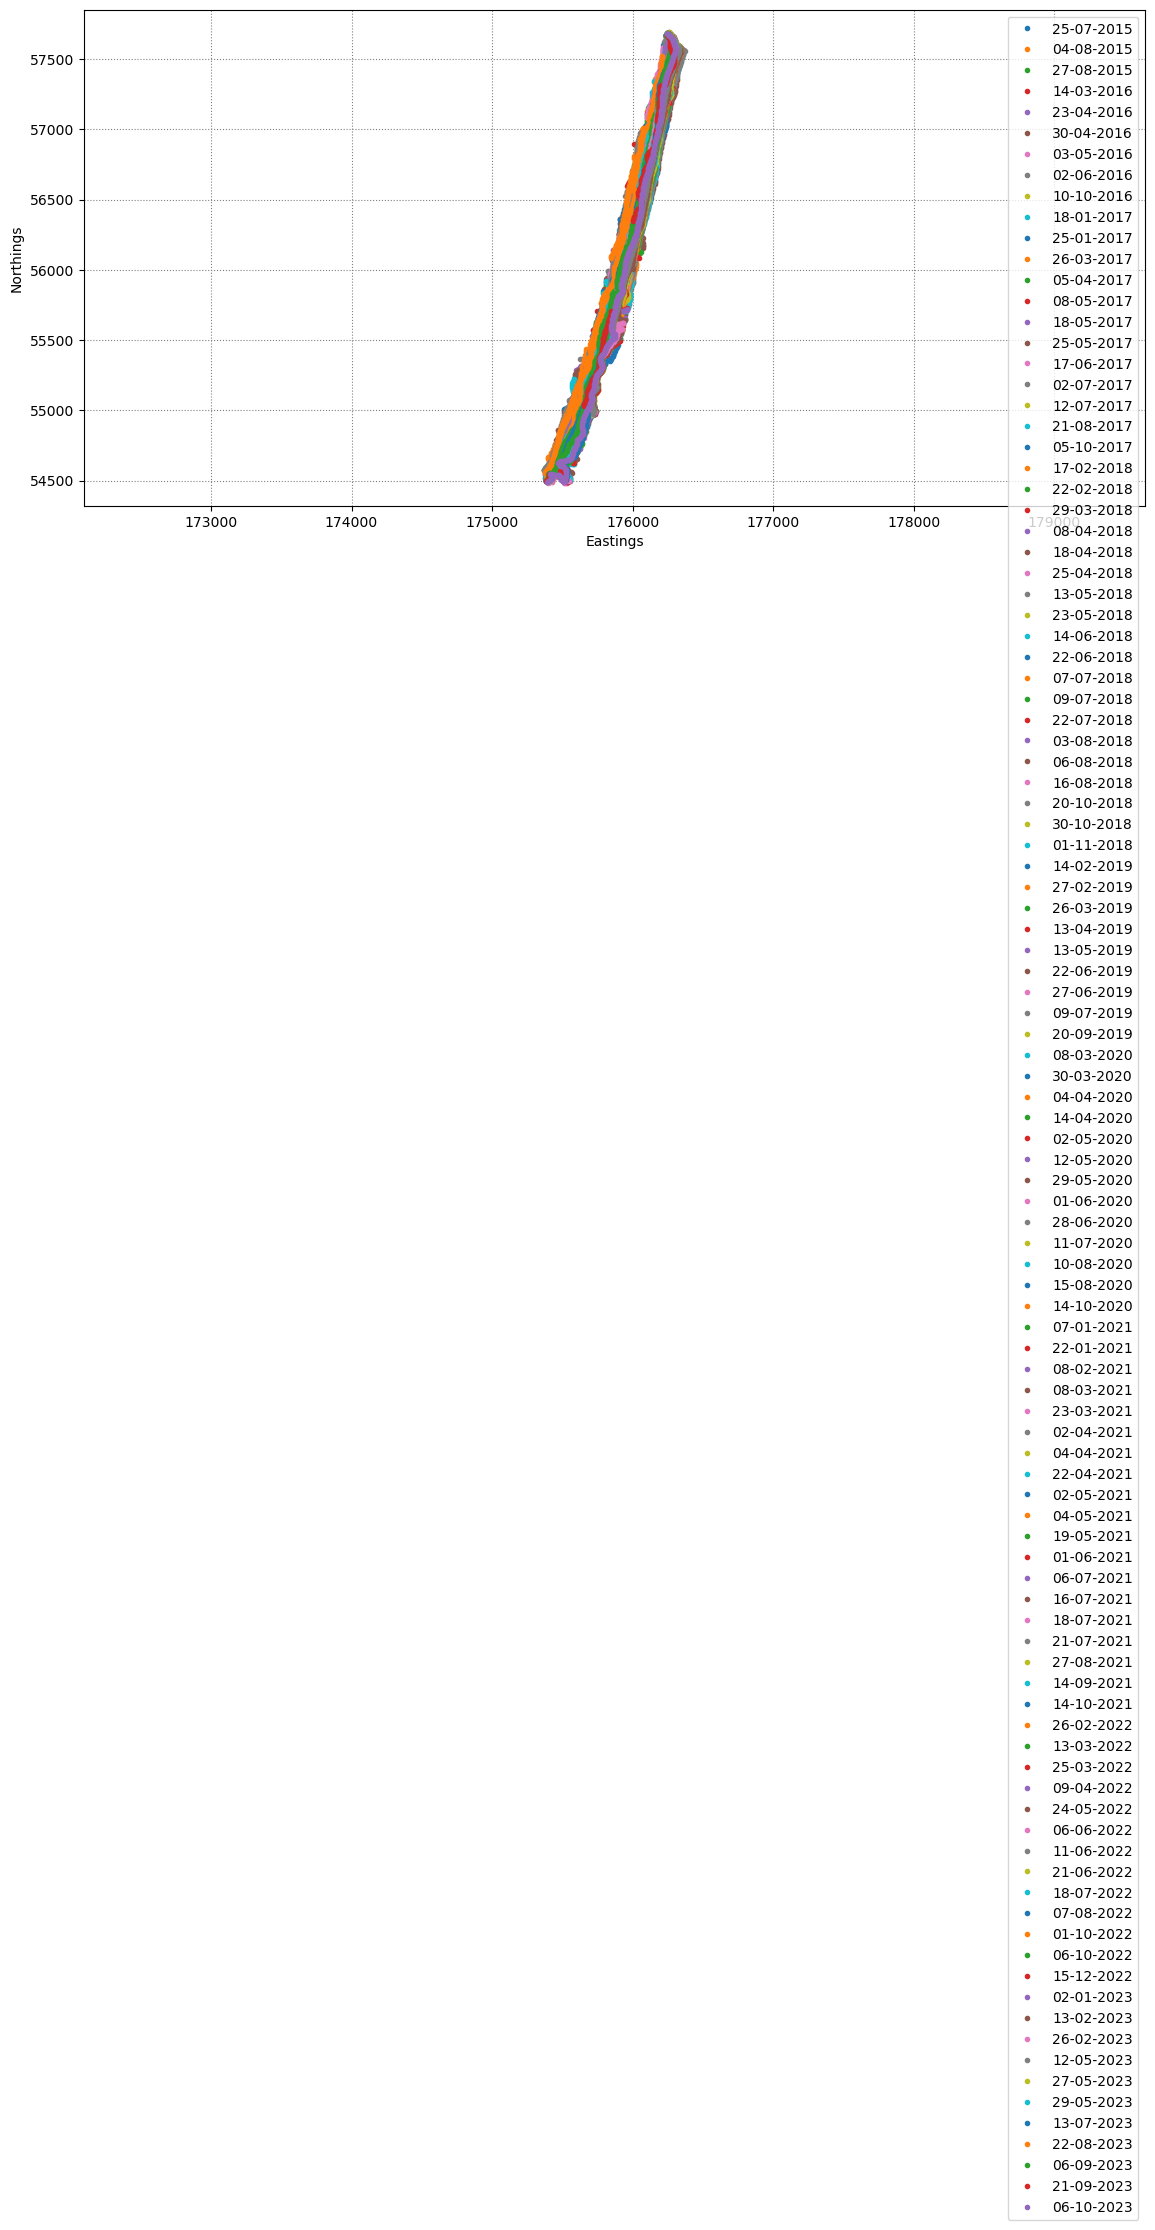

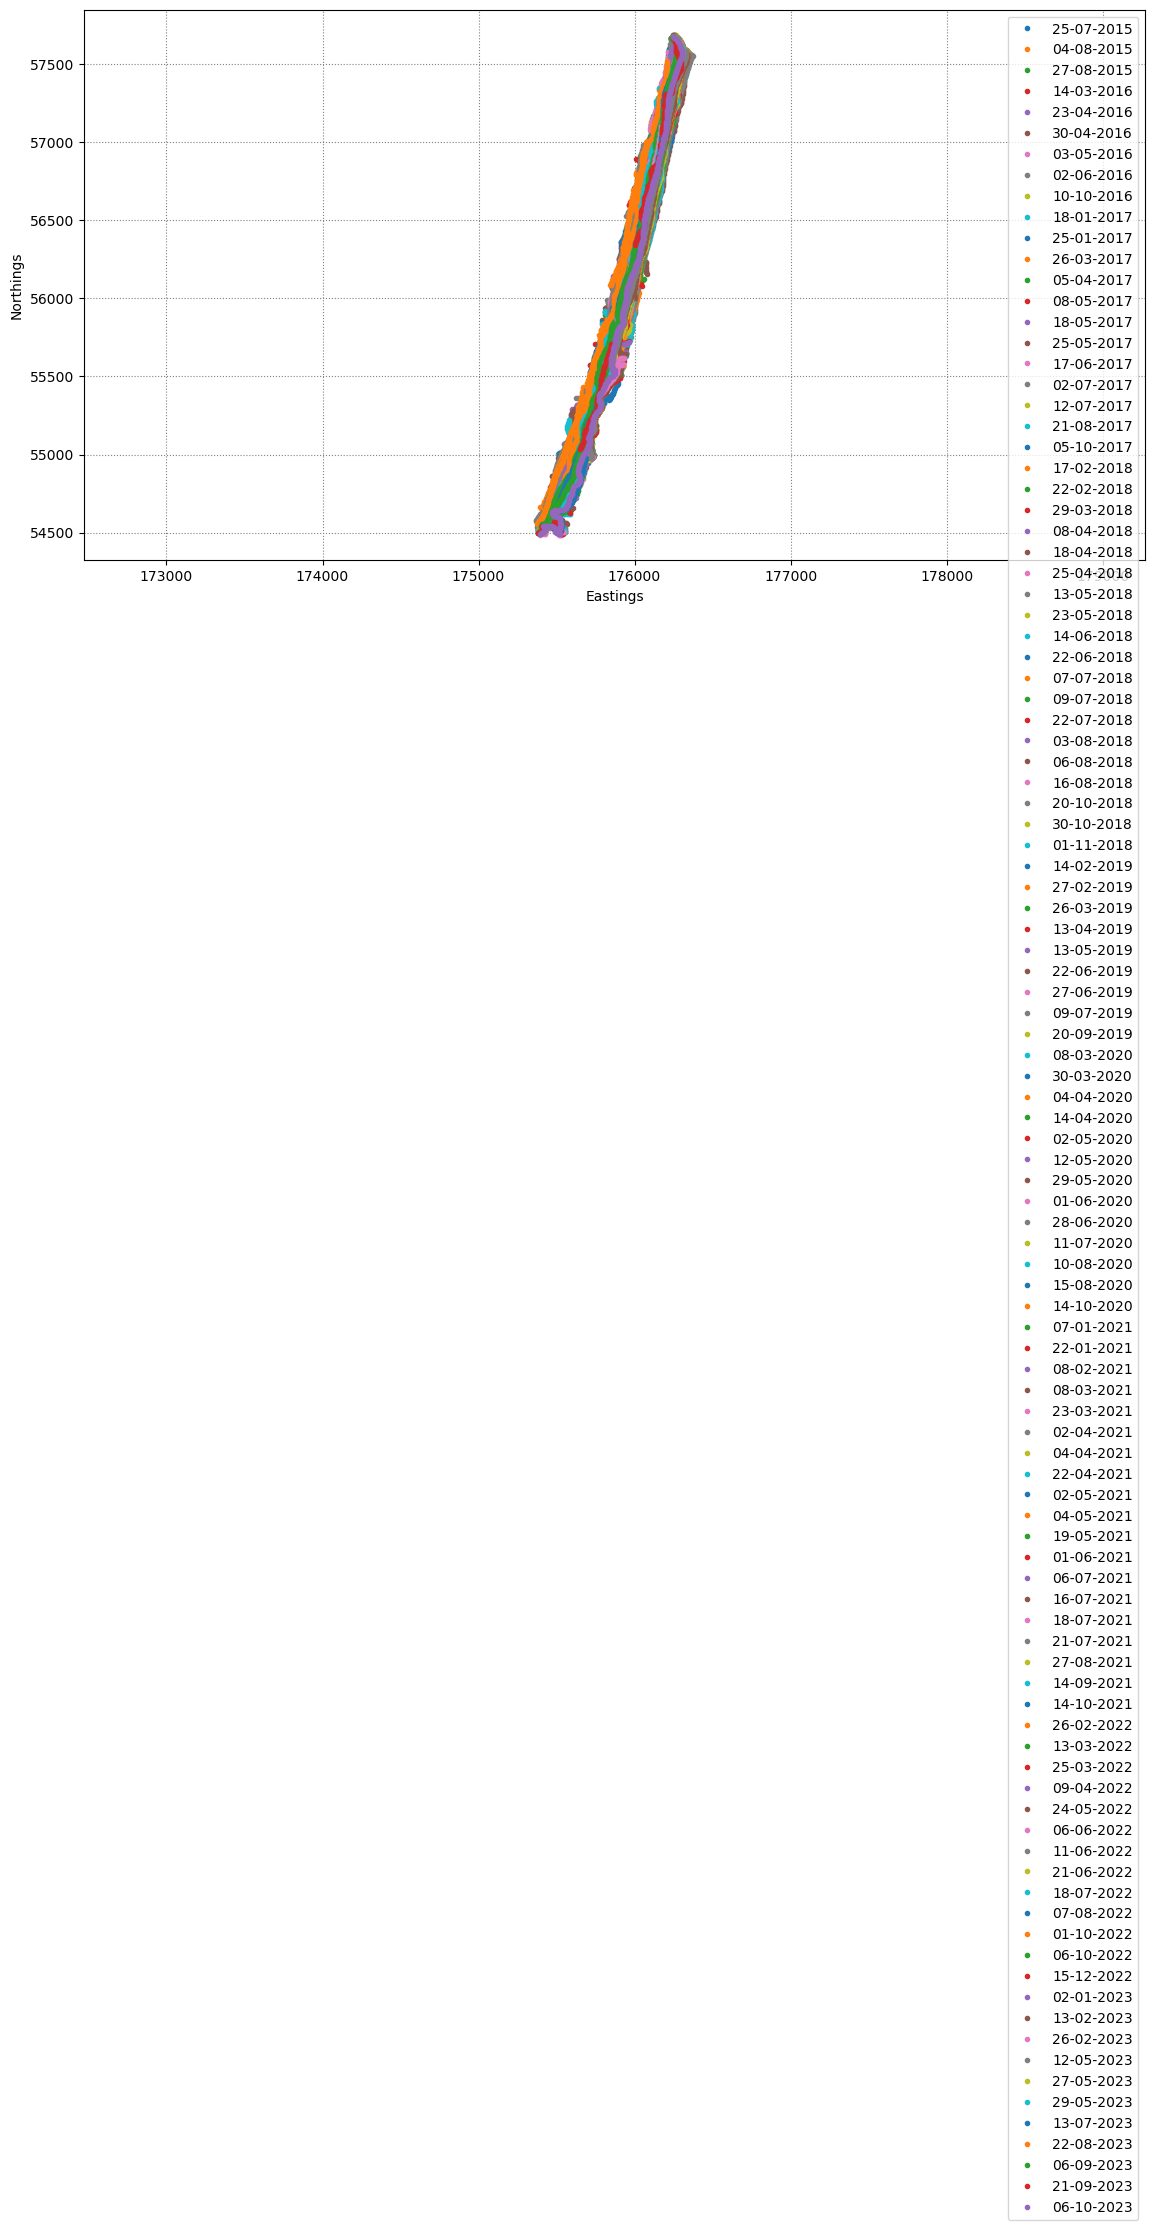

In [15]:
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend();

%matplotlib inline
plt.show()

## 3. Shoreline analysis

In this section we show how to compute time-series of cross-shore distance along user-defined shore-normal transects.

**If you have already mapped the shorelines**, just load the output file (`output.pkl`) by running the section below

In [16]:
import datetime
import json

def load_data_from_json(filepath: str) -> dict:
    """
    Reads data from a JSON file and returns it as a dictionary.

    The function reads the data from the specified JSON file using the provided filepath.
    It applies a custom object hook, `DecodeDateTime`, to decode the datetime and shoreline
    data if they exist in the dictionary.

    Args:
        filepath (str): Path to the JSON file.

    Returns:
        dict: Data read from the JSON file as a dictionary.

    """

    def DecodeDateTime(readDict):
        """
        Helper function to decode datetime and shoreline data in the dictionary.

        Args:
            readDict (dict): Dictionary to decode.

        Returns:
            dict: Decoded dictionary.

        """
        if "dates" in readDict:
            tmp = [
                datetime.datetime.fromisoformat(dates) for dates in readDict["dates"]
            ]
            readDict["dates"] = tmp
        if "shorelines" in readDict:
            tmp = [
                np.array(shoreline) if len(shoreline) > 0 else np.empty((0, 2))
                for shoreline in readDict["shorelines"]
            ]
            readDict["shorelines"] = tmp
        return readDict

    with open(filepath, "r") as fp:
        data = json.load(fp, object_hook=DecodeDateTime)
    return data



filepath = os.path.join(inputs['filepath'], sitename)
# with open(os.path.join(filepath, sitename + '_output' + '.json'), 'rb') as f:
output = load_data_from_json(os.path.join(filepath, sitename + '_output' + '.json'))
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

10 duplicates
3 bad georef


There are 3 options to define the coordinates of the shore-normal transects:

**Option 1**: the user can interactively draw the shore-normal transects along the beach by calling:

In [ ]:
#%matplotlib qt
#transects = SDS_transects.draw_transects(output, settings)

**Option 2**: the user can load the transect coordinates (make sure the coordinate reference system (CRS) is the same as defined previously in `settings['output_epsg]`) from a .geojson file by calling:

In [ ]:
#geojson_file = os.path.join(os.getcwd(), 'examples', 'sitename_transects.geojson')
#transects = SDS_tools.transects_from_geojson(geojson_file)

**Option 3**: manually provide the coordinates of the transects (in the same CRS as defined in `settings['output_epsg]` as shown in the example below:

In [36]:
transects = dict([])
transects['7a01435'] = np.array([[174325.002, 55030.997], [175376.997, 54427.999]])
transects['7a01438'] = np.array([[174325.002, 55030.997], [175765.999, 54420.002]])
transects['7a01441'] = np.array([[174352.004, 55074.004], [176489.000, 54337.995]])
transects['7a01444'] = np.array([[174424.998, 55203.997], [176689.001, 54425.000]])
transects['7a01448'] = np.array([[174525.002, 55376.998], [176805.998, 54592.002]])
transects['7a01454'] = np.array([[174669.002, 55639.003], [176985.996, 54841.001]])
transects['7a01464'] = np.array([[174936.999, 56066.001], [177376.004, 55235.998]])
transects['7a01477'] = np.array([[175091.998, 56598.998], [177778.000, 55962.000]])
transects['7a01487'] = np.array([[175197.997, 57087.998], [177865.002, 56454.999]])
transects['7a01497'] = np.array([[175302.998, 57572.999], [178262.999, 56870.000]])

Plot the location of the transects, make sure they are in the right location with the origin always landwards!

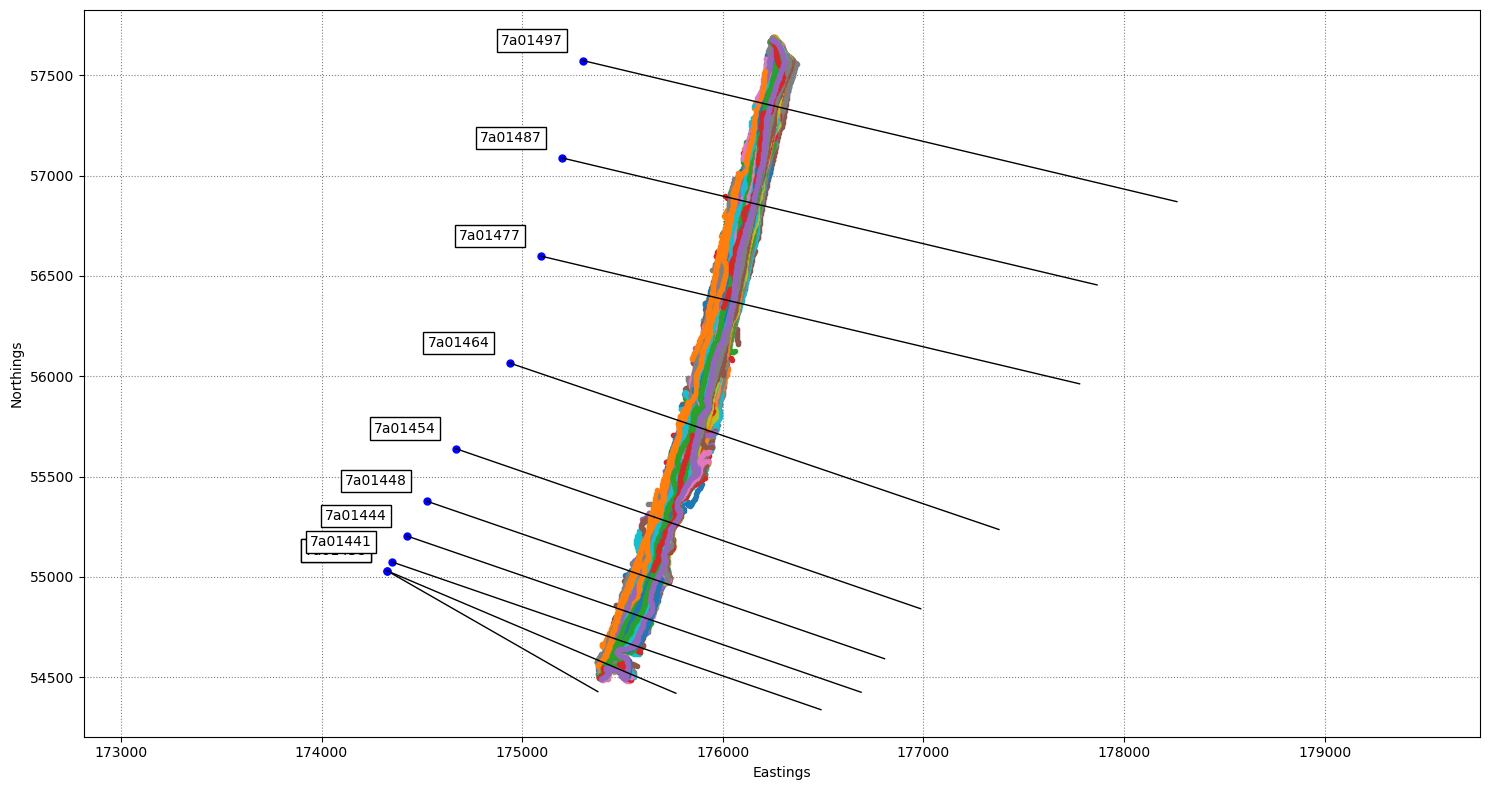

In [37]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

%matplotlib inline
plt.show()

Now, we intersect 2D shorelines with the shore-normal transects to obtain time-series of cross-shore distance along each transect.

One way is to simply compute the intersection as the median of the shoreline points within a certain range (`along_dist`).

In [38]:
# along-shore distance over which to consider shoreline points to compute the median intersection
settings_transects = {'along_dist':25}
cross_distance = SDS_transects.compute_intersection(output, transects, settings_transects) 

However, the shorelines can often be noisy (small loops, double intersections, etc), therefore a few parameters can be set to quality-control the intersections between tranects and shorelines with a more advanced function `compute_intersection_QC()`:
- `along_dist`: (in metres),
    alongshore distance to caluclate the intersection (median of points 
    within this distance). 
- `min_points`:  minimum number of shoreline points to calculate an intersection.
- `max_std`: (in metres) maximum STD for the shoreline points within the alongshore range, 
    if STD is above this value a NaN is returned for this intersection.
- `max_range`: (in metres) maximum RANGE for the shoreline points within the alongshore range, 
    if RANGE is above this value a NaN is returned for this intersection.
- `min_chainage`: (in metres) furthest distance landward of the transect origin that an intersection is 
    accepted, beyond this point a NaN is returned.
- `multiple_inter`: ('auto','nan','max') defines how to deal with multiple shoreline intersections
- `auto_prc`: (value between 0 and 1) by default 0.1, percentage of the time that a multiple intersection needs to be present to use the max in auto mode

Default parameters for the more quality-controlled intersections are provided below and should work in most cases (leave as it is if unsure).

The `multiple_inter` setting helps to deal with multiple shoreline intersections along the same transect. This is quite common, for example when there is a lagoon behind the beach and the transect crosses two water bodies. The function will try to identify this cases and the user can choose whether to:
- `'nan'`: always assign a NaN when there are multile intersections.
- `'max'`: always take the max (intersection the furtherst seaward).
- `'auto'`: let the function decide transect by transect, and if it thinks there are two water bodies, take the max.
If `'auto'` is chosen, the `auto_prc` parameter will define when to use the max, by default it is set to 0.1, which means that the function thinks there are two water bodies if 10% of the time-series show multiple intersections.

In [39]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'prc_multiple':         0.1,      # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Computing transect shoreline intersections: 100%|██████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


Plot the time-series of shoreline change along each transect

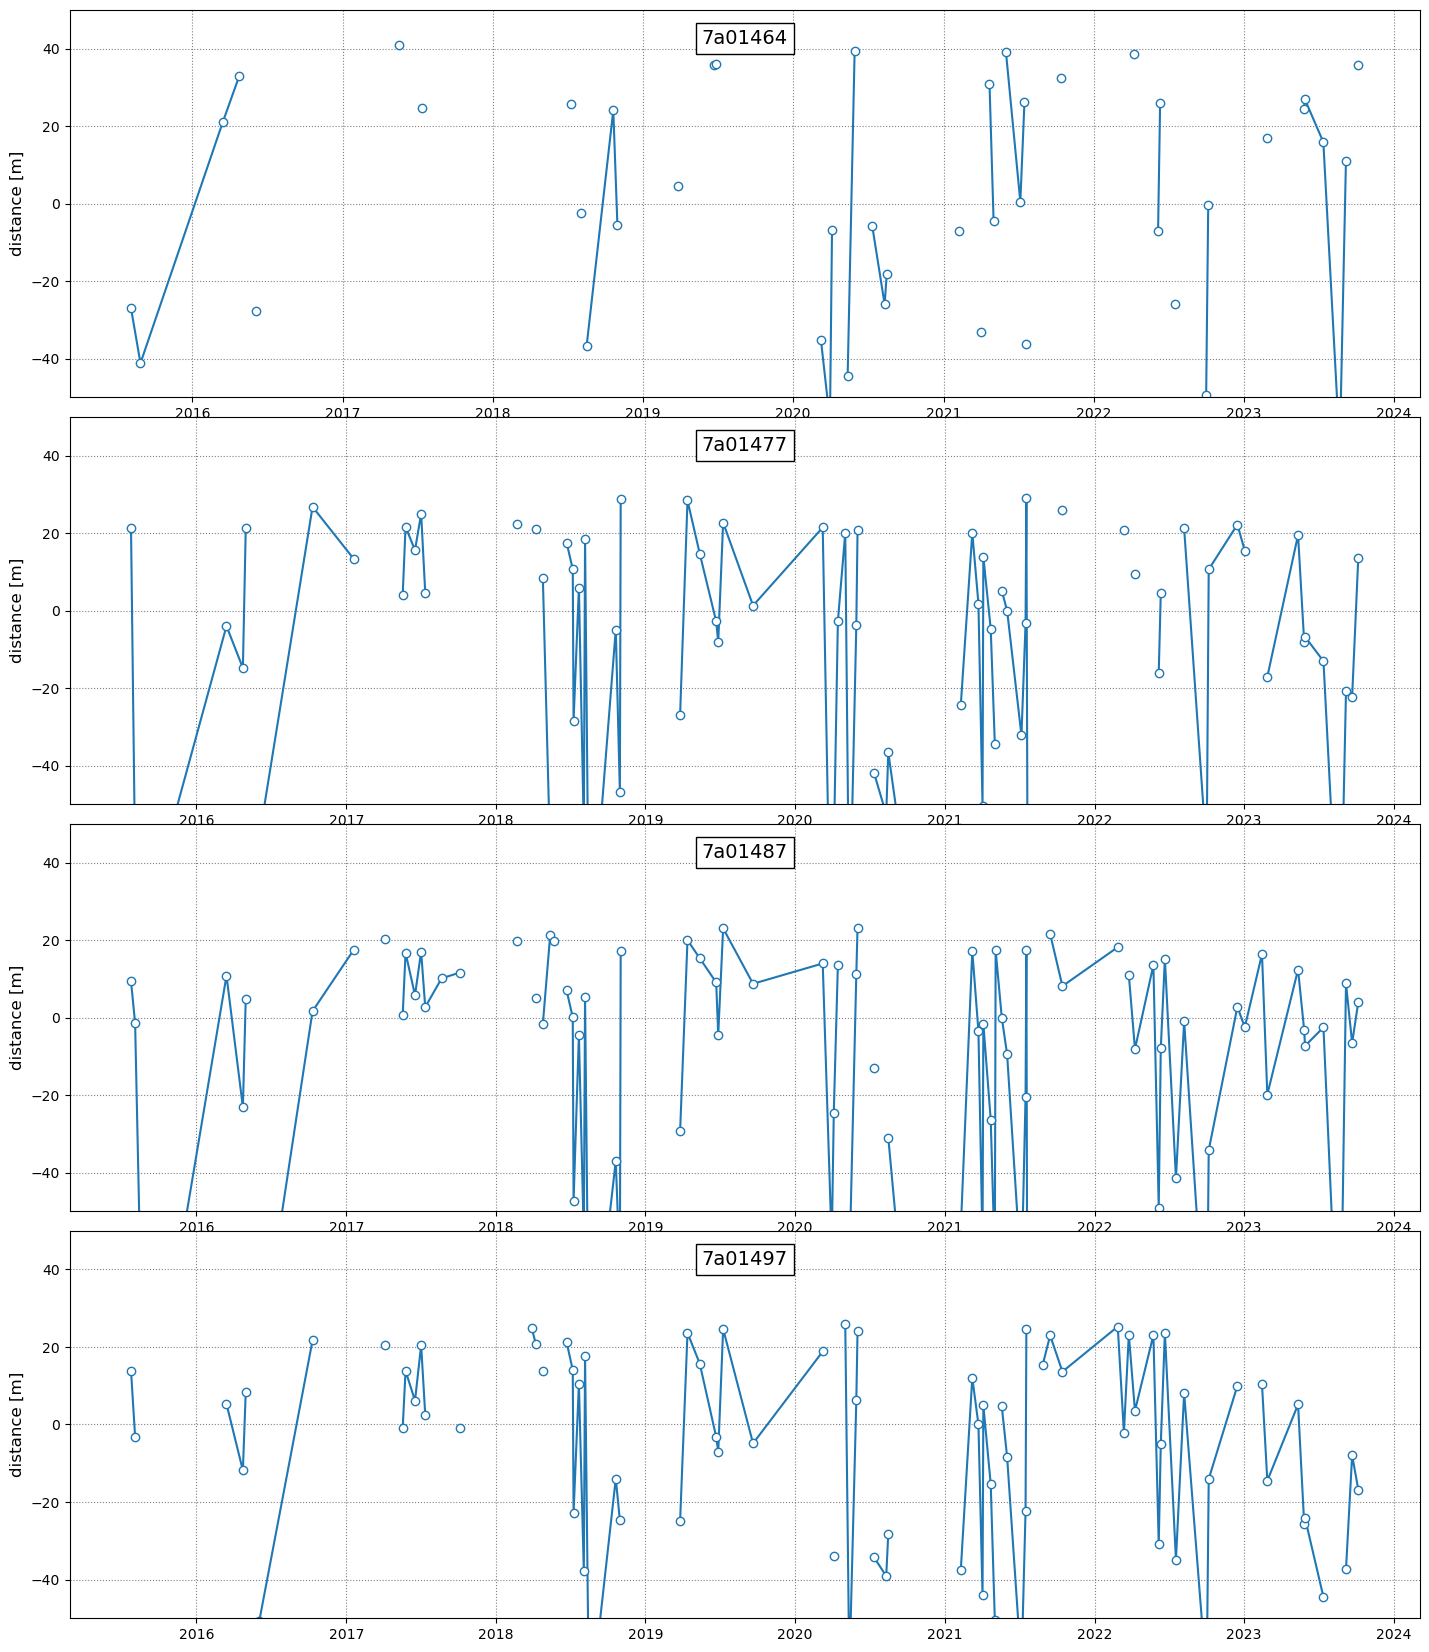

In [40]:
fig = plt.figure(figsize=[15,45], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.set_ylim([-50,50])
    ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  

%matplotlib inline
plt.show()

In [41]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
C:\Users\helen\Documents\data\PERRANPORTH\transect_time_series.csv


## 4. Tidal correction

This last section shows how to tidally-correct the time-series of shoreline change using time-series of tide level and an estimate of the beach slope.

The dates are in UTC time, as the CoastSat shorelines are also in UTC, and the datum for the water levels is approx. Mean Sea Level.

We assume that the beach slope at Perranporth is 0.200 along all transects. This was calculated in the slope notebook.

**Note**: if you don't have measured water levels and beach slope, it is possible to obtain an estimate of the beach slope and time-series of modelled tide levels at the time of image acquisition from the [FES2014](https://www.aviso.altimetry.fr/es/data/products/auxiliary-products/global-tide-fes/description-fes2014.html) global tide model by using the [CoastSat.slope](https://github.com/kvos/CoastSat.slope) repository (see [this publication](https://doi.org/10.1029/2020GL088365) for more details, open acess preprint [here](https://www.essoar.org/doi/10.1002/essoar.10502903.1)). Instructions on how to install the global tide model are available [here](https://github.com/kvos/CoastSat.slope/blob/master/doc/FES2014_installation.md).

In [42]:
#Helen Code

import subprocess

# Define the command and its arguments
command = [
    "python", "predict_tides.py",
    "-C", r"C:\Users\helen\Documents\data\PERRANPORTH\map_Perranporth_Offshore.geojson",
    "-T", r"C:\Users\helen\Documents\data\PERRANPORTH\transect_time_series.csv",
    "-M", r"C:\Users\helen\tide_model",
    "-R", r"C:\Users\helen\Documents\data\STARTBAY\tide_regions_map.geojson"
]

# Execute the command
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and error (if any)
print("Output:\n", result.stdout)
print("Error:\n", result.stderr)

Output:
 Model regions geojson file not found at the default location. Please provide the path manually.
                      dates  7a01435  ...     7a01487     7a01497
0 2015-07-25 11:25:40+00:00      NaN  ...  984.706596  987.302875
1 2015-08-04 11:25:39+00:00      NaN  ...  973.912554  970.296245
2 2015-08-27 11:36:41+00:00      NaN  ...  860.038005         NaN
3 2016-03-14 11:34:34+00:00      NaN  ...  986.175313  978.743839
4 2016-04-23 11:35:09+00:00      NaN  ...  952.229939  961.582238

[5 rows x 11 columns]
Predicting tides this may take some time....
Loading regions from GeoJSON file: C:\Users\helen\Documents\data\STARTBAY\tide_regions_map.geojson
Modeling tides for all points
Loading the tide model from: C:\Users\helen\tide_model\region4
Tide predictions saved to C:\Users\helen\Documents\tidal_predictions.csv

Error:
 


In [43]:
#Instructions provided by Sharon to create tidal_predictions.csv
#python predict_tides.py -C "C:\Users\helen\Documents\data\STARTBAY\map_StartBay_Offshore.geojson" -T "C:\Users\helen\Documents\data\STARTBAY\transect_time_series.csv"  -M "C:\Users\helen\tide_model" -R "C:\Users\helen\Documents\data\STARTBAY\tide_regions_map.geojson"
#Amended code above as this would not process in Jupyter notebook. 

Extracting closest points: 100%
The default method of getting the closest datapoint failed. Trying the second method


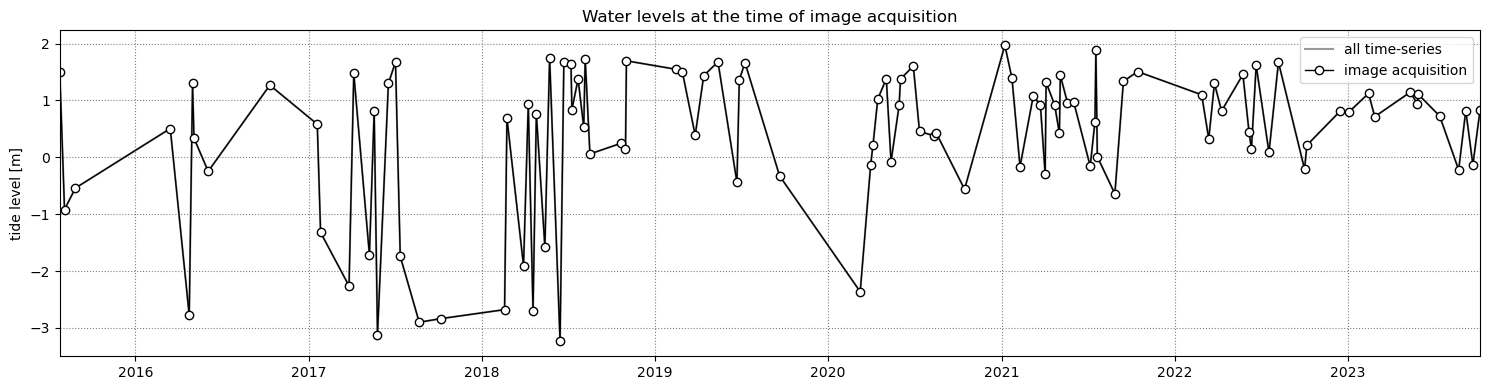

In [44]:
# load the measured tide data
# filepath = os.path.join(os.getcwd(),'examples','sitename_tides.csv')
filepath = r'C:\Users\helen\Documents\tidal_predictions.csv'
# filepath = r"C:\development\doodleverse\coastseg\CoastSeg\scripts\tidal_predictions_2_points.csv"
tide_data = pd.read_csv(filepath)
dates_ts = [pd.to_datetime(_).to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tide'])

# get tide levels corresponding to the time of image acquisition
dates_sat = output['dates']
try:
    tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)
except Exception as e:
    print("\nThe default method of getting the closest datapoint failed. Trying the second method")
    tides_sat = SDS_tools.get_nearest_datapoint(dates_sat, dates_ts, tides_ts)
    
  
# plot the subsampled tide data
fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(dates_ts, tides_ts, '-', color='0.6', label='all time-series')
ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='Water levels at the time of image acquisition');
ax.legend();

%matplotlib inline
plt.show()

Apply tidal correction using a linear slope and a reference elevation to which project all the time-series of cross-shore change (to get time-series at Mean Sea Level, set `reference_elevation` to 0. You also need an estimate of the beach slope. 

Tidally-corrected time-series of the shoreline change along the transects saved as:
C:\Users\helen\Documents\data\PERRANPORTH\transect_time_series_tidally_corrected.csv


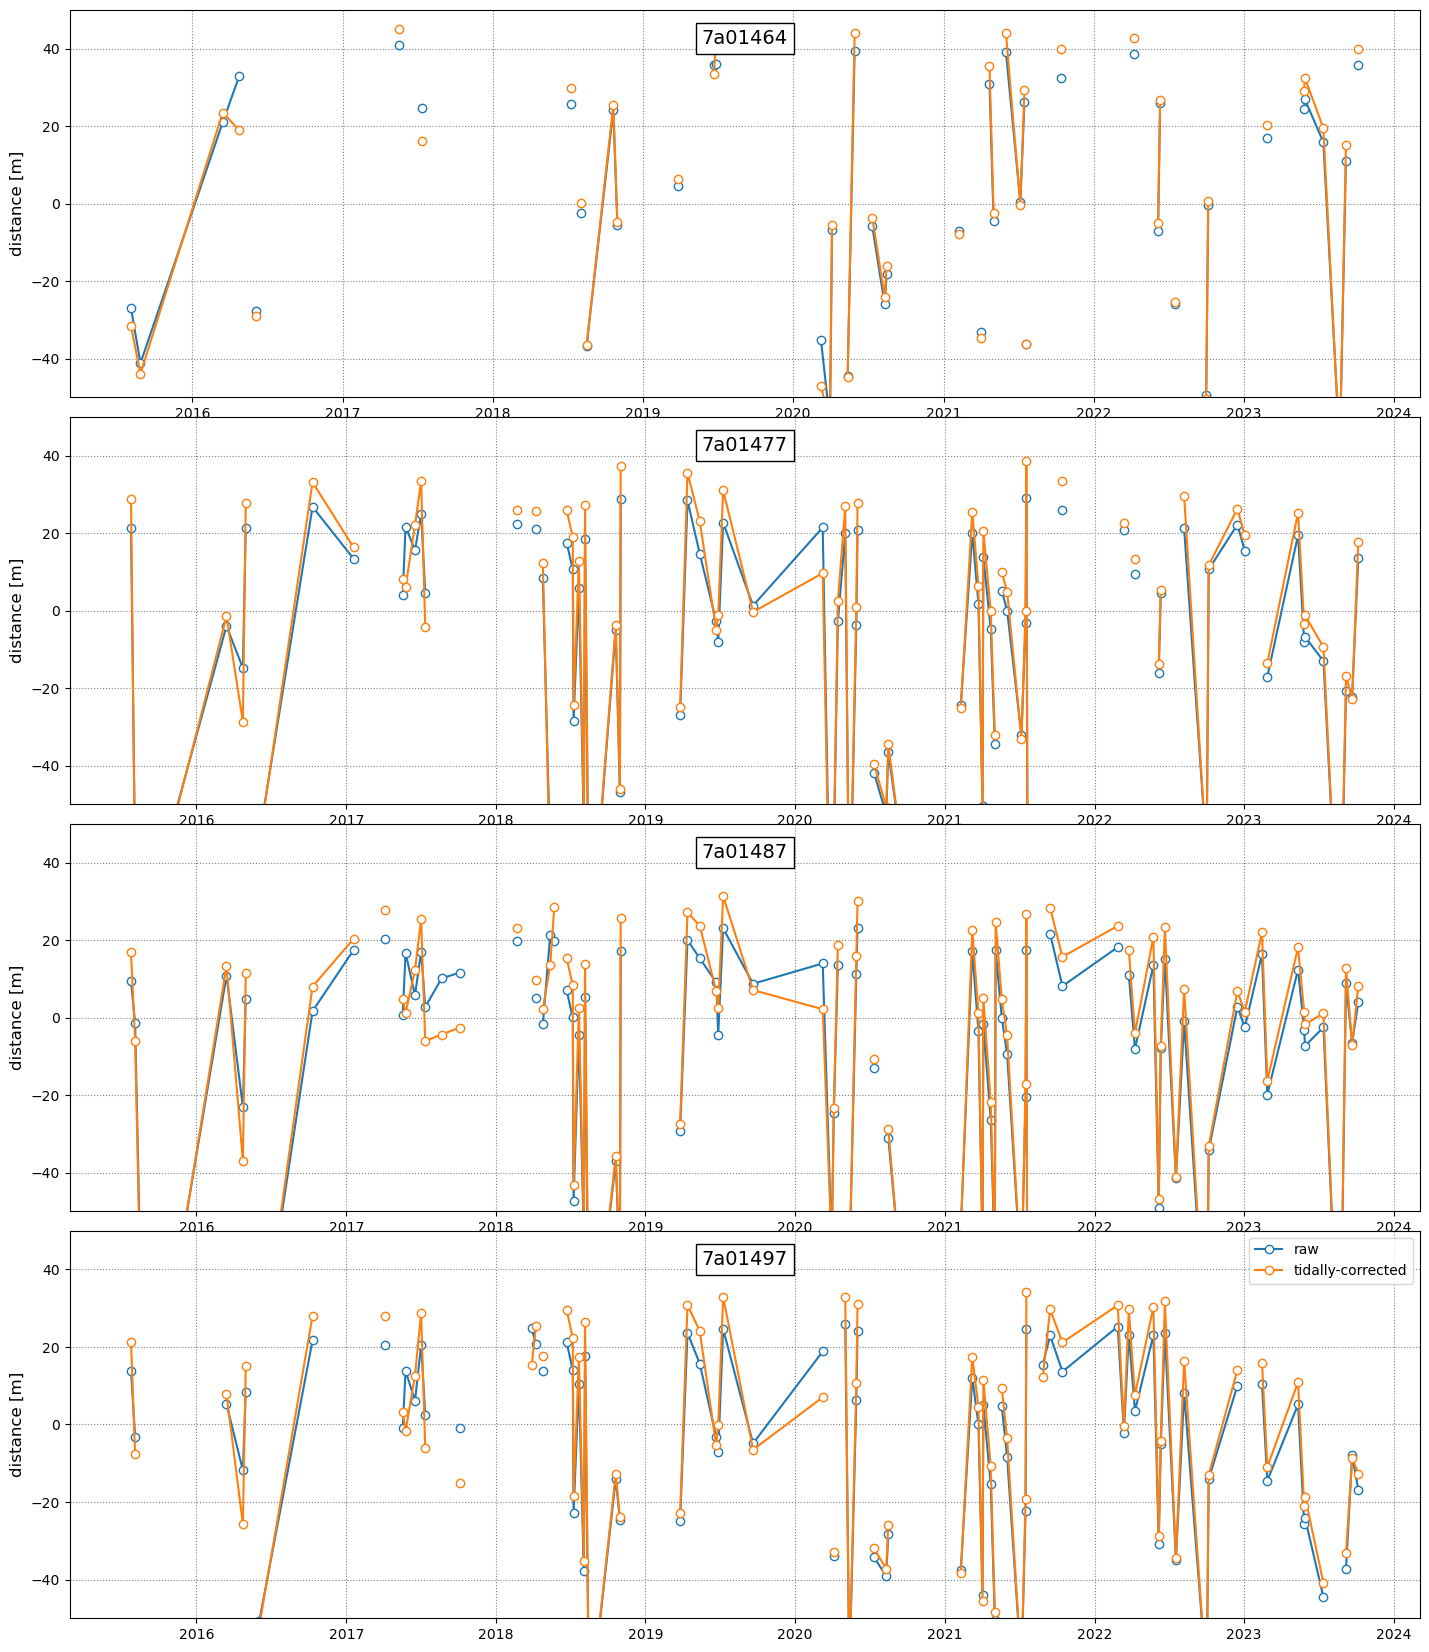

In [45]:
# tidal correction along each transect
reference_elevation = 0 # elevation at which you would like the shoreline time-series to be
beach_slope = 0.200 #From the beach slope notebook
cross_distance_tidally_corrected = {}
for key in cross_distance.keys():
    correction = (tides_sat-reference_elevation)/beach_slope
    cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    
# store the tidally-corrected time-series in a .csv file
out_dict = dict([])
out_dict['dates'] = dates_sat
for key in cross_distance_tidally_corrected.keys():
    out_dict[key] = cross_distance_tidally_corrected[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series_tidally_corrected.csv')
df.to_csv(fn, sep=',')
print('Tidally-corrected time-series of the shoreline change along the transects saved as:\n%s'%fn)

# plot the time-series of shoreline change (both raw and tidally-corrected)
fig = plt.figure(figsize=[15,45], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.set_ylim([-50,50])
    ax.plot(output['dates'], cross_distance[key]- np.nanmedian(cross_distance[key]), '-o', ms=6, mfc='w', label='raw')
    ax.plot(output['dates'], cross_distance_tidally_corrected[key]- np.nanmedian(cross_distance[key]), '-o', ms=6, mfc='w', label='tidally-corrected')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
ax.legend();

%matplotlib inline
plt.show()

## 5. Time-series post-processing

Finally, we can post-process the time-series of shoreline change to remove obvious outliers and spikes in the data and average the time-series over different time-frames (seasonally or monthly).

To demonstrate these functionalities, we load a full time-series of shoreline change at Perranporth from Landsat imagery between 1999 and 2023. These shorelines were mapped automatically without manual quality control, intersected with the transects and tidally-corrected.

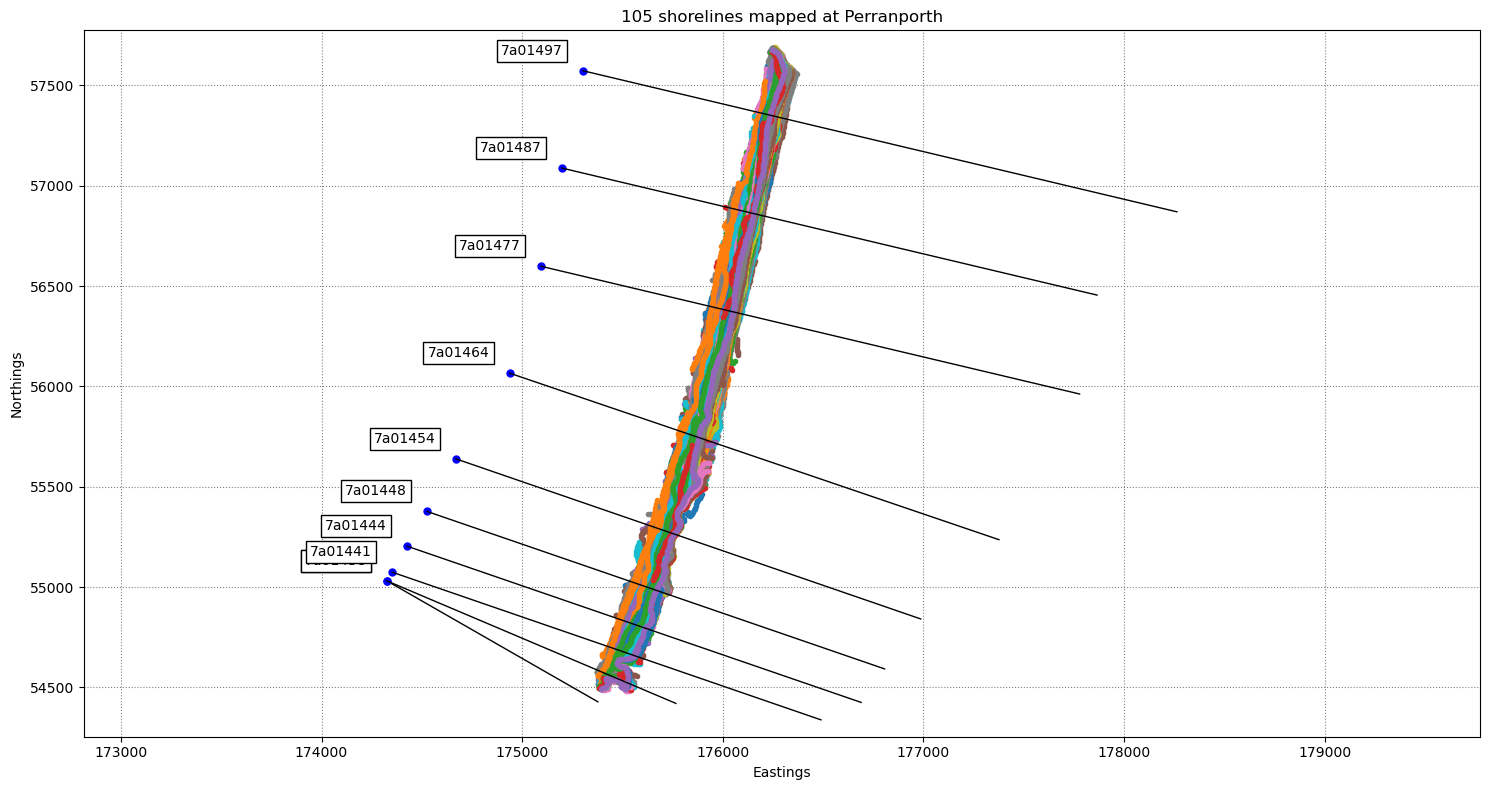

In [46]:
# load mapped shorelines from 1984
filename_output = os.path.join(os.getcwd(),'data\\PERRANPORTH','perranporth_output.pkl')
with open(filename_output, 'rb') as f:
    output = pickle.load(f) 

# plot the mapped shorelines
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
plt.title('%d shorelines mapped at Perranporth'%len(output['shorelines']))
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
             va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

# load long time-series (1984-2021)
filepath = os.path.join(os.getcwd(),'data\\PERRANPORTH','transect_time_series_tidally_corrected.csv')
df = pd.read_csv(filepath, parse_dates=['dates'])
dates = [_.to_pydatetime() for _ in df['dates']]
cross_distance = dict([])
for key in transects.keys():
    cross_distance[key] = np.array(df[key])

plt.show()

#### 5.1 Despiking the time-series

The tidally-corrected time-series of shoreline change obtained with the steps above may still contain some outliers (from cloud shadows, false detections etc). The function `SDS_transects.reject_outliers()` was developed to remove obvious outliers in the time-series, by removing the points that do not make physical sense in a shoreline change setting. 

For example, the shoreline can experience rapid erosion after a large storm, but it will then take time to recover and return to its previous state. Therefore, if the shoreline erodes/accretes suddenly of a significant amount (`max_cross_change`) and then immediately returns to its previous state, this spike does not make any physical sense and can be considered an outlier. Additionally, this funciton also checks that the Otsu thresholds used to map the shoreline are within the typical range defined by `otsu_threshold`, with values outside this range identified as outliers.

7a01464  - outliers removed: 15
7a01477  - outliers removed: 23
*7a01487  - outliers removed: 30
7a01497  - outliers removed: 18


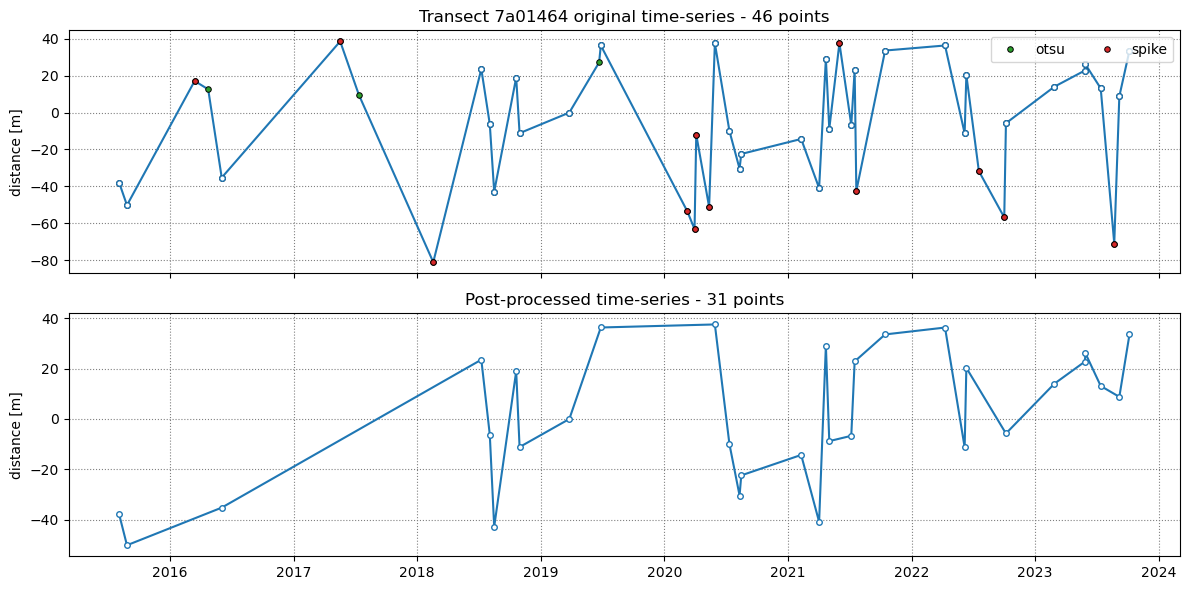

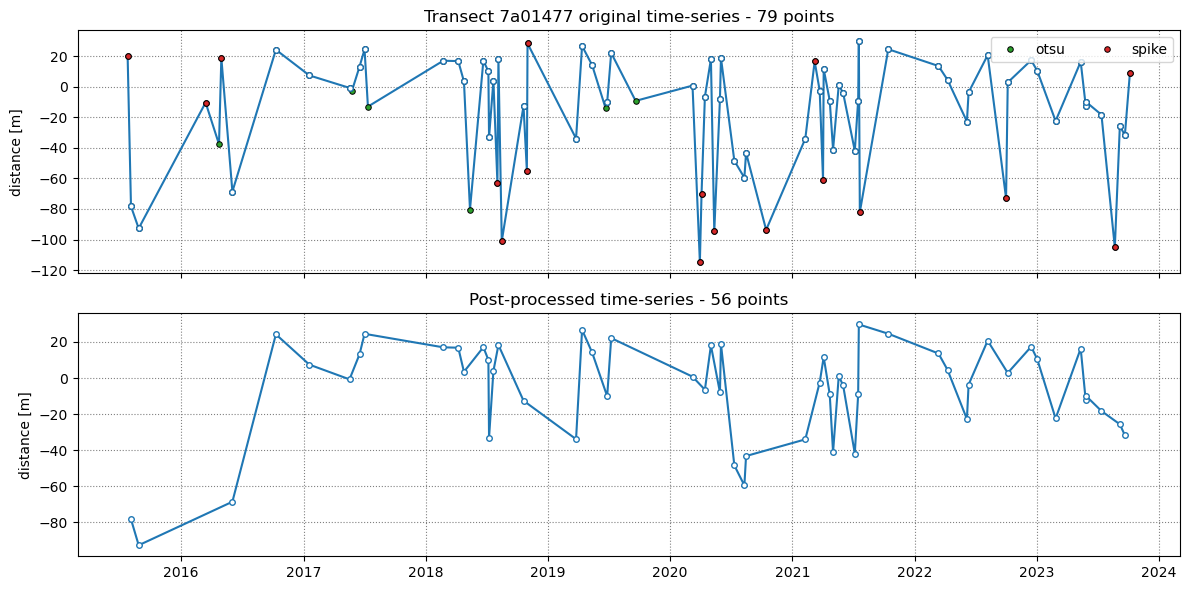

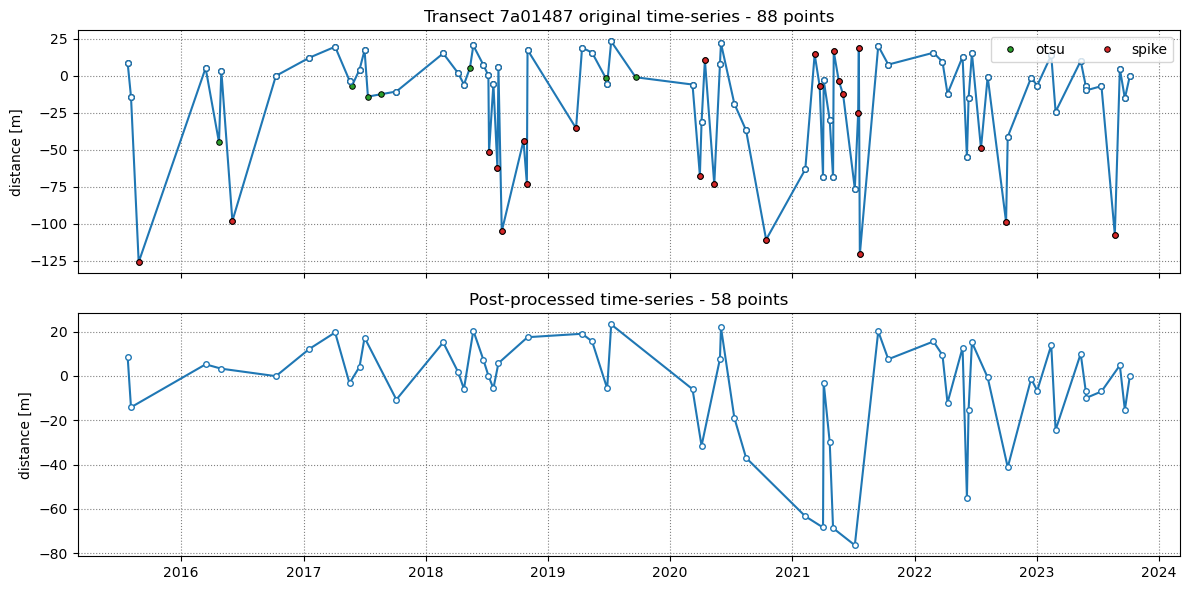

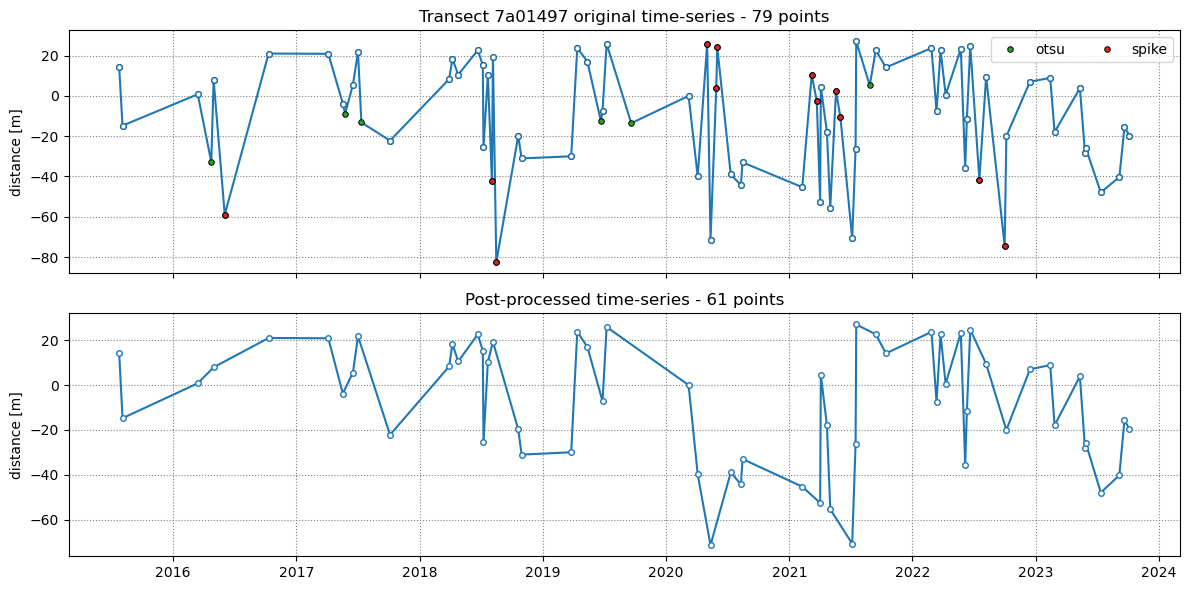

In [47]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

%matplotlib inline
plt.show()

We can also plot the Otsu threholds for the shorelines mapped at this site to see if there are any obvious outliers and adjust the values of `otsu_threshold`.

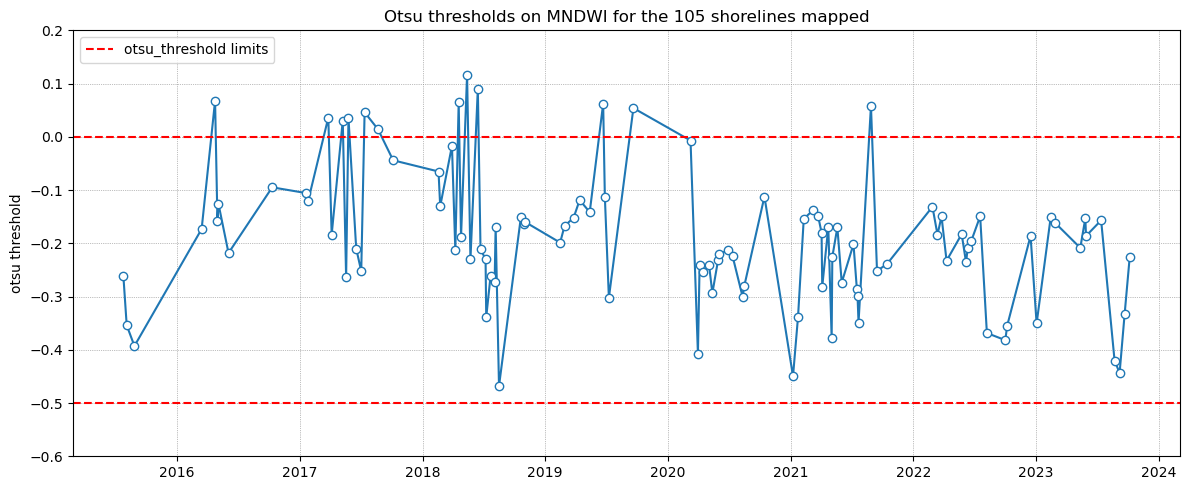

In [48]:
# plot Otsu thresholds for the mapped shorelines
fig,ax = plt.subplots(1,1,figsize=[12,5],tight_layout=True)
ax.grid(which='major',ls=':',lw=0.5,c='0.5')
ax.plot(output['dates'],output['MNDWI_threshold'],'o-',mfc='w')
ax.axhline(y=-0.5,ls='--',c='r',label='otsu_threshold limits')
ax.axhline(y=0,ls='--',c='r')
ax.set(title='Otsu thresholds on MNDWI for the %d shorelines mapped'%len(output['shorelines']),
       ylim=[-0.6,0.2],ylabel='otsu threshold')
ax.legend(loc='upper left')
fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'otsu_threhsolds.jpg'))

%matplotlib inline
plt.show()

#### 5.2 Seasonal averaging

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.seasonal_average()` and plot them. 

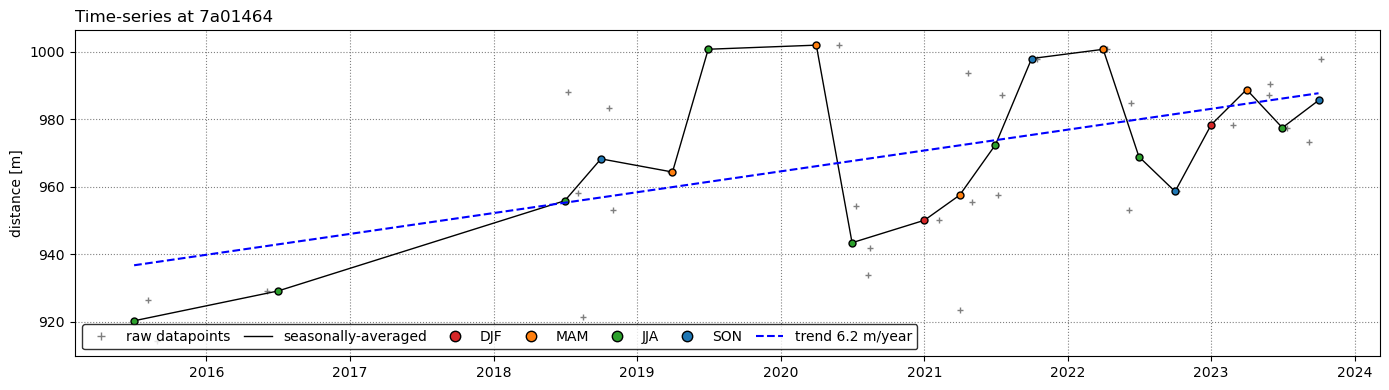

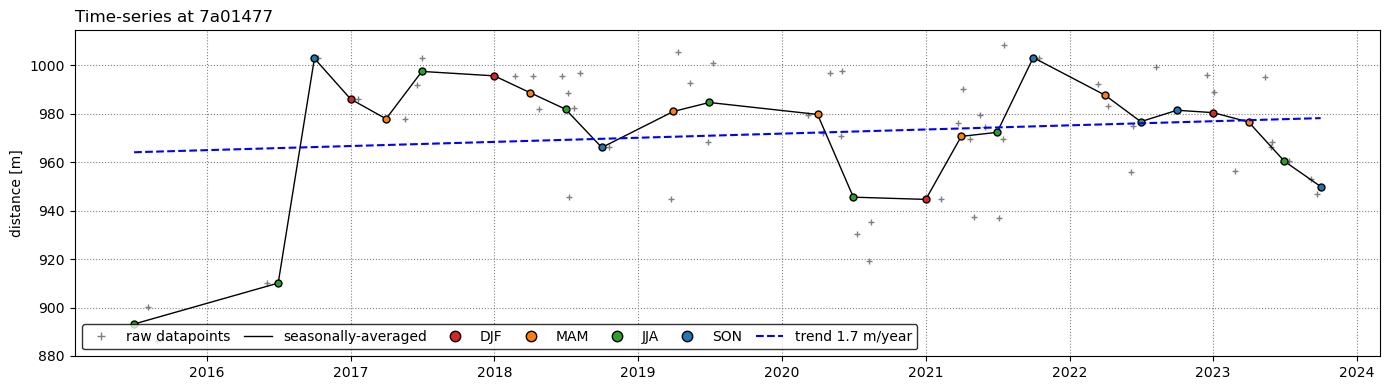

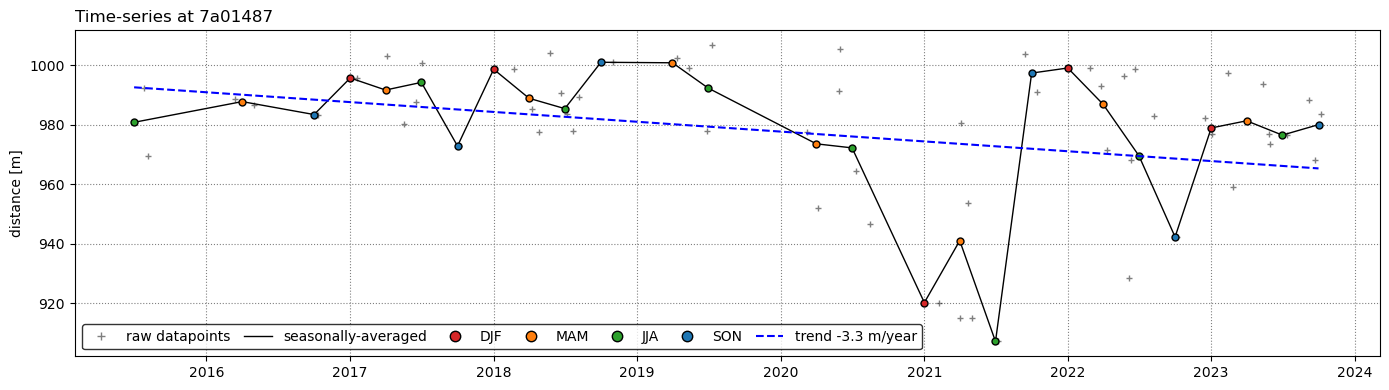

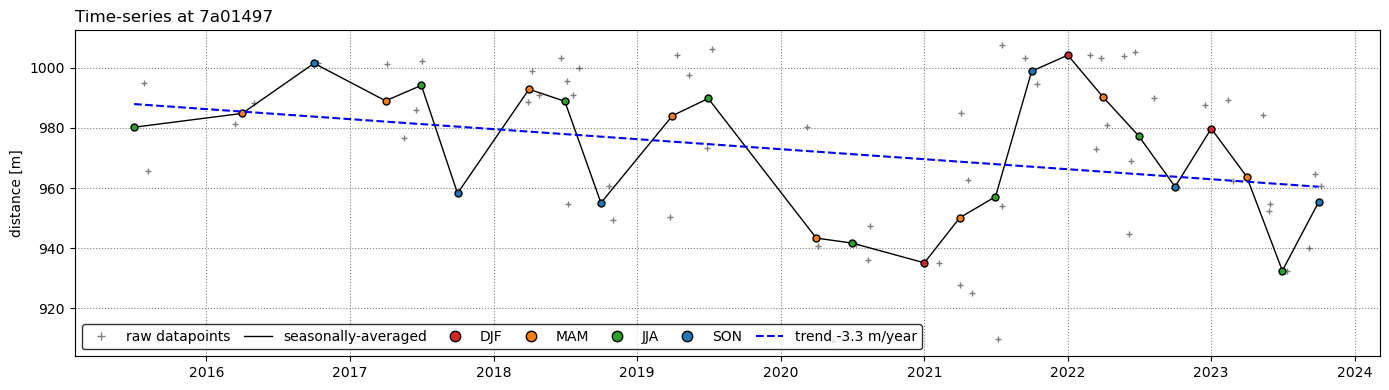

In [49]:
season_colors = {'DJF':'C3', 'MAM':'C1', 'JJA':'C2', 'SON':'C0'}
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline seasonal averages (DJF, MAM, JJA, SON)
    dict_seas, dates_seas, chainage_seas, list_seas = SDS_transects.seasonal_average(dates_nonan, chainage)
    
    # calculate long-term trend
    trend, y =  SDS_transects.calculate_trend(dates_seas, chainage_seas)
    
    # plot seasonal averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_seas, chainage_seas, '-', lw=1, color='k', mfc='w', ms=4, label='seasonally-averaged')
    for k,seas in enumerate(dict_seas.keys()):
        ax.plot(dict_seas[seas]['dates'], dict_seas[seas]['chainages'],
                 'o', mec='k', color=season_colors[seas], label=seas,ms=5)
    ax.plot(dates_seas,y,'--',color='b', label='trend %.1f m/year'%trend)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)

%matplotlib inline
plt.show()

#### 5.3 Monthly averaging

The cell below shows how to calculate seasonal averages on the time-series with `SDS_transects.monthly_average()` and plot them.

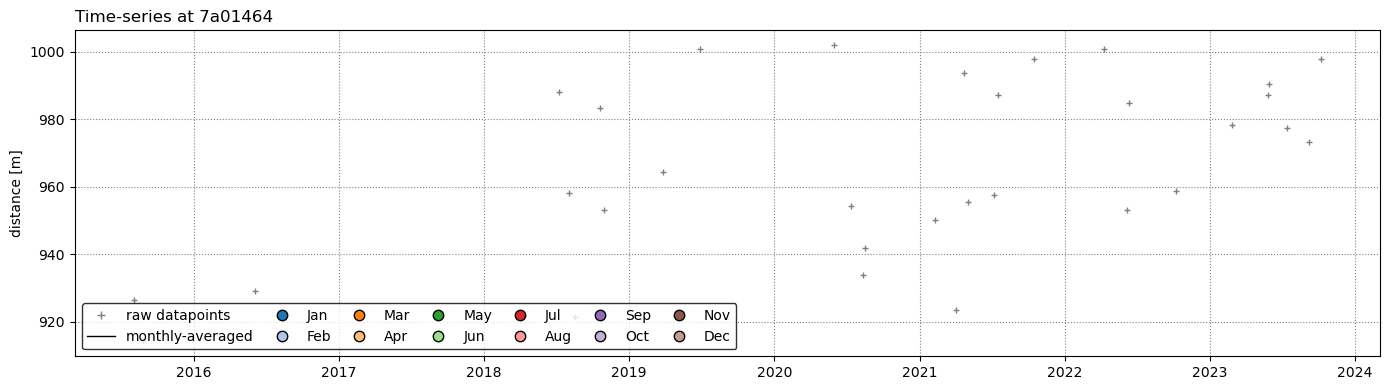

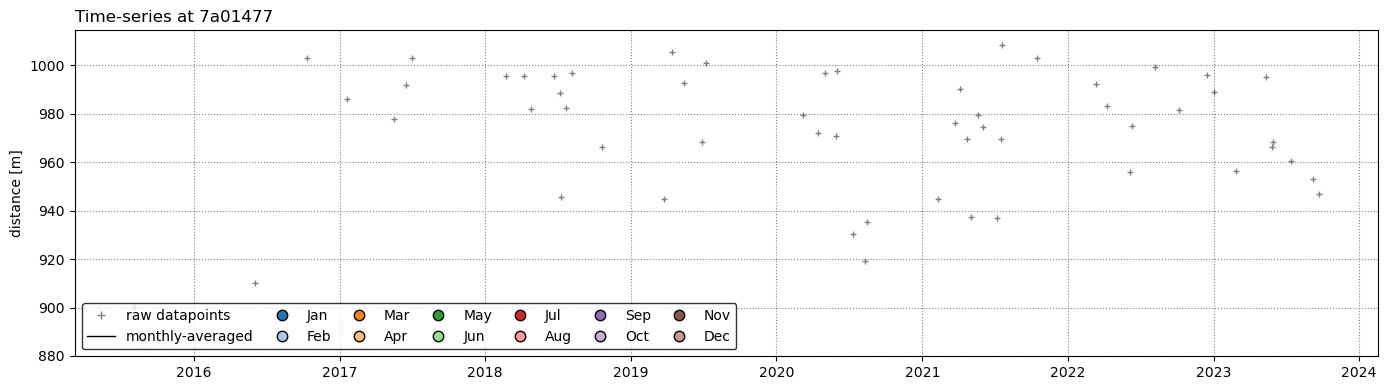

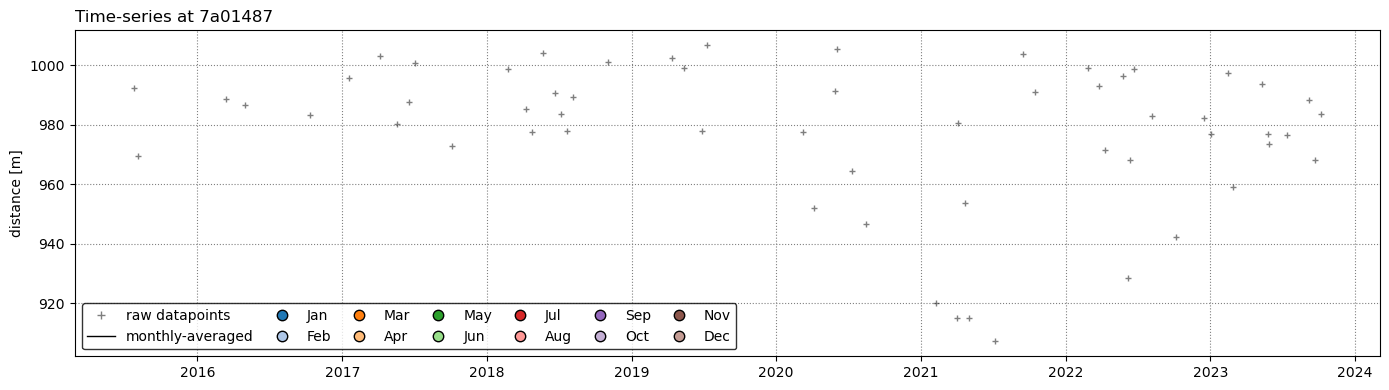

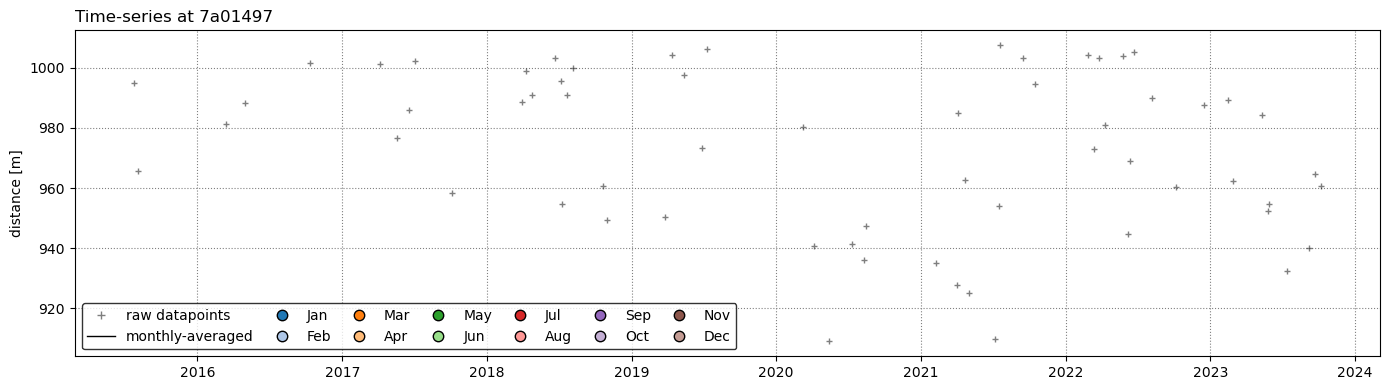

In [50]:
month_colors = plt.cm.get_cmap('tab20')
for key in cross_distance.keys():
    chainage = cross_distance[key]
    # remove nans
    idx_nan = np.isnan(chainage)
    dates_nonan = [dates[_] for _ in np.where(~idx_nan)[0]]
    chainage = chainage[~idx_nan] 
    
    # compute shoreline monthly averages
    dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)
    
    # plot monthly averages
    fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.set_title('Time-series at %s'%key, x=0, ha='left')
    ax.set(ylabel='distance [m]')
    ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
    ax.plot(dates_month, chainage_month, '-', lw=1, color='k', mfc='w', ms=4, label='monthly-averaged')
    for k,month in enumerate(dict_month.keys()):
        ax.plot(dict_month[month]['dates'], dict_month[month]['chainages'],
                 'o', mec='k', color=month_colors(k), label=month,ms=5)
    ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)

%matplotlib inline
plt.show()

## 6. Validation against surveys

This section provides a validation of the satellite-derived shorelines at Perranporth against the survey data, available at https://coastalmonitoring.org/cco/.

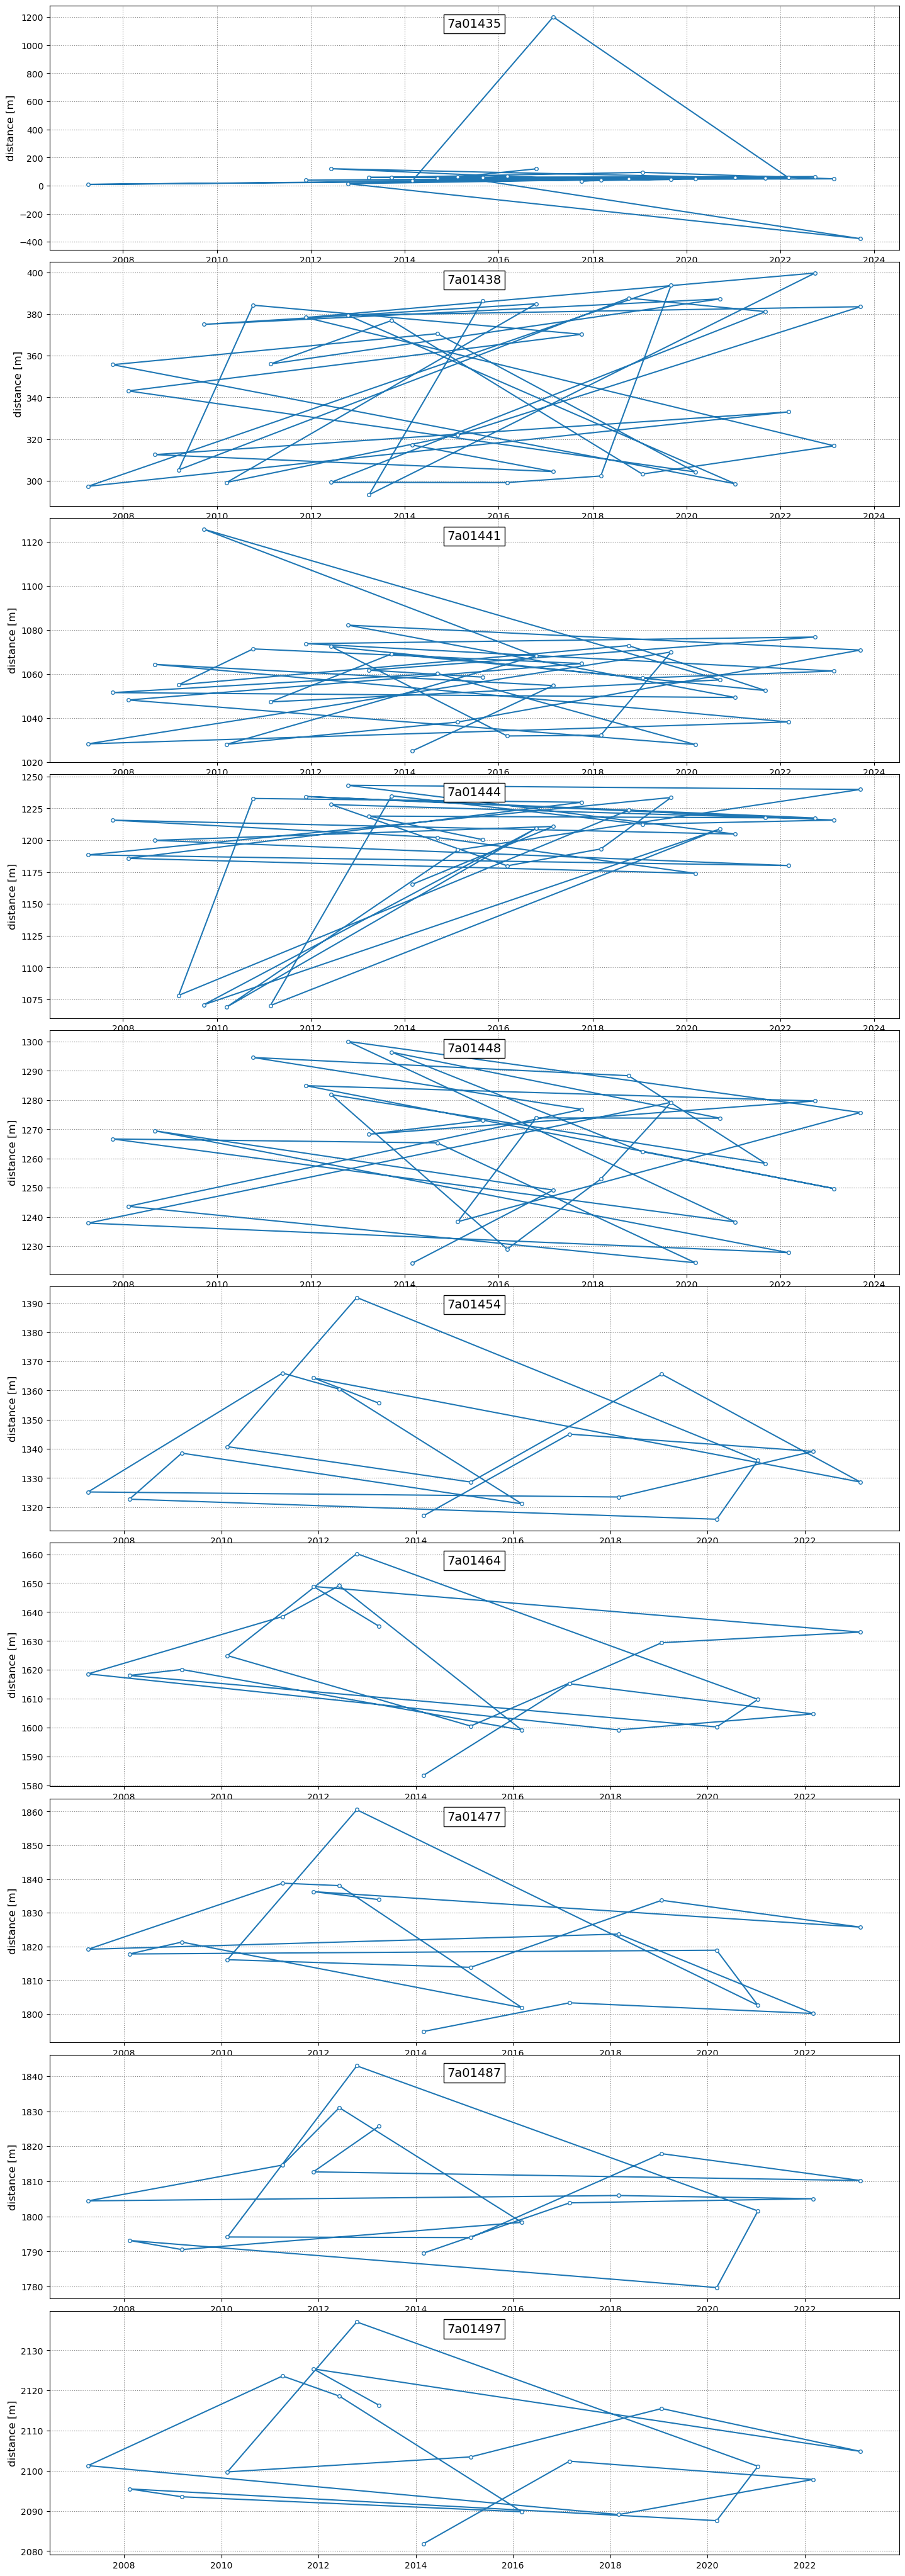

In [51]:
#Helen Amended Code

from scipy import interpolate
from datetime import datetime
import pytz

# Ensure inline plotting
%matplotlib inline

# read the csv file
fp_datasets = os.path.join(os.getcwd(), 'CCO', 'Perranporth', 'Perranporth_Profiles.csv')
df = pd.read_csv(fp_datasets)
pf_names = list(np.unique(df['Profile ID']))

# select contour level
contour_level = 0.7

# initialise topo_profiles structure
topo_profiles = dict()
for i in range(len(pf_names)):
    # read dates
    df_pf = df.loc[df['Profile ID'] == pf_names[i]]
    dates_str = df_pf['Date']
    dates_unique = np.unique(dates_str)
    # loop through dates
    topo_profiles[pf_names[i]] = {'dates': [], 'chainages': []}
    for date in dates_unique:
        # extract chainage and elevation for that date
        df_date = df_pf.loc[dates_str == date]
        chainages = np.array(df_date['Chainage'])
        elevations = np.array(df_date['Elevation'])
        if len(chainages) == 0: continue
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations, chainages, bounds_error=False, fill_value='extrapolate')
        chainage_contour_level = f(contour_level)
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        date_utc = pytz.utc.localize(datetime.strptime(date, '%d/%m/%Y'))
        topo_profiles[pf_names[i]]['dates'].append(date_utc)

# plot time-series
fig = plt.figure(figsize=[15, 45], tight_layout=True)
gs = gridspec.GridSpec(len(topo_profiles), 1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i, key in enumerate(topo_profiles.keys()):
    ax = fig.add_subplot(gs[i, 0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5, 0.95, key, bbox=dict(boxstyle="square", ec='k', fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)

# Show the plot
plt.show()

# save a .pkl file
with open(os.path.join(os.getcwd(), 'data', 'PERRANPORTH', 'Perranporth_ts_07m.pkl'), 'wb') as f:
    pickle.dump(topo_profiles, f)

Now compare the surveys to the satellite-derived shorelines from 1984 loaded previously.

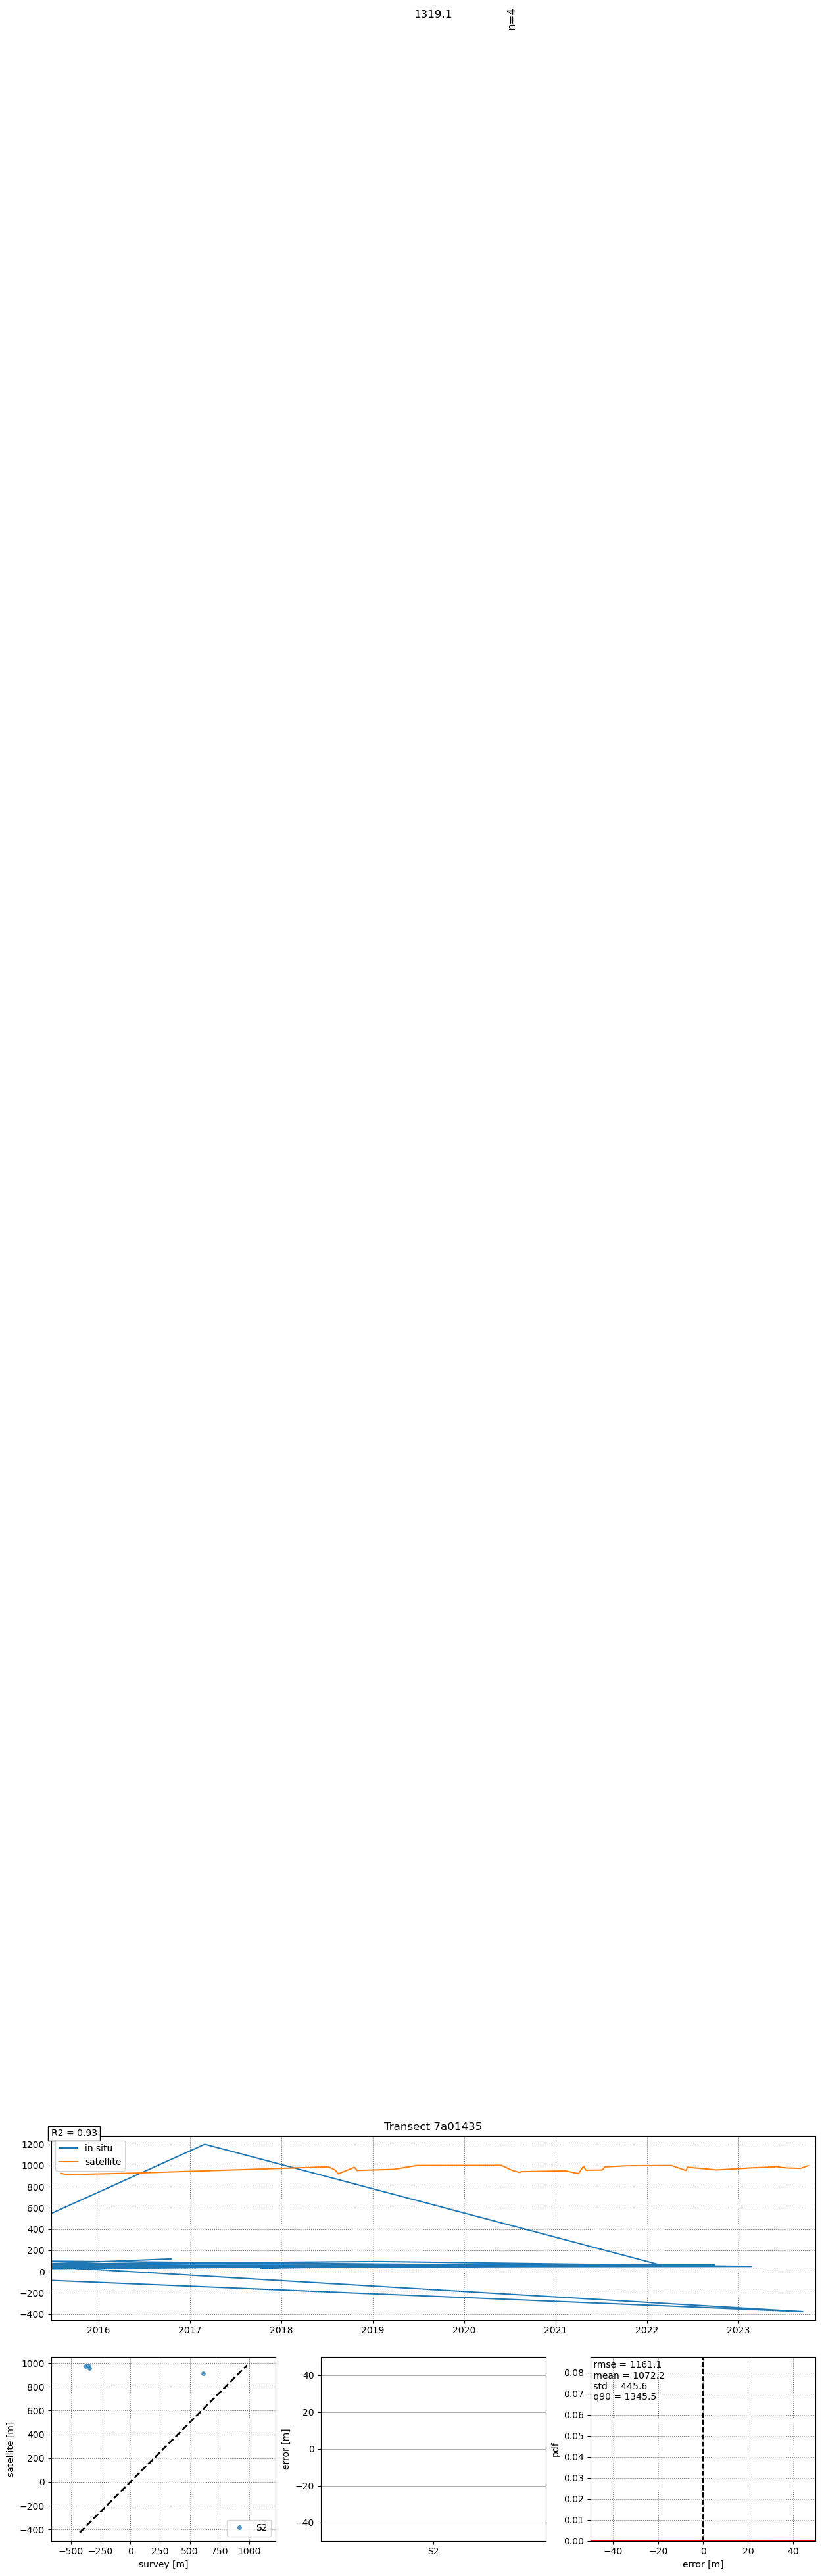

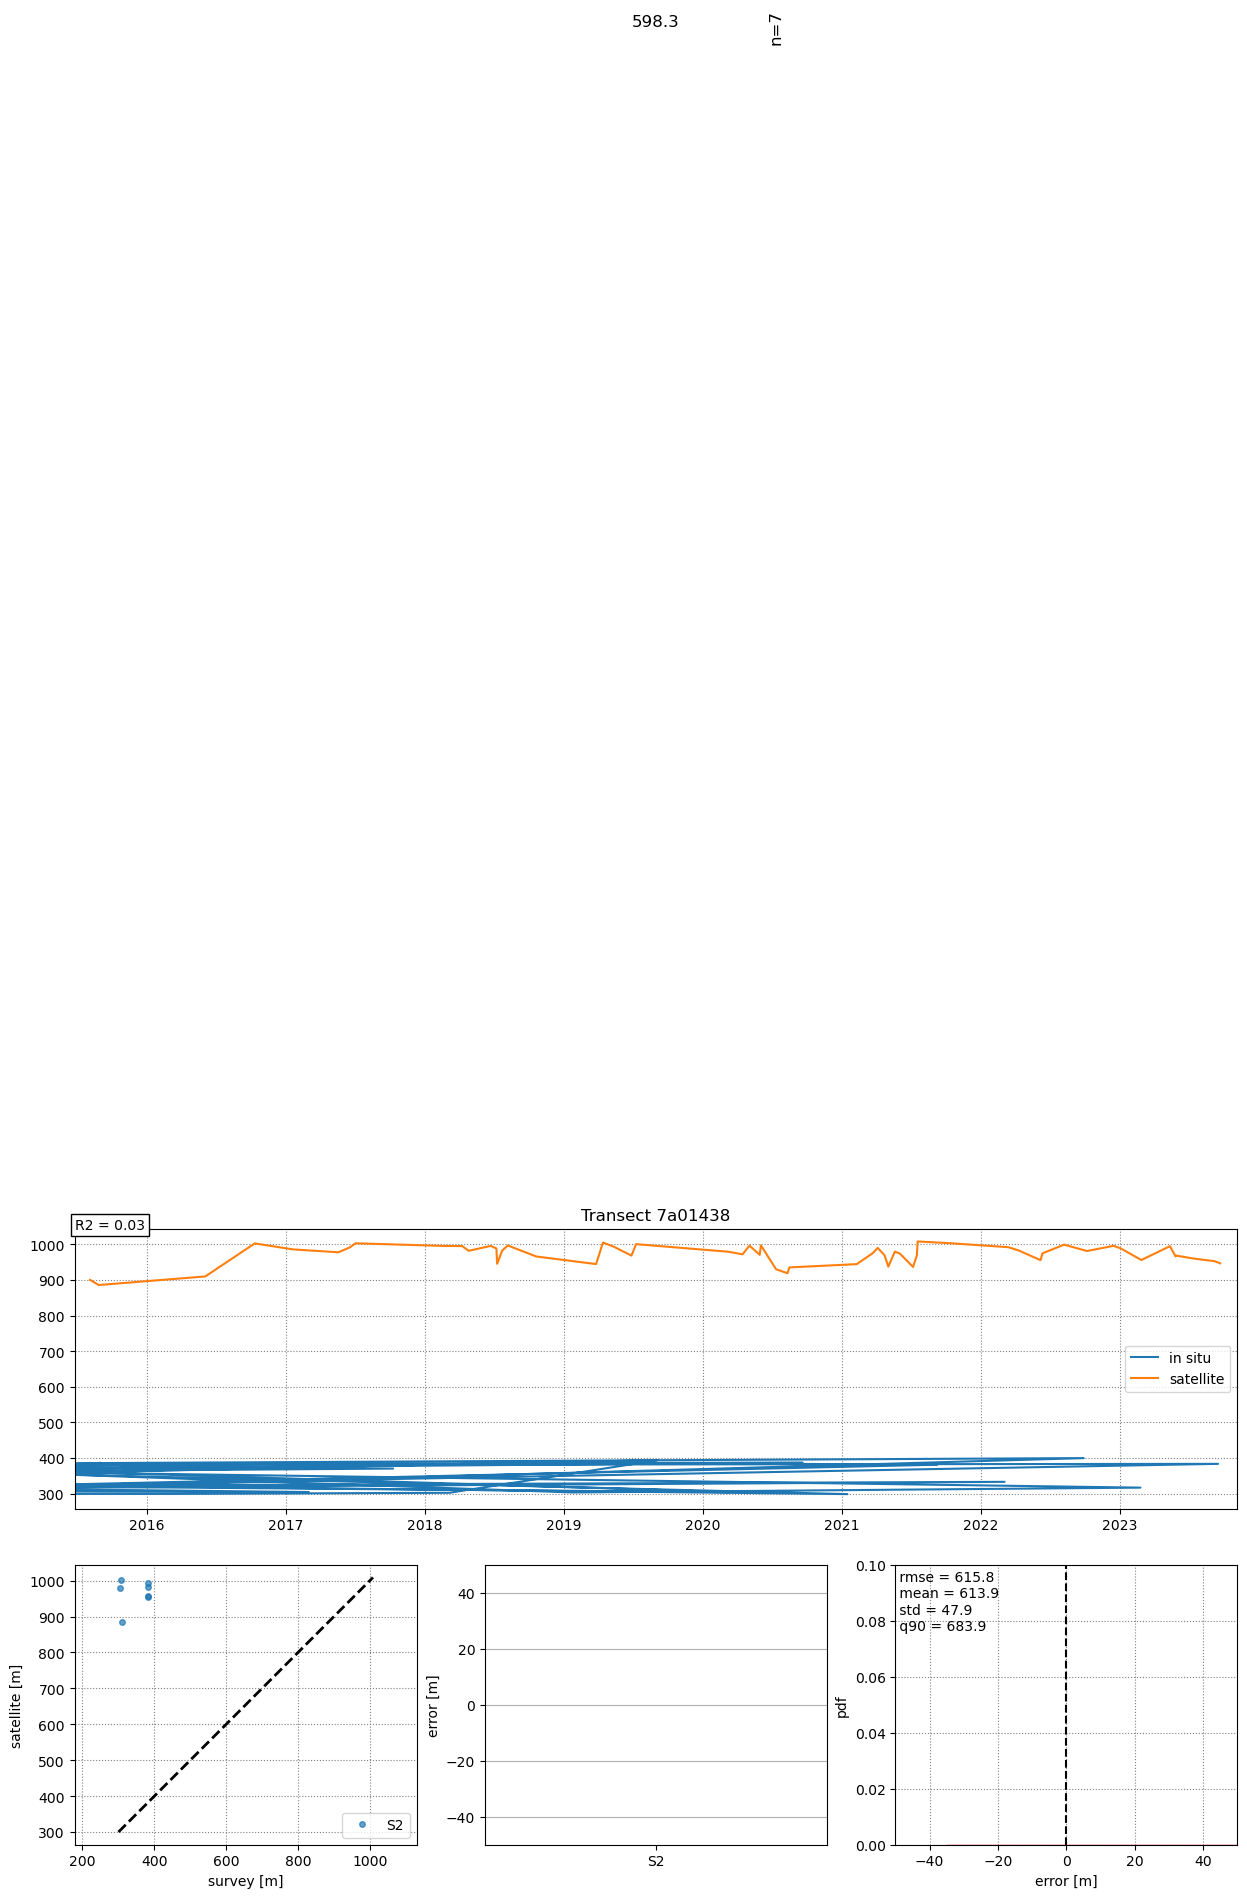

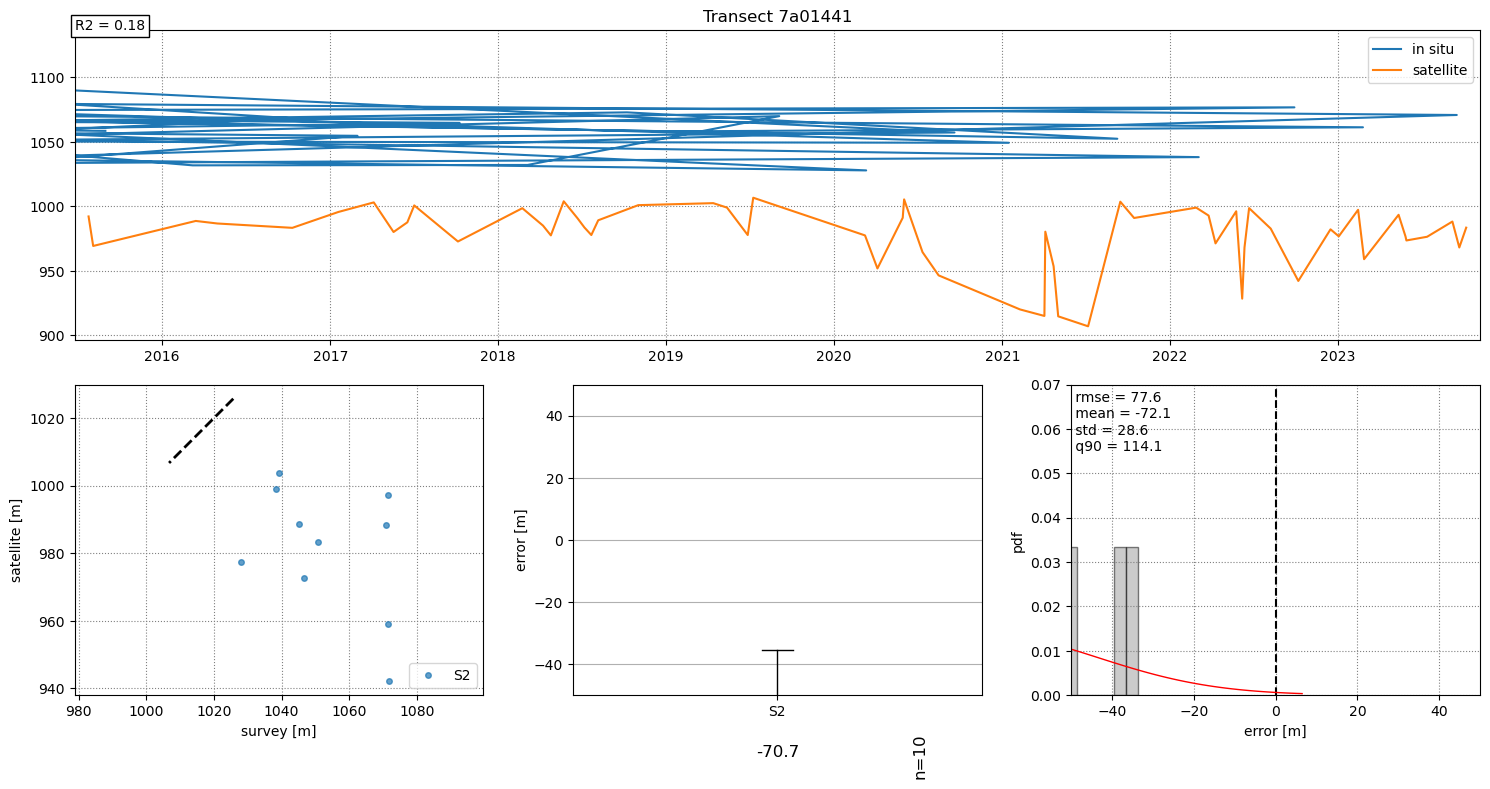

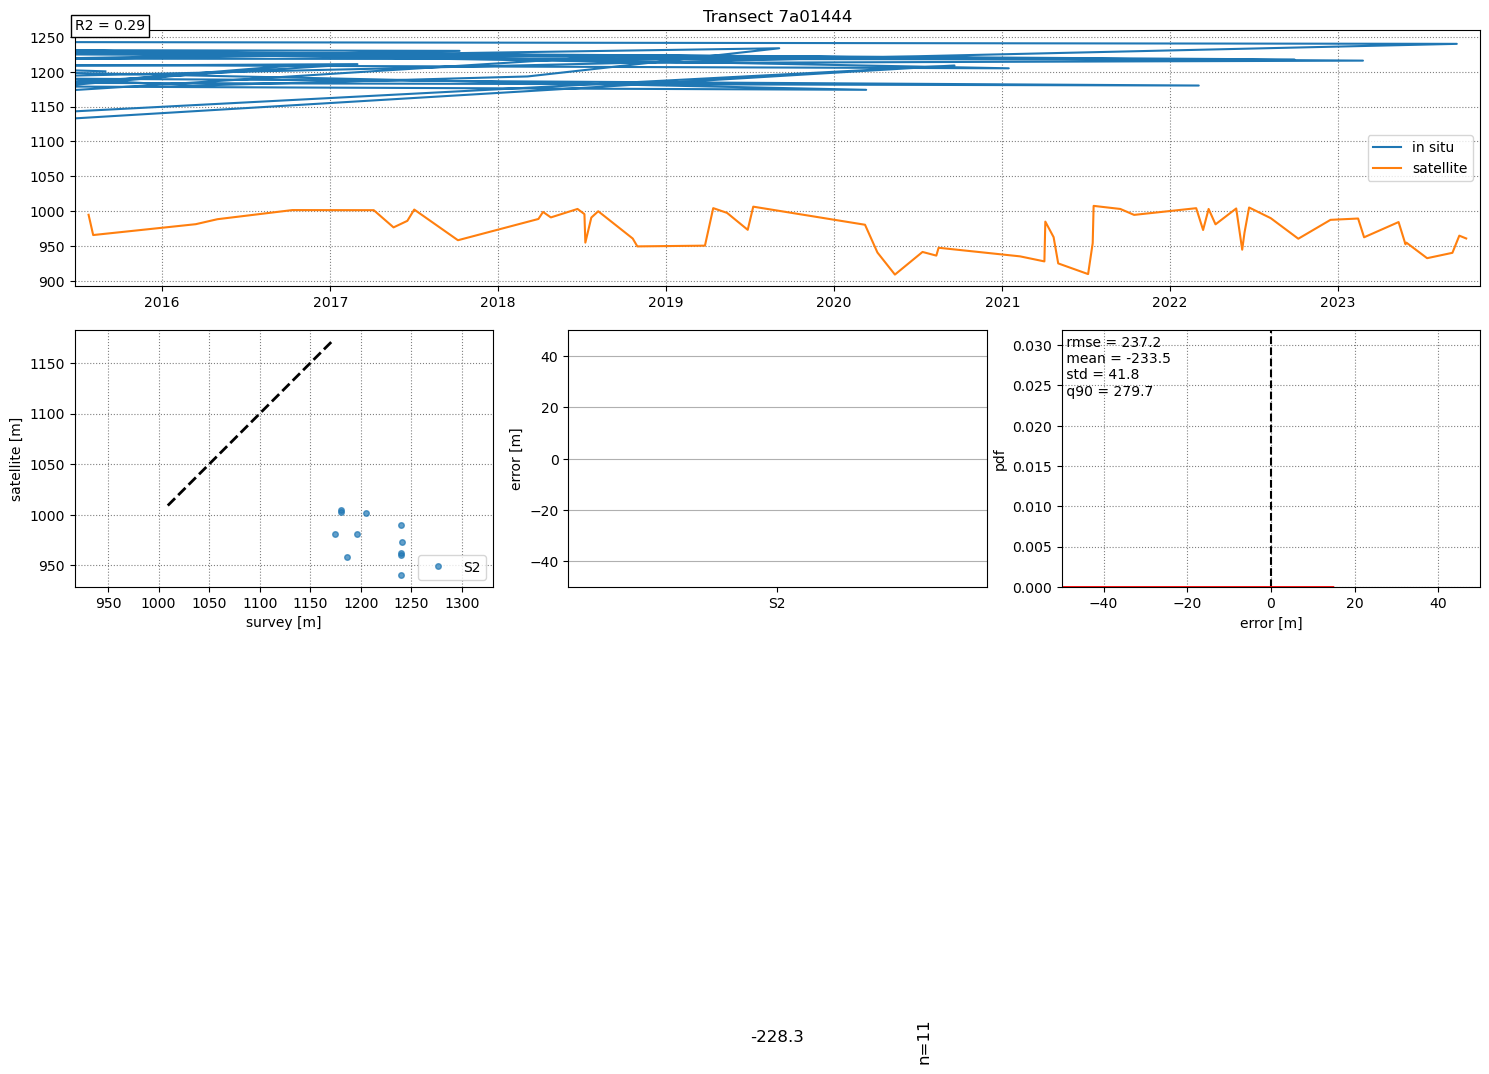

In [52]:
#Helen amended code

%matplotlib inline

# load survey data
with open(os.path.join(os.getcwd(), 'data', 'PERRANPORTH', 'Perranporth_ts_07m.pkl'), 'rb') as f:
    gt = pickle.load(f)
# change names to mach surveys
for i,key in enumerate(list(cross_distance.keys())):
    key_gt = list(gt.keys())[i]
    cross_distance[key_gt] = cross_distance.pop(key)

# set parameters for comparing the two time-series
sett = {'min_days':3,   # numbers of days difference under which to use nearest neighbour interpolation
        'max_days':10,  # maximum number of days difference to do a comparison
        'binwidth':3,   # binwidth for histogram plotting
        'lims':[-50,50] # cross-shore change limits for plotting purposes
       }

# initialise variables
chain_sat_all = []
chain_sur_all = [] 
satnames_all = []  
for key in cross_distance.keys():
    
    # remove nans
    chainage = cross_distance[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainages']
    
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, '-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    
    # interpolate surveyed data around satellite data
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date 
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within 10 days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within 3 days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainages'][idx_closest[0][0]])
            else: # otherwise, between 3 and 10 days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainages'][idx_before], gt[key]['chainages'][idx_after]]
                f = interpolate.interp1d(x, y,bounds_error=True)
                chain_int[k] = float(f(date.toordinal()))
    
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2 
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))): 
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')

    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    
    # Histogram
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.grid(which='major', linestyle=':', color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth = sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    
    # Perform skewness test only if there are enough samples
    if len(chain_error) >= 8:
        pval = stats.normaltest(chain_error)[1]
    else:
        pval = np.nan
    
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
    ax3.text(0, 0.98, str_stats, va='top', transform=ax3.transAxes)

    # save plot
    fig.savefig(os.path.join(os.getcwd(),'data', 'PERRANPORTH','comparison_transect_%s.jpg'%key), dpi=150)

plt.show()

We can also look at the error statistics for all transects:

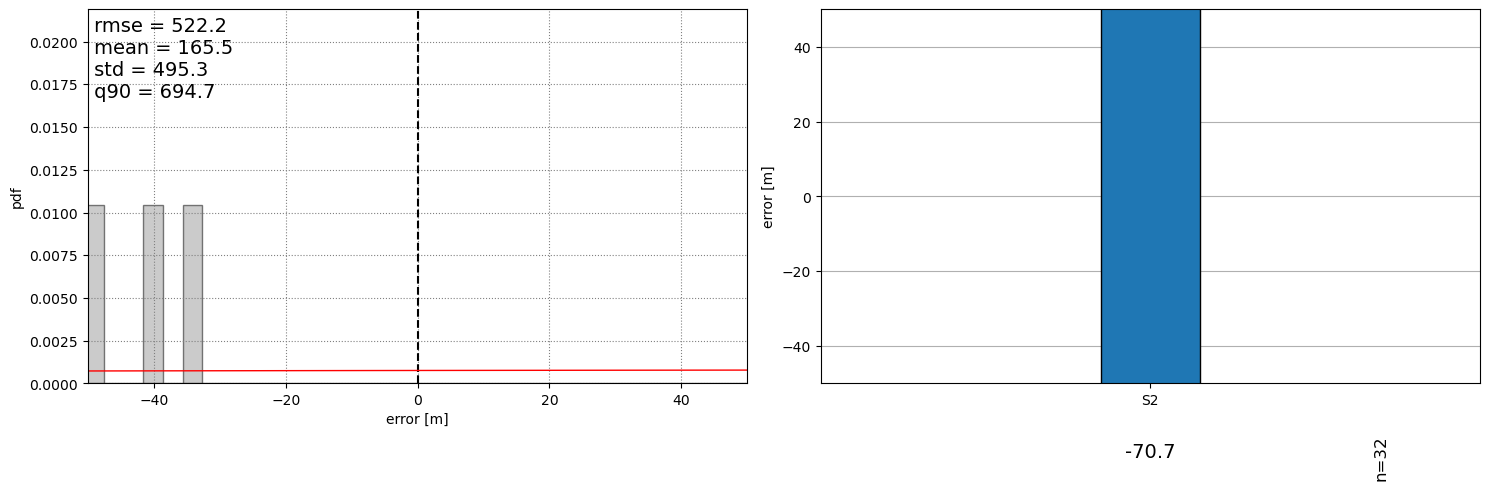

In [53]:
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all        
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat) 
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)

fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)

# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);
fig.savefig(os.path.join(os.getcwd(),'data', 'PERRANPORTH','comparison_all_transects.jpg'), dpi=150)

%matplotlib inline
plt.show()